![Banner](../images/banner.png)

## [[DSC-2023](https://comp.ita.br/dsc/edicoes/2023/)] Develop accurate models that can improve Estimated Landing Time (ELDT) predictability and contribute to more efficient and safe air transport.

### Authors: [João Dantas](https://www.linkedin.com/in/jpdantas/), [Lucas Lima](https://www.linkedin.com/in/lucaslima25/) and [Samara Ribeiro](https://www.linkedin.com/in/samara-ribeiro-silva-a7b89125b/)

##### Python version

In [1]:
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.11.4


##### Packages

In [2]:
# !pip install scikeras[tensorflow] --user -q
# !pip install PythonMETAR -q
# !pip install xgboost -q
# !pip install opencv-python -q
# !pip install cartopy

In [3]:
from datetime import datetime, timedelta
from joblib import dump, load
from time import time, sleep
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow import keras, test, random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from keras.losses import MeanSquaredError
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax, Adadelta, Adagrad, RMSprop
from sklearn.base import BaseEstimator, TransformerMixin
from PythonMETAR import Metar
from xgboost import XGBRegressor
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, \
    ReduceLROnPlateau, TerminateOnNaN, BackupAndRestore

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests as req
import cv2
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import os
import re

2023-10-09 18:45:27.404892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 18:45:28.160178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
pd.set_option('mode.chained_assignment', None)

##### Versions of packages used in this jupyter notebook

In [6]:
!pip install -q -U watermark
    
%reload_ext watermark
%watermark -a "HSO Team" --iversions

/bin/bash: /home/lucas/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Author: HSO Team

pandas    : 1.5.3
tensorflow: 2.13.0
re        : 2.2.1
numpy     : 1.24.3
xgboost   : 2.0.0
cartopy   : 0.22.0
cv2       : 4.8.0
seaborn   : 0.12.2
matplotlib: 3.7.1
keras     : 2.13.1
requests  : 2.31.0



##### Check gpu

In [7]:
try:
    device_name = test.gpu_device_name()
    if(device_name):
        print('Found GPU at: {}'.format(device_name))
    else:
        raise

except:
    print('GPU device not found')

Found GPU at: /device:GPU:0


2023-10-09 18:45:35.837877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-09 18:45:35.908944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-09 18:45:35.909083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-09 18:45:37.068608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-09 18:45:37.068739: I tensorflow/compile

##### Main variables

In [8]:
# values below 2000 records generate inconsistencies in the logic of feature engineer
training_sample_size = 1 # 0 a 1 (0% a 100%)
fold_cross_validation = 5
ann_epochs = 1000
pca_n_components = 25
pca_n_components_mxgb = 10
xgb_estimators = 1000000
verbose = 1

In [9]:
seed = 25

#Numpy
np.random.seed(seed)

# TensorFlow
random.set_seed(seed)

<a id="index"></a>

# Index

## 1. [Data processing](#data_processing)

### &emsp;1.1 [Auxiliary classes and function](#auxiliary_classes_and_function)

#### &emsp;&emsp;&emsp;1.1.1 [Get data by REST API](#get_data)
#### &emsp;&emsp;&emsp;1.1.2 [Eliminates outliers](#eliminates_outliers)
#### &emsp;&emsp;&emsp;1.1.3 [Creates estimate record based on route and reference time](#estimate_based_route)
#### &emsp;&emsp;&emsp;1.1.4 [Obtains geometric information (linearity) of the path taken](#linearity)
#### &emsp;&emsp;&emsp;1.1.5 [Create features based on METAR translation](#metar)
#### &emsp;&emsp;&emsp;1.1.6 [Obtains meteorology image of the flight path](#meteorological)
#### &emsp;&emsp;&emsp;1.1.7 [MXGB Remove Constant Attribute](#mxgb_remove_contant)
#### &emsp;&emsp;&emsp;1.1.8 [Plot Boxplot](#plot_boxplot)



### &emsp;1.2 [Pipeline](#pipeline)

#### &emsp;&emsp;&emsp;1.2.1 [Imputer](#pipeline_imputer)
#### &emsp;&emsp;&emsp;1.2.2 [Feature Engineer](#pipeline_feature_eng)
#### &emsp;&emsp;&emsp;1.2.3 [Encode Categorical Variable](#pipeline_encode_cat)
#### &emsp;&emsp;&emsp;1.2.4 [Transformation](#pipeline_trans)

### &emsp;1.3 [Data](#data)

#### &emsp;&emsp;&emsp;1.3.1 [Obtaining](#data_obtain)
#### &emsp;&emsp;&emsp;&emsp;&emsp;2.3.1.1 [BINTRA](#data_bintra)
#### &emsp;&emsp;&emsp;&emsp;&emsp;2.3.1.2 [CAT-62](#data_cat_62)
#### &emsp;&emsp;&emsp;&emsp;&emsp;2.3.1.3 [ESPERAS](#data_hold)
#### &emsp;&emsp;&emsp;&emsp;&emsp;2.3.1.4 [METAF](#data_metaf)
#### &emsp;&emsp;&emsp;&emsp;&emsp;2.3.1.5 [METAR](#data_metar)
#### &emsp;&emsp;&emsp;&emsp;&emsp;2.3.1.6 [SATELITE](#data_sat)
#### &emsp;&emsp;&emsp;&emsp;&emsp;2.3.1.7 [TC-PREV](#data_tc_prev)
#### &emsp;&emsp;&emsp;&emsp;&emsp;2.3.1.8 [TC-REAL](#data_tc_real)
<br>

#### &emsp;&emsp;&emsp;1.3.2 [Join](#data_join)
#### &emsp;&emsp;&emsp;1.3.3 [Training and Validation Set](#data_train_and_valid)
#### &emsp;&emsp;&emsp;1.3.4 [Test Set](#data_test)
<br>

## 2. [Models](#models)

### &emsp;2.1 [Dummy Model](#models_dummy)

#### &emsp;&emsp;&emsp;2.1.1 [Inference](#models_dummy_inf)
#### &emsp;&emsp;&emsp;2.1.2 [Submission](#models_dummy_sub)

### &emsp;2.2 [Artificial Neural Network](#models_ann)

#### &emsp;&emsp;&emsp;2.2.1 [Pipeline](#models_ann_pipe)
#### &emsp;&emsp;&emsp;2.2.2 [Training](#models_ann_train)
#### &emsp;&emsp;&emsp;2.2.3 [Result](#models_ann_res)

### &emsp;2.3 [Xgboost](#models_xgb)

#### &emsp;&emsp;&emsp;2.3.1 [Pipeline](#models_xgb_pipe)
#### &emsp;&emsp;&emsp;2.3.2 [Training](#models_xgb_train)
#### &emsp;&emsp;&emsp;2.3.3 [Result](#models_xgb_res)

### &emsp;2.4 [Multiple Xgboost](#models_mxgb)

#### &emsp;&emsp;&emsp;2.4.1 [Data adaptation](#models_mxgb_data)
#### &emsp;&emsp;&emsp;2.4.2 [Training](#models_mxgb_train)
<br>

## 3. [Test](#test)

### &emsp;3.1 [Artificial Neural Network](#test)

#### &emsp;&emsp;&emsp;3.1.1 [Inference](#test_ann_inf)
#### &emsp;&emsp;&emsp;3.1.2 [Submission](#test_ann_sub)

### &emsp;3.2 [Xgboost](#test_xgb)

#### &emsp;&emsp;&emsp;3.2.1 [Inference](#test_xgb_inf)
#### &emsp;&emsp;&emsp;3.2.2 [Submission](#test_xgb_sub)

### &emsp;3.3 [Multiple Xgboost](#test_mxgb)

#### &emsp;&emsp;&emsp;3.3.1 [Inference](#test_mxgb_inf)
#### &emsp;&emsp;&emsp;3.3.2 [Submission](#test_mxgb_sub)

<a id="data_processing"></a>

# 1 Data processing

##### Data schema

In [10]:
categorical_selected_cols = ['origem', 'destino', 'metar', 'hora_ref', 'path', 'snapshot_radar']
numerical_selected_cols = ['troca', 'esperas']

selected_cols = categorical_selected_cols + numerical_selected_cols

In [11]:
paramsDefault = {
    'idate': '2022-06-02', # Data inicial da consulta | Example : AAAA-MM-DD
    'fdate': '2023-05-11' # Data final da consulta | Example : AAAA-MM-DD
}

<a id="auxiliary_classes_and_function"></a>

## 1.1 Auxiliary classes and function

<a id="get_data"></a>

### 1.1.1 Get data by REST API

In [12]:
def getData(route, paramsWithoutToken = paramsDefault, token = 'a779d04f85c4bf6cfa586d30aaec57c44e9b7173'):
    """
    Fetches data from a specific API, handling exceptions and returning the data as a DataFrame.

    :param route: String representing the API endpoint.
    :param paramsWithoutToken: Dictionary containing the request parameters without the token. Defaults to paramsDefault.
    :param token: String containing the authentication token. Defaults to a fixed token.
    
    :return: A pandas DataFrame containing the data fetched from the API.
    
    :raises: May propagate exceptions related to the request if they occur.
    """
        
    url = f'http://montreal.icea.decea.mil.br:5002/api/v1/{route}'
    params = paramsWithoutToken
    params['token'] = token
    data = None
    
    while True:
        try:
            response = req.get(url, params)
            response.raise_for_status()
            data = response.json()
            break
            
        except:
            continue
    
    return pd.DataFrame(data)

#### [↥ return to index](#index)

<a id="eliminates_outliers"></a>

### 1.1.2 Eliminates outliers

In [13]:
def dropOutlier(X, name_cols, lower_percentile=0.05, upper_percentile=0.95):
    X['route'] = X['origem'] + '_' + X['destino']  
    keep_rows = pd.Series([True] * X.shape[0], index=X.index)
    
    for route in X['route'].unique():
    
        for col in name_cols:
            lower_bound = X[X['route'] == route][col].quantile(lower_percentile)
            upper_bound = X[X['route'] == route][col].quantile(upper_percentile)
            keep_rows &= (X['route'] != route) | ((X[col] >= lower_bound) & (X[col] <= upper_bound))
        
    X.drop('route', axis = 1, inplace = True)

    return X[keep_rows]

#### [↥ return to index](#index)

<a id="estimate_based_route"></a>

### 1.1.3 Creates estimate record based on route and reference time

In [14]:
class EstimatedDuration(BaseEstimator, TransformerMixin):
    """
    Estimator that calculates the estimated duration based on route and time of day.
    
    Attributes:
        _dammy_estimator (DataFrame): Table with average durations by route and time of day.
        _selected_cols (list): Selected columns from the DataFrame.
    """
    
    def __init__(self, _selected_cols, _dammy_estimator = None):
        """
        Initializes the estimator with selected columns and optionally a dummy estimator.
        
        :param _selected_cols: List of selected columns.
        :param _dammy_estimator: Optional dummy estimator. Default is None.
        """
        self._dammy_estimator = _dammy_estimator
        self._selected_cols = _selected_cols

    def fit(self, X, y=None):
        """
        Fits the estimator to the data set.
        
        :param X: Input DataFrame.
        :param y: Series with durations. Default is None.
        :return: Returns the fitted object.
        """
        
        if y is not None:
            X = pd.DataFrame(X, columns = self._selected_cols)
            X['duration'] = y.values
            X['route'] = X['origem'] + '_' + X['destino']            
            X['only_hour'] = X.apply(lambda row: self._gethourFromDatetime(row), axis = 1)

            avarageRouteHour = X.groupby(['route', 'only_hour']).agg({'duration': ['mean']})['duration'].reset_index()
            avarageRoute = X.groupby(['route']).agg({'duration': ['mean']})['duration'].reset_index()           
            avarageRouteHour.columns = ['route', 'only_hour', 'mean_hour']
            avarageRoute.columns = ['route', 'mean_absolute']
            self._dammy_estimator = avarageRouteHour.merge(avarageRoute, on=['route'], how='left')
        
        return self
    
    def transform(self, X, y=None):
        """
        Transforms the DataFrame X based on the estimated duration.
        
        :param X: Input DataFrame.
        :param y: Ignored.
        :return: Transformed DataFrame with estimated duration.
        """
        
        X = pd.DataFrame(X, columns = self._selected_cols)
        X['route'] = X['origem'] + '_' + X['destino']
        X['only_hour'] = X.apply(lambda row: self._gethourFromDatetime(row), axis = 1)
        X['estimated_duration'] = X.apply(lambda row: self._dammy_predict(row['route'], row['only_hour']), axis = 1)
        X.drop('route', axis = 1, inplace = True)
        
        return X
    
    def _dammy_predict(self, route, hour):
        """
        Predicts the duration based on route and time of day.
        
        :param route: Desired route.
        :param hour: Hour of the day.
        :return: Estimated duration.
        """
            
        try:
            return self._dammy_estimator[
                (self._dammy_estimator['route'] == route) & (self._dammy_estimator['only_hour'] == hour)
            ].iloc[0, 2]
        
        except:
            try:
                return self._dammy_estimator[self._dammy_estimator['route'] == route].iloc[0, 3]
            except:
                return 0
    
    def _gethourFromDatetime(self, row):
        """
        Extracts the hour from a datetime column.
        
        :param row: Row from the DataFrame.
        :return: Extracted hour.
        """
            
        try:
            return datetime.strptime(row['hora_ref'], "%Y-%m-%d %H:%M:%S").hour

        except:
            try:
                return datetime.strptime(row['hora_ref'], "%Y-%m-%d %H:%M:%S.%f").hour
            
            except:
                return datetime.strptime(row['hora_ref'], "%H:%M:%S").hour
        
    def get_params(self, deep=True):
        """
        Returns the estimator's parameters.
        
        :param deep: Ignored. Retained for compatibility with sklearn's interface.
        :return: Dictionary with the parameters.
        """
            
        return {
            "_dammy_estimator": self._dammy_estimator,
            "_selected_cols": self._selected_cols
        }
    
    def set_params(self, **params):
        """
        Sets the estimator's parameters.
        
        :param params: Dictionary with the new parameters.
        :return: Returns the object with updated parameters.
        """
        
        valid_params = self.get_params(deep=True)
        
        for key, value in params.items():
            if key not in valid_params:
                raise ValueError(f"Invalid parameter {key} for estimator {self.__class__.__name__}. Check the list of available parameters with `estimator.get_params().keys()`.")
            
            setattr(self, key, value)
        
        return self

#### [↥ return to index](#index)

<a id="linearity"></a>

### 1.1.4 Obtains geometric information (linearity) of the path taken

![Rotas](../images/r2route.png)

In [15]:
class SnapshotRadarHandler(BaseEstimator, TransformerMixin):
    """
    Handler for Radar Snapshots (SnapshotRadar).

    This class is responsible for processing radar trajectory data and 
    deriving features such as route linearity. It inherits functionalities 
    from the BaseEstimator and TransformerMixin classes of Scikit-Learn.

    Methods:
    - fit: Sets the internal state of the transformer based on the input data.
    - transform: Applies transformations on the input data, producing new features.
    - _haversine_distance: Calculates the straight-line distance between two geographical points.

    Note: Some functionalities and calculations, such as direct distance and 
    travelled distance, are commented out in the code. They can be uncommented 
    and used as needed.
    """
    def fit(self, X, y=None):
        return self

  
    def transform(self, X, y=None):
        """
        Transforms the input data by adding the route linearity metric.

        Parameters:
        - X : DataFrame
            Input data containing the 'snapshot_radar' column with coordinates.
        - y : array-like, default=None
            Target labels. Not used, but retained for compatibility.

        Returns:
        - X : DataFrame
            Transformed input data with an additional 'route_linearity' column.
        """
        route_linearity_aux = []

        for _, row in X.iterrows():
            multipoint_str = row['snapshot_radar']

            coords = re.findall(r'(-?\d+\.\d+) (-?\d+\.\d+)', multipoint_str)
            points_rad = np.array(coords, dtype=float)
            points = np.degrees(points_rad)

            if len(points) < 2:

                direct_distance = 1200
                travelled_distance = 1200
                route_linearity = 1.0

            else:
                lon = points[:, 0]
                lat = points[:, 1]

                # Split points into X and y
                _X = lat.reshape(-1, 1)
                _y = lon

                # Create, fit the model and return the R^2 value        
                score = LinearRegression().fit(_X, _y).score(_X, _y)
                route_linearity = score

                plot = False 

                if plot:
                    # Criando figura e eixos
                    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': ccrs.PlateCarree()})
                    ax.set_extent([-55, -33, -32, 0])
                    ax.add_feature(cfeature.BORDERS, linestyle=':')
                    ax.add_feature(cfeature.COASTLINE)
                    ax.add_feature(cfeature.LAND, edgecolor='black')                    
                    ax.set_title(
                        f"Coefficient of Determination (R²): {score:.3f}"
                    )
                    
                    for n in range(len(lat)):
                        ax.plot(lon[n], lat[n], 'ro', markersize=1)    

                    plt.show()
                    plt.close()

            route_linearity_aux.append(route_linearity)

        X['route_linearity'] = route_linearity_aux

        X.drop('snapshot_radar', axis = 1, inplace = True)

        return X

#### [↥ return to index](#index)

<a id="metar"></a>

### 1.1.5 Create features based on METAR translation

In [16]:
class MetarHandler(BaseEstimator, TransformerMixin):
    """
    Transformer that translates METAR information into numerical features.
    
    This transformer extracts specific METAR information and adds corresponding 
    numerical features to the DataFrame.
    """

    def fit(self, X, y=None):
        """
        Fits the transformer to the dataset. In this case, the method is passive and doesn't perform operations.
        
        :param X: Input DataFrame.
        :param y: Ignored.
        :return: Returns the fitted object.
        """
        
        return self

    def transform(self, X, y=None):
        """
        Transforms the DataFrame X by extracting METAR information and converting it into numerical features.
        
        :param X: Input DataFrame containing a 'metar' column with METAR information.
        :param y: Ignored.
        :return: Transformed DataFrame with numerical features derived from METAR information.
        """
        
        X['wind_variation'] = 0.0
        X['qnh'] = 0.0
        X["cavok"] = 0.0
        X["gust"] = 0.0
        X["FEW_presenceCB"] = 0.0

        for index, row in X.iterrows():
            translationMetar = Metar(row['destino'], row['metar'])
            X.loc[index, 'cavok'] = float(bool(re.search('CAVOK', row['metar'])))

            if(translationMetar.wind):
                X.loc[index, 'wind_variation'] = float(translationMetar.wind['variation'] != None)
                X.loc[index, 'gust'] = float(translationMetar.wind['gust'] != None)
            else:
                # Se não tem informação de vento significa METAR no formato ex.: VRB07G17KT (vento variavel com rajada)
                X.loc[index, 'gust'] = 1

            if(translationMetar.qnh):
                X.loc[index, 'qnh'] = float(translationMetar.qnh)

            if(translationMetar.cloud):
                for formation in translationMetar.cloud:
                    if(formation['code'] == 'FEW'):
                        X.loc[index, "FEW_presenceCB"] = float(formation['presenceCB']) 
                    
        X.drop('metar', axis = 1, inplace = True)
        
        return X

#### [↥ return to index](#index)

<a id="meteorological"></a>

### 1.1.6 Obtains meteorology image of the flight path

![Rotas](../images/routes3.jpg)

<img src="../images/routes.png" alt="Rotas" width="700" height="800">

In [17]:
class SatelliteImageHandler(BaseEstimator, TransformerMixin):
    """
    Handler for satellite images for feature extraction and transformation.
    
    This transformer processes satellite images, extracts specific information, 
    and converts that information into numerical features in a DataFrame.
    
    Attributes:
        _restore (str): Path for route image data.
        _width (int): Width of the image.
        _outputWidth (int): Output image width.
        _outputHeight (int): Output image height.
        _printRoutes (bool): Indicates if the routes should be printed.
        _printImage (bool): Indicates if the image should be printed.
        _imagesRouteData (DataFrame): Route image data.
        _itineraries (list): List of itineraries.
        _date (dict): Date range.
        _location (dict): Airport locations.
    """
    
    def __init__(self, _restore=None, _width=50, _outputWidth=128,
                 _outputHeight=32, _printRoutes=False, _printImage=False):
        """
        Initializes the image handler with the specified parameters.
        
        :param _restore: Path to restore the route image data.
        :param _width: Width of the image.
        :param _outputWidth: Output image width.
        :param _outputHeight: Output image height.
        :param _printRoutes: Whether the routes should be printed.
        :param _printImage: Whether the image should be printed.
        """
        
        self._restore = _restore
        self._width = _width
        self._outputWidth = _outputWidth
        self._outputHeight = _outputHeight
        self._printRoutes = _printRoutes
        self._printImage = _printImage
        self._imagesRouteData = None
        self._itineraries = []
        self._date = paramsDefault = {
            'idate': '2022-06-02', 
            'fdate': '2023-05-11'
        }          
        
        self._location = {
            'SBGR': [1665, 1459],
            'SBCF': [1722, 1376],
            'SBRJ': [1739, 1447],
            'SBPA': [1557, 1614],
            'SBSV': [1853, 1217],
            'SBFL': [1618, 1562],
            'SBRF': [1932, 1106],
            'SBBR': [1632, 1286],
            'SBCT': [1599, 1509],
            'SBSP': [1662, 1469],
            'SBKP': [1648, 1453],
            'SBGL': [1740, 1446]
        }
        
        
        for aero_from in self._location.keys():
            for aero_to in self._location.keys():
                if aero_from == aero_to:
                    continue
                    
                self._itineraries.append(f"{aero_from}_{aero_to}")
                                                    

    def fit(self, X, y=None):
        """
        Fits the transformer to the dataset. The method loads the route image data if specified.
        
        :param X: Input DataFrame.
        :param y: Ignored.
        :return: Returns the fitted object.
        """
        
        if self._restore:
            self._imagesRouteData = pd.read_csv(self._restore)
            return self
        
        route = []
        hora_ref = []
        imageSatelite_red = []
        imageSatelite_yellow = []
        imageSatelite_green = []
        imageSatelite_blue = []

        df_sat_met = getData(route = 'satelite', paramsWithoutToken = self._date)

        firstCicle = True
        
        for _, row in df_sat_met.iterrows():
                       
            print(f"date: {row['data']}")

            while True:
                try:
                    response = req.get(row['path']).content
                    break
                except:
                    print(f"requisição falhou em {row['data']}. Aguardar 5 segs e retomar deste ponto")
                    sleep(5)

            arrayImage = np.asarray(bytearray(response), dtype=np.uint8)
            cv2ImageBGR = cv2.imdecode(arrayImage, cv2.IMREAD_COLOR)

            # Converta a imagem para escala de cinza
            cv2ImageRGB = cv2.cvtColor(cv2ImageBGR, cv2.COLOR_BGR2RGB)
          
            if firstCicle:
                cv2ImageRGBCopy = cv2ImageRGB.copy()

            for itinerary in self._itineraries:        
                [origin, destiny] = itinerary.split('_')
                p_from = np.array(self._location[origin])
                p_to = np.array(self._location[destiny])

                # Vetor direcional
                v = p_to - p_from
                v = v / np.linalg.norm(v)  # Normaliza o vetor

                # Vetor perpendicular
                v_perp = np.array([v[1], -v[0]])

                # Pontos do quadrilátero usando o padding para determinar as extremidades
                padding = self._width/2
                p2 = p_to + v * padding + v_perp * padding
                p3 = p_to + v * padding - v_perp * padding
                p1 = p_from - v * padding + v_perp * padding
                p4 = p_from - v * padding - v_perp * padding

                if firstCicle:
                    pts = np.array([p1, p2, p3, p4], np.int32)
                    pts = pts.reshape((-1, 1, 2))

                    # Desenhe o paralelogramo vermelho
                    color = (255, 0, 0)  # Vermelho em RGB
                    thickness = 4  # Define a espessura da linha do paralelogramo
                    cv2.polylines(cv2ImageRGBCopy, [pts], isClosed=True, color=color, thickness=thickness)



                satelitePoints = np.array([p1, p2, p3, p4], dtype=np.float32)
                outputPoints = np.array([[0, 0], [self._outputWidth, 0],
                                         [self._outputWidth, self._outputHeight],
                                         [0, self._outputHeight]], dtype=np.float32)

                # Calcula a matriz de transformação de perspectiva
                matriz = cv2.getPerspectiveTransform(satelitePoints, outputPoints)

                # Realiza a transformação de perspectiva
                outputImage = cv2.warpPerspective(cv2ImageRGB, matriz, (self._outputWidth, self._outputHeight))

                arrayImageOutput = np.array(outputImage)

                hsv = cv2.cvtColor(arrayImageOutput, cv2.COLOR_RGB2HSV)

                red_lower_limit1 = np.array([0, 50, 50])
                red_upper_limit1 = np.array([12, 255, 255])
                red_lower_limit2 = np.array([150, 50, 50])
                red_upper_limit2 = np.array([180, 255, 255])
                mask_red1 = cv2.inRange(hsv, red_lower_limit1, red_upper_limit1)
                mask_red2 = cv2.inRange(hsv, red_lower_limit2, red_upper_limit2)
                mask_red = cv2.bitwise_or(mask_red1, mask_red2)
                outputImage_red = cv2.bitwise_and(arrayImageOutput, arrayImageOutput, mask=mask_red)
                mean_r = outputImage_red.mean()

                yellow_lower_limit1 = np.array([22, 50, 50])
                yellow_upper_limit1 = np.array([30, 255, 255])
                yellow_lower_limit2 = np.array([31, 50, 50])
                yellow_upper_limit2 = np.array([38, 255, 255])
                mask_yellow1 = cv2.inRange(hsv, yellow_lower_limit1, yellow_upper_limit1)
                mask_yellow2 = cv2.inRange(hsv, yellow_lower_limit2, yellow_upper_limit2)
                mask_yellow = cv2.bitwise_or(mask_yellow1, mask_yellow2)
                outputImage_yellow = cv2.bitwise_and(arrayImageOutput, arrayImageOutput, mask=mask_yellow)
                mean_y = outputImage_yellow.mean()

                green_lower_limit1 = np.array([40, 50, 50])
                green_upper_limit1 = np.array([70, 255, 255])
                green_lower_limit2 = np.array([71, 50, 50])
                green_upper_limit2 = np.array([80, 255, 255])
                mask_green1 = cv2.inRange(hsv, green_lower_limit1, green_upper_limit1)
                mask_green2 = cv2.inRange(hsv, green_lower_limit2, green_upper_limit2)
                mask_green = cv2.bitwise_or(mask_green1, mask_green2)
                outputImage_green = cv2.bitwise_and(arrayImageOutput, arrayImageOutput, mask=mask_green)
                mean_g = outputImage_green.mean()

                blue_lower_limit1 = np.array([100, 50, 50])
                blue_upper_limit1 = np.array([120, 255, 255])
                blue_lower_limit2 = np.array([121, 50, 50])
                blue_upper_limit2 = np.array([140, 255, 255])
                mask_blue1 = cv2.inRange(hsv, blue_lower_limit1, blue_upper_limit1)
                mask_blue2 = cv2.inRange(hsv, blue_lower_limit2, blue_upper_limit2)
                mask_blue = cv2.bitwise_or(mask_blue1, mask_blue2)
                outputImage_blue = cv2.bitwise_and(arrayImageOutput, arrayImageOutput, mask=mask_blue)
                mean_b = outputImage_blue.mean()

                route.append(itinerary)
                hora_ref.append(row['data'])
                imageSatelite_red.append(mean_r)
                imageSatelite_yellow.append(mean_y)
                imageSatelite_green.append(mean_g)
                imageSatelite_blue.append(mean_b)

                if self._printImage:
                    gap_size = 1
                    arrayImageOutput_with_gap = self._add_gap(arrayImageOutput, gap_size)
                    outputImage_red_with_gap = self._add_gap(outputImage_red, gap_size)
                    outputImage_yellow_with_gap = self._add_gap(outputImage_yellow, gap_size)
                    outputImage_green_with_gap = self._add_gap(outputImage_green, gap_size)

                    # Concatenar as imagens verticalmente com espaços
                    concatenated_image = np.vstack((arrayImageOutput_with_gap, outputImage_red_with_gap, outputImage_yellow_with_gap, outputImage_green_with_gap, outputImage_blue))

                    # Exibir a imagem resultante
                    plt.figure(figsize=(10,50)) # 5, 25
                    plt.imshow(concatenated_image)
                    plt.title(f"{itinerary} - {row['data']} r: {mean_r: .1f} y: {mean_y: .1f} g: {mean_g: .1f} b: {mean_b: .1f}", fontsize=6)
                    plt.axis('off')
                    plt.show()

            if firstCicle and self._printRoutes:
                plt.figure(figsize=(16, 16)) # 8,8
                plt.imshow(cv2ImageRGBCopy)
                plt.show()
                plt.close()

                firstCicle = False


        self._imagesRouteData = pd.DataFrame({
            'route': route,
            'hora_ref': hora_ref, 
            'imageSatelite_red': imageSatelite_red,
            'imageSatelite_yellow': imageSatelite_yellow,
            'imageSatelite_green': imageSatelite_green,
            'imageSatelite_blue': imageSatelite_blue
        })
                
        return self

    def transform(self, X, y=None):
        X['route'] = X['origem'] + '_' + X['destino']
        X = X.merge(self._imagesRouteData, on=['hora_ref', 'route'], how='left')
        X.fillna(0, inplace=True)
        X.drop(['route', 'path', 'hora_ref'], axis = 1, inplace = True)
        
        return X
    
    def _add_gap(self, image, gap_size, gap_color=[255, 255, 255]):
        return np.vstack((image, np.full((gap_size, image.shape[1], 3), gap_color, dtype=np.uint8)))

#### [↥ return to index](#index)

<a id="mxgb_remove_contant"></a>

### 1.1.7 MXGB Remove Constant Attribute

In [18]:
class RemoveConstantAttribute(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):               
        X.drop(['origem', 'destino'], axis = 1, inplace = True)
        
        return X

#### [↥ return to index](#index)

<a id="plot_boxplot"></a>

### 1.1.8 Plot Boxtplot

In [19]:
def plot_duration_boxplot(data, x_col, y_col, figsize=(8, 50)):
    f, ax = plt.subplots(figsize=figsize)

    sns.boxplot(   
        data=data, x=x_col, y=y_col,   
        showcaps=True,
        flierprops={"marker": "x"},
        boxprops={"facecolor": (.3, .5, .7, .5)},
        medianprops={"color": "r", "linewidth": 1},
        whis=1.5
    )

    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    plt.legend([], [], frameon=False)

    plt.show()
    plt.close()

In [20]:
def adjust_timestamp(ts):
    timestamp_s = ts / 1000
    dt = datetime.utcfromtimestamp(timestamp_s)
    return dt.replace(minute=0, second=0, microsecond=0)

In [21]:
def timestamp_to_string(timestamp):
    # Convert the timestamp to a datetime object
    dt_object = datetime.fromtimestamp(timestamp)
    
    # Format the datetime object as a string
    formatted_string = dt_object.strftime('%Y-%m-%d %H:%M:%S') + '.' + '{:03d}'.format(int(dt_object.microsecond / 1000))
    
    return formatted_string

In [22]:
def string_to_timestamp(date_str):
    # Convert the string to a datetime object
    dt_object = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')
    
    # Convert the datetime object to a timestamp
    timestamp = dt_object.timestamp()
    
    return timestamp

#### [↥ return to index](#index)

<a id="pipeline"></a>

## 1.2 Pipeline

<a id="pipeline_imputer"></a>

### 1.2.1 Imputer

In [23]:
imputer = ColumnTransformer(
    transformers=[
        (
            'imputer_cat',
            SimpleImputer(strategy='most_frequent'),
            ['origem', 'destino', 'metar', 'hora_ref', 'path', 'snapshot_radar']
        ),
        (
            'imputer_num',
            SimpleImputer(strategy='constant', fill_value=0),
            ['troca', 'esperas']
        )
    ],
    remainder='passthrough'
)

<a id="pipeline_feature_eng"></a>

### 1.2.2 Feature Engineer

In [24]:
feature_engineer = Pipeline(steps=[
    ('feat_eng_est_duration', EstimatedDuration(selected_cols)),
    ('feat_eng_snapshot_radar', SnapshotRadarHandler()),
    ('feat_eng_metar', MetarHandler()),
    ('feat_eng_satelliteImage', SatelliteImageHandler(_restore='../data/imagesRouteData.csv'))    
])

<a id="pipeline_encode_cat"></a>

### 1.2.3 Encode Categorical Variable

In [25]:
coding_category_var = ColumnTransformer(
    transformers=[
        (
            'coding_cat',
            OneHotEncoder(handle_unknown='ignore'),
            ['origem', 'destino']
        ),
    ],
    remainder='passthrough'
)

<a id="pipeline_trans"></a>

### 1.2.4 Transformation

In [26]:
transformer = Pipeline(steps=[
    ('trans_stand', StandardScaler(with_mean=True)),
    # ('trans_norm', Normalizer()),
    # ('trans_pca', PCA(n_components=pca_n_components))
])

##### preprocessor

In [27]:
preprocessor = Pipeline(steps=[
    ('imputer', imputer),
    ('feature_engineer', feature_engineer),
    ('coding_category_var', coding_category_var),
    ('transformer', transformer)
])

In [28]:
preprocessor

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer_cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['origem', 'destino', 'metar',
                                                   'hora_ref', 'path',
                                                   'snapshot_radar']),
                                                 ('imputer_num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['troca', 'esperas'])])),
                ('feature_engineer',
                 Pipeline(steps=[('feat_eng_est_duration'...
                                 ('feat_eng_metar', MetarHandler()),
                                 ('feat_eng_satelliteImage',
                                  SatelliteImageHandler(_restore='../data/imagesRouteData.csv'))])),
                ('coding_category_var',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('coding_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['origem', 'destino'])])),
                ('transformer',
                 Pipeline(steps=[('trans_stand', StandardScaler())]))])

#### [↥ return to index](#index)

<a id="data"></a>

## 1.3 Data

<a id="data_obtain"></a>

### 1.3.1 Obtaining

<a id="data_bintra"></a>

#### 1.3.1.1 BINTRA

In [29]:
# df_bintra = getData('bimtra')

In [30]:
# df_bintra = df_bintra[df_bintra['origem'] != df_bintra['destino']]

In [31]:
# df_bintra['rota'] = df_bintra['origem'] + '_' + df_bintra['destino']

In [32]:
# df_bintra['dt_dep_timestamp'] = df_bintra['dt_dep']
# df_bintra['dt_arr_timestamp'] = df_bintra['dt_arr']
# df_bintra['dt_dep'] = pd.to_datetime(df_bintra['dt_dep_timestamp'], unit='ms')
# df_bintra['dt_arr'] = pd.to_datetime(df_bintra['dt_arr_timestamp'], unit='ms')

In [33]:
# df_bintra['duration'] = (df_bintra['dt_arr_timestamp'] - df_bintra['dt_dep_timestamp'])/1000

In [34]:
# df_bintra.sample(3)

#### [↥ return to index](#index)

<a id="data_cat_62"></a>

#### 1.3.1.2 CAT-62

In [35]:
# start = int(string_to_timestamp('2022-06-01 00:00:00.000'))
# end = int(string_to_timestamp('2023-05-31 00:00:00.000'))

# step = 60 * 60 * 24

# dfCat_62_blocks = list()

# for timestamp in range(start, end, step):
#     dt_i = timestamp_to_string(timestamp)
#     dt_f = timestamp_to_string(timestamp + step)
    
#     print(dt_i)
#     aux = getData('cat-62', {'idate': dt_i, 'fdate': dt_f})
#     if(len(aux) != 0):
#         dfCat_62_blocks.append(aux)
        
# _df_cat_62 = pd.concat(dfCat_62_blocks, ignore_index=True)
        
# df_cat_62 = pd.DataFrame(columns=['snapshot_radar'])
# df_cat_62.index.name = 'flightid'

# for flight in _df_cat_62['flightid'].unique():
    
#     coords = "MULTIPOINT ("
    
#     erase_cumma = False
    
#     for index, row in _df_cat_62[_df_cat_62['flightid'] == flight].iterrows():
#         coords += f"({row['lon']} {row['lat']})"
#         coords += ', '
#         erase_cumma = True

#     if erase_cumma:
#         coords = coords[:-2]
        
#     coords += ")"
    
    
#     df_cat_62.loc[flight, 'snapshot_radar'] = coords
    
# df_cat_62 = df_cat_62.reset_index()       

In [36]:
# df_cat_62 = pd.read_csv('../data/cat_62.csv')

In [37]:
# df_cat_62.sample(3)

#### [↥ return to index](#index)

<a id="data_hold"></a>

#### 1.3.1.3 ESPERAS

In [38]:
# df_esperas = getData('esperas')

In [39]:
# df_esperas['hora_esperas'] = pd.to_datetime(df_esperas['hora'], unit='ms')

In [40]:
# df_esperas['destino'] = df_esperas['aero']

In [41]:
# df_esperas.drop(['hora', 'aero'], axis =1, inplace = True)

In [42]:
# df_esperas.sample(3)

#### [↥ return to index](#index)

<a id="data_metaf"></a>

#### 1.3.1.4 METAF

In [43]:
# df_metaf = getData('metaf')

In [44]:
# df_metaf['hora_metaf'] = pd.to_datetime(df_metaf['hora'], unit='ms')

In [45]:
# df_metaf['aero_metaf'] = df_metaf['aero']

In [46]:
# df_metaf.drop(['hora', 'aero'], axis =1, inplace = True)

In [47]:
# df_metaf.sample(3)

#### [↥ return to index](#index)

<a id="data_metar"></a>

#### 1.3.1.5 METAR

In [48]:
# df_metar = getData('metar')

In [49]:
# df_metar['hora_metar'] = pd.to_datetime(df_metar['hora'], unit='ms')

In [50]:
# df_metar['aero_metar'] = df_metar['aero']

In [51]:
# df_metar.drop(['hora', 'aero'], axis =1, inplace = True)

In [52]:
# df_metar.sample(3)

#### [↥ return to index](#index)

<a id="data_sat"></a>

#### 1.3.1.6 SATELITE

In [53]:
# df_sat_met = getData('satelite')

In [54]:
# df_sat_met['hora_ref'] = pd.to_datetime(df_sat_met['data'])

In [55]:
# df_sat_met.drop(['data'], axis = 1, inplace = True)

In [56]:
# df_sat_met.sample(3)

#### [↥ return to index](#index)

<a id="data_tc_prev"></a>

#### 1.3.1.7 TC-PREV

In [57]:
# df_tcp = getData('tc-prev')

In [58]:
# df_tcp['hora_tcp'] = pd.to_datetime(df_tcp['hora'], unit='ms')

In [59]:
# df_tcp['aero_tcp'] = 'SB' + df_tcp['aero']

In [60]:
# df_tcp.drop(['hora', 'aero'], axis =1, inplace = True)

In [61]:
# df_tcp.sample(3)

#### [↥ return to index](#index)

<a id="data_tc_real"></a>

#### 1.3.1.8 TC-REAL

In [62]:
# df_tcr = getData('tc-real')

In [63]:
# df_tcr['aero_tcr'] = 'SB' + df_tcr['aero']

In [64]:
# df_tcr['hora_tcr'] = df_tcr['hora'].apply(adjust_timestamp)

In [65]:
# aux = df_tcr.groupby(['hora_tcr', 'aero_tcr']).agg({'aero': ['count']}).reset_index()

In [66]:
# aux.columns = aux.columns.droplevel(1)

In [67]:
# aux['troca_real'] = aux['aero']

In [68]:
# df_tcr = aux.drop(['aero'], axis =1)

In [69]:
# df_tcr.sample(3)

#### [↥ return to index](#index)

<a id="data_join"></a>

### 1.3.2 Join

In [70]:
# df_bintra['hora_ref'] = df_bintra['dt_dep_timestamp'].apply(adjust_timestamp)

In [71]:
# df_bintra['hora_esperas'] = df_bintra['hora_ref'] - timedelta(hours=1)

In [72]:
# df_bintra['aero_esperas'] = df_bintra['destino']

In [73]:
# df_bintra['aero_metaf'] = df_bintra['destino']

In [74]:
# df_bintra['hora_metaf'] = df_bintra['hora_ref'] + timedelta(hours=1)

In [75]:
# df_bintra['aero_metar'] = df_bintra['destino']

In [76]:
# df_bintra['hora_metar'] = df_bintra['hora_ref']

In [77]:
# df_bintra['hora_tcp'] = df_bintra['hora_ref'] + timedelta(hours=1)

In [78]:
# df_bintra['aero_tcp'] = df_bintra['destino']

In [79]:
# df_bintra['hora_tcr'] = df_bintra['hora_ref']

In [80]:
# df_bintra['aero_tcr'] = df_bintra['destino']

In [81]:
# merged1_satelite = df_bintra.merge(df_sat_met, on='hora_ref', how='left')

In [82]:
# merged2_esperas = merged1_satelite.merge(df_esperas, on=['hora_esperas', 'destino'], how='left')

In [83]:
# merged3_metaf = merged2_esperas.merge(df_metaf, on=['hora_metaf', 'aero_metaf'], how='left')

In [84]:
# merged4_metar = merged3_metaf.merge(df_metar, on=['hora_metar', 'aero_metar'], how='left')

In [85]:
# merged5_tcp = merged4_metar.merge(df_tcp, on=['hora_tcp', 'aero_tcp'], how='left')

In [86]:
# merged6_tcr = merged5_tcp.merge(df_tcr, on=['hora_tcr', 'aero_tcr'], how='left').set_index('flightid')

In [87]:
# merged7_cat = merged6_tcr.merge(df_cat_62, on=['flightid'], how='left').set_index('flightid')

In [88]:
# data_train_origin = merged7_cat[
#     ['origem', 'destino', 'metar', 'snapshot_radar','hora_ref', 'path', 'troca', 'esperas', 'duration']
# ]

In [89]:
# data_train_origin.loc[:, 'hora_ref'] = data_train_origin['hora_ref'].astype('str')

In [90]:
# data_train_origin.dropna(inplace=True)

In [91]:
# del df_bintra
# del merged1_satelite
# del merged2_esperas
# del merged3_metaf
# del merged4_metar
# del merged5_tcp
# del merged6_tcr
# del merged7_cat

In [92]:
data_train_origin = pd.read_csv("../data/data_train_origin.csv", index_col='flightid')

In [93]:
data_train_origin.sample(3)

,origem,destino,metar,snapshot_radar,hora_ref,path,troca,esperas,duration
flightid,,,,,,,,,
d17279cbe5846bb72940d7c3145b3312,SBSP,SBCT,METAR SBCT 101700Z VRB03KT 9999 BKN045 29/18 Q...,"MULTIPOINT ((-0.8257468151 -0.4287645973), (-0...",2023-02-10 17:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1.0,0.0,2716.0
364d219a94a34c6a431c24596ae7ee10,SBSP,SBCF,METAR SBCF 131400Z 02004KT 9999 SCT025 26/18 Q...,"MULTIPOINT ((-0.7772698701 -0.3565896074), (-0...",2023-04-13 14:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1.0,0.0,3004.0
4620bfa19bc255f3a8b3e7b80621d00d,SBSV,SBRJ,METAR SBRJ 251800Z 16013KT 9999 SCT015 BKN020 ...,"MULTIPOINT ((-0.7224140047 -0.3770302117), (-0...",2022-10-25 18:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1.0,1.0,7129.0


#### [↥ return to index](#index)

<a id="data_train_and_valid"></a>

### 1.3.3 Training and Validation Set

##### Training set

In [94]:
data_train_without_outlier = dropOutlier(
    data_train_origin,
    name_cols = ['duration'],
    lower_percentile=0.1,
    upper_percentile=0.9
)

In [95]:
data_train, _ = train_test_split(
    data_train_without_outlier,
    train_size=data_train_without_outlier.shape[0] * training_sample_size -1,
    random_state=seed
)

In [96]:
# Separate target from predictors
y = data_train.duration
X = data_train.drop(['duration'], axis=1)

In [97]:
# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8)

In [98]:
# Keep selected columns only
X_train = X_train_full[selected_cols].copy()
X_valid = X_valid_full[selected_cols].copy()

##### For clarity, the pipeline will be applied to the training data in intermediate steps

##### Original Data

In [99]:
aux_origin = data_train_origin.copy()
aux_origin['route'] = aux_origin['origem'] + '_' + aux_origin['destino']

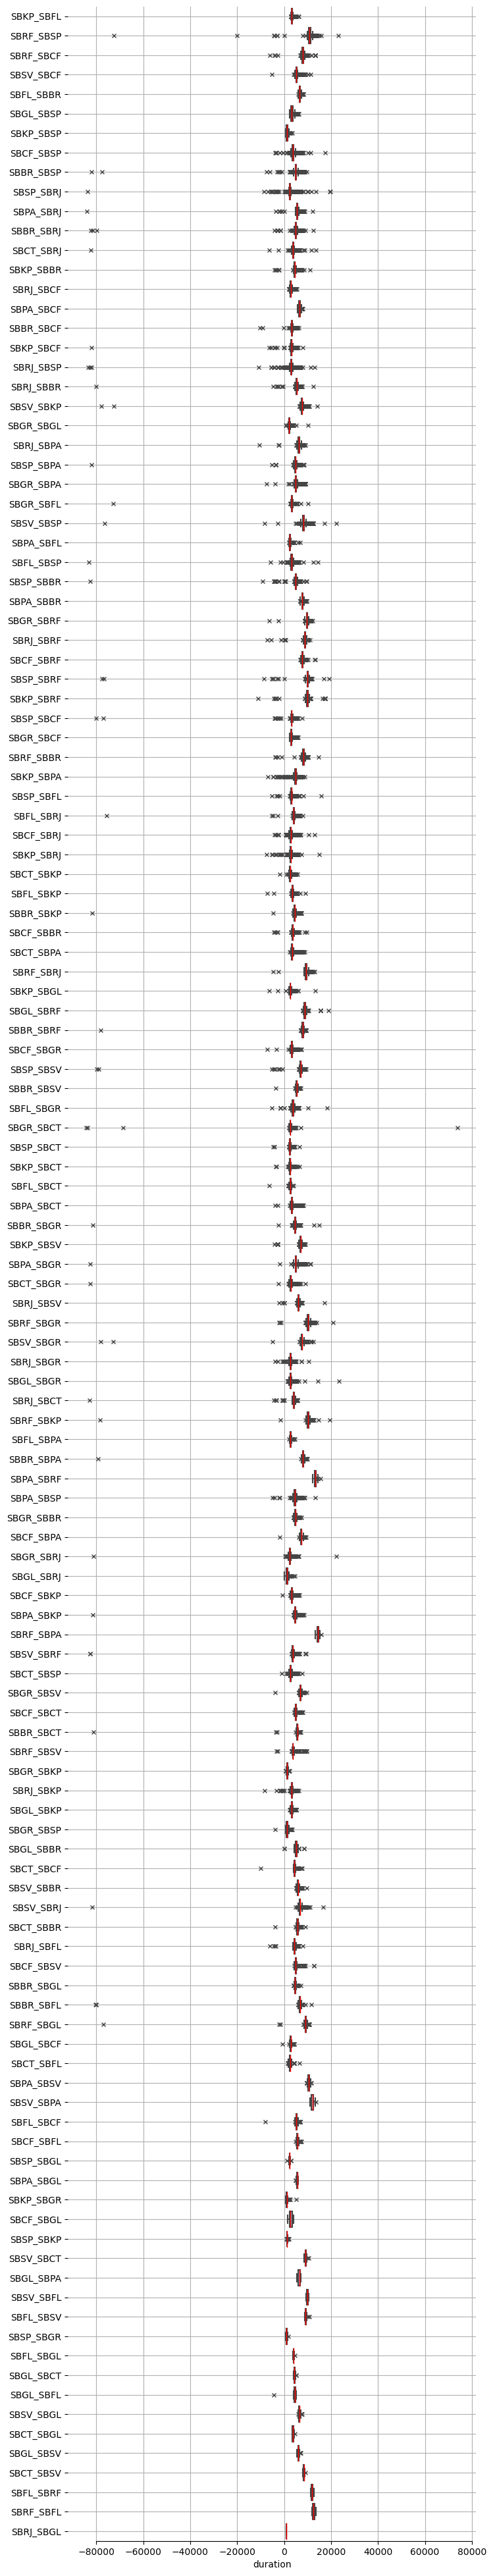

In [100]:
plot_duration_boxplot(aux_origin, "duration", "route")

In [101]:
del aux_origin

##### Drop outliers

In [102]:
aux_without_outlier = data_train_without_outlier.copy()
aux_without_outlier['route'] = aux_without_outlier['origem'] + '_' + aux_without_outlier['destino']

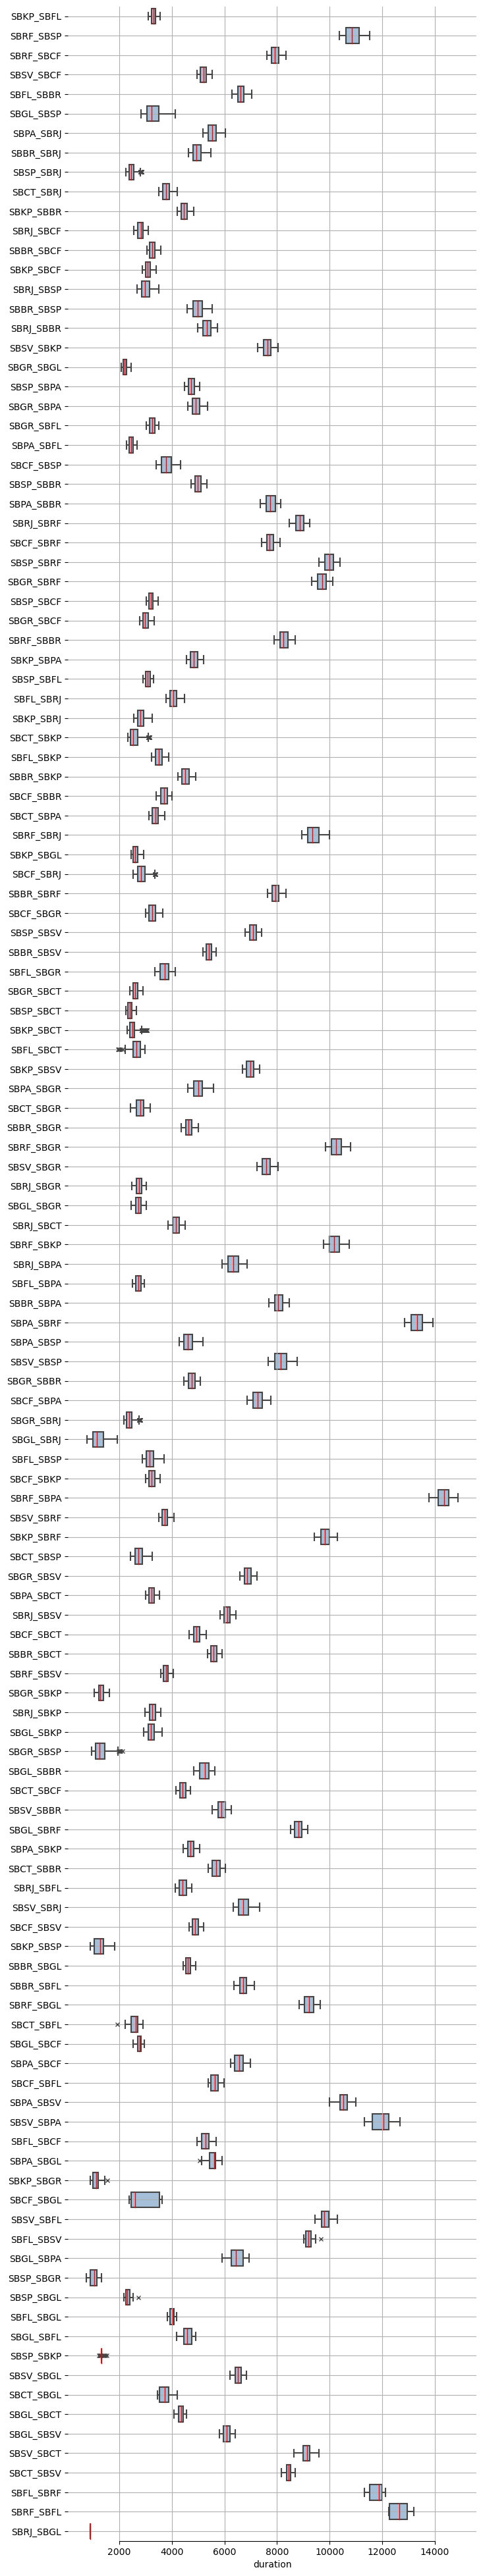

In [103]:
plot_duration_boxplot(aux_without_outlier, "duration", "route")

In [104]:
del aux_without_outlier

##### imputation of missing data

In [105]:
start = time()

step_a = preprocessor.named_steps['imputer'].fit_transform(X_train, y_train)

end = time()

In [106]:
print(f"Transforming Time: {(end-start)/60:.2f} minutes")

Transforming Time: 0.01 minutes


In [107]:
pd.DataFrame(step_a, columns = X_train.columns).sample(3)

,origem,destino,metar,hora_ref,path,snapshot_radar,troca,esperas
200509,SBCF,SBRJ,METAR SBRJ 282000Z 15004KT CAVOK 22/16 Q1016=,2022-06-28 20:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,"MULTIPOINT ((-0.7697162338 -0.3651749538), (-0...",1.0,0.0
153448,SBKP,SBCT,METAR SBCT 161800Z 28005KT 220V340 9999 BKN025...,2022-10-16 18:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,"MULTIPOINT ((-0.839530297 -0.4363025375), (-0....",0.0,0.0
164851,SBSP,SBRJ,METAR SBRJ 171200Z 19009KT 9999 -RA SCT018 BKN...,2022-12-17 12:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,"MULTIPOINT ((-0.762343621 -0.4017769289), (-0....",0.0,0.0


In [108]:
pd.DataFrame(step_a, columns = X_train.columns).isnull().sum()

origem            0
destino           0
metar             0
hora_ref          0
path              0
snapshot_radar    0
troca             0
esperas           0
dtype: int64

#### [↥ return to index](#index)

##### creation of the "estimated_duration" attribute (Feature Engineer)

In [109]:
start = time()

step_b = preprocessor.named_steps['feature_engineer'].named_steps['feat_eng_est_duration'].fit_transform(step_a, y_train)

end = time()

In [110]:
print(f"Transforming Time: {(end-start)/60:.2f} minutes")

Transforming Time: 1.86 minutes


In [111]:
step_b.sample(3)

,origem,destino,metar,hora_ref,path,snapshot_radar,troca,esperas,only_hour,estimated_duration
190100,SBCF,SBSV,METAR SBSV 310000Z 10010KT CAVOK 28/22 Q1013=,2023-01-31 00:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,"MULTIPOINT ((-0.711798644 -0.2794643204), (-0....",0.0,0.0,0,4927.541436
64600,SBKP,SBGL,METAR SBGL 082000Z 15006KT 9999 SCT021 BKN026 ...,2023-01-08 20:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,"MULTIPOINT ((-0.785022233 -0.4061756301), (-0....",0.0,0.0,20,2619.521739
23646,SBGR,SBPA,METAR SBPA 061400Z 08008KT 4000 -RA BR SCT005 ...,2022-10-06 14:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,"MULTIPOINT ((-0.8346833118 -0.4403078206), (-0...",1.0,0.0,14,4864.732955


In [112]:
step_b.columns

Index(['origem', 'destino', 'metar', 'hora_ref', 'path', 'snapshot_radar',
       'troca', 'esperas', 'only_hour', 'estimated_duration'],
      dtype='object')

#### [↥ return to index](#index)

##### creation of the "route_linearity" attribute (CAT-62 Feature Engineer)

In [113]:
start = time()

step_c = preprocessor.named_steps['feature_engineer'].named_steps['feat_eng_snapshot_radar'].fit_transform(step_b, y_train)

end = time()

In [114]:
print(f"Transforming Time: {(end-start)/60:.2f} minutes")

Transforming Time: 3.91 minutes


In [115]:
step_c.sample(3)

,origem,destino,metar,hora_ref,path,troca,esperas,only_hour,estimated_duration,route_linearity
66648,SBFL,SBSP,METAR SBSP 261400Z 10005KT 9999 FEW040 26/11 Q...,2023-01-26 14:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,0.0,0.0,14,3124.657895,0.910546
157093,SBGR,SBPA,METAR SBPA 160000Z 10007KT 9999 FEW008 BKN070 ...,2023-02-16 00:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,0.0,0.0,0,4944.369159,1.000000
152016,SBCT,SBBR,METAR SBBR 241400Z 32012G22KT 280V350 9999 SCT...,2023-01-24 14:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1.0,0.0,14,5618.562500,0.933909


In [116]:
step_c.columns

Index(['origem', 'destino', 'metar', 'hora_ref', 'path', 'troca', 'esperas',
       'only_hour', 'estimated_duration', 'route_linearity'],
      dtype='object')

#### [↥ return to index](#index)

##### creation of the "wind_variation", "qnh", "cavok", "gust" and "FEW_presenceCB" attribute (METAR Feature Engineer)

In [117]:
start = time()

step_d = preprocessor.named_steps['feature_engineer'].named_steps['feat_eng_metar'].fit_transform(step_c, y_train)

end = time()

In [118]:
print(f"Transforming Time: {(end-start)/60:.2f} minutes")

Transforming Time: 1.62 minutes


In [119]:
step_d.sample(3)

,origem,destino,hora_ref,path,troca,esperas,only_hour,estimated_duration,route_linearity,wind_variation,qnh,cavok,gust,FEW_presenceCB
77433,SBGR,SBRF,2023-05-01 11:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1.0,0.0,11,9694.767123,0.998152,0.0,1014.0,0.0,0.0,0.0
124931,SBSP,SBBR,2022-10-31 13:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1.0,0.0,13,4970.347619,0.927889,0.0,1018.0,0.0,0.0,0.0
11954,SBGR,SBPA,2022-12-11 20:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,0.0,0.0,20,4928.793814,0.997724,0.0,1003.0,0.0,0.0,0.0


In [120]:
step_d.columns

Index(['origem', 'destino', 'hora_ref', 'path', 'troca', 'esperas',
       'only_hour', 'estimated_duration', 'route_linearity', 'wind_variation',
       'qnh', 'cavok', 'gust', 'FEW_presenceCB'],
      dtype='object')

#### [↥ return to index](#index)

##### creation of the "imageSatelite_red", "imageSatelite_yellow", "imageSatelite_green" and "imageSatelite_blue" attribute (meteorological satellite Feature Engineer)

In [121]:
start = time()

step_e = preprocessor.named_steps['feature_engineer'].named_steps['feat_eng_satelliteImage'].fit_transform(step_d, y_train)

end = time()

In [122]:
print(f"Transforming Time: {(end-start)/60:.2f} minutes")

Transforming Time: 0.02 minutes


In [123]:
step_e.sample(3)

,origem,destino,troca,esperas,only_hour,estimated_duration,route_linearity,wind_variation,qnh,cavok,gust,FEW_presenceCB,imageSatelite_red,imageSatelite_yellow,imageSatelite_green,imageSatelite_blue
58245,SBGR,SBCT,0.0,0.0,21,2611.617647,0.923073,0.0,1025.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
40780,SBCF,SBBR,1.0,0.0,9,3749.898219,0.984624,1.0,1017.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
23724,SBPA,SBFL,0.0,0.0,1,2413.063492,0.983219,0.0,1017.0,0.0,0.0,0.0,0.0,0.0,0.296712,3.506429


In [124]:
step_e.columns

Index(['origem', 'destino', 'troca', 'esperas', 'only_hour',
       'estimated_duration', 'route_linearity', 'wind_variation', 'qnh',
       'cavok', 'gust', 'FEW_presenceCB', 'imageSatelite_red',
       'imageSatelite_yellow', 'imageSatelite_green', 'imageSatelite_blue'],
      dtype='object')

#### [↥ return to index](#index)

##### coding of categorical variables

In [125]:
start = time()

step_f = preprocessor.named_steps['coding_category_var'].fit_transform(step_e, y_train)

end = time()

In [126]:
print(f"Transforming Time: {(end-start)/60:.2f} minutes")

Transforming Time: 0.01 minutes


In [127]:
pd.DataFrame(step_f).sample(3)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
152890,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.937387,0.0,1005.0,0.0,0.0,0.0,0.079671,3.918376,14.574382,5.725098
182407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.997579,0.0,1008.0,0.0,0.0,0.0,0.0,0.0,1.07959,0.012451
128296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.921467,0.0,1019.0,1.0,0.0,0.0,0.0,0.155029,6.620036,6.236654


#### [↥ return to index](#index)

##### standardization of variables to the same scale (unit standard deviation and zero mean)

In [128]:
start = time()

_X_train = preprocessor.named_steps['transformer'].fit_transform(step_f, y_train)

end = time()

In [129]:
print(f"Transforming Time: {(end-start)/60:.2f} minutes")

Transforming Time: 0.01 minutes


In [130]:
pd.DataFrame(_X_train).sample(3)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
107230,-0.317971,-0.316445,-0.255337,-0.201914,-0.149869,-0.351662,-0.288763,3.530072,-0.246752,-0.393476,...,0.312002,-0.550352,0.776755,-0.586915,-0.083158,-0.132331,-0.275317,-0.383851,-0.553945,-0.552829
113539,-0.317971,-0.316445,-0.255337,-0.201914,-0.149869,-0.351662,-0.288763,-0.283280,-0.246752,-0.393476,...,0.565814,1.817018,-0.303165,-0.586915,-0.083158,-0.132331,-0.275317,-0.383851,-0.498392,-0.467321
139173,3.144940,-0.316445,-0.255337,-0.201914,-0.149869,-0.351662,-0.288763,-0.283280,-0.246752,-0.393476,...,-0.127445,-0.550352,-0.303165,-0.586915,-0.083158,-0.132331,2.374891,3.245110,1.892093,-0.093863


#### [↥ return to index](#index)

##### Validation set

In [131]:
start = time()

_X_valid = preprocessor.transform(X_valid)

end = time()

In [132]:
print(f"Transforming Time: {(end-start)/60:.2f} minutes")

Transforming Time: 1.82 minutes


#### [↥ return to index](#index)

<a id="data_test"></a>

### 1.3.4 Test Set

In [133]:
path_data_test = '../data/idsc_dataset.csv'

In [134]:
data_test = pd.read_csv(path_data_test, index_col = 'flightid', delimiter=';')

In [135]:
X_test = data_test[selected_cols].copy()

In [136]:
start = time()

_X_test = preprocessor.transform(X_test)

end = time()

In [137]:
print(f"Transforming Time: {(end-start)/60:.2f} minutes")

Transforming Time: 1.37 minutes


#### [↥ return to index](#index)

<a id="models"></a>

# 2 Models

<a id="models_dummy"></a>

## 2.1 Dummy Model

In [138]:
dummyModel = preprocessor.named_steps['feature_engineer'].named_steps['feat_eng_est_duration']._dammy_estimator

In [139]:
gethourFromDatetime = preprocessor.named_steps['feature_engineer'].named_steps['feat_eng_est_duration']._gethourFromDatetime

In [140]:
aux = X_test.copy().reset_index()

aux['route'] = aux['origem'] + '_' + aux['destino']
aux['estimated'] = None
aux['only_hour'] = aux.apply(lambda row: gethourFromDatetime(row), axis = 1)

<a id="models_dummy_inf"></a>

### 2.1.1  Inference

In [141]:
for index, row in aux.iterrows():
    try:
        mean_hour = dummyModel[(dummyModel['route'] == row['route']) & (dummyModel['only_hour'] == row['only_hour'])]['mean_hour']
        mean_absolute = dummyModel[(dummyModel['route'] == row['route'])].iloc[0, 3]
    except:
        mean_absolute = 0
    
    if(np.isnan(mean_hour).any()):
        aux.loc[index, 'estimated'] = mean_hour
    else:
        aux.loc[index, 'estimated'] = mean_absolute

<a id="models_dummy_sub"></a>

### 2.1.2 Submission

In [142]:
submission_dummy = aux[['flightid', 'estimated']]

In [143]:
submission_dummy.columns = ['ID', 'solution']

In [144]:
submission_dummy.head(5)

,ID,solution
0,4f0356600f61e3fcbea8ed8a137a2423,4985.129201
1,865dbbbe74bebea18a71f24342516ff0,2408.091019
2,1803af9cfc6a2c74d188481e3ffd848e,4933.070595
3,f6af733a687f904183efd149ec713be5,8428.1
4,6117f9ac60b7f66b740c9130be433313,2741.881898


In [145]:
submission_dummy.to_csv(f"../data/submission/idsc_submission_dummy{datetime.now().strftime('%d-%B-%Ih%Mmin')}.csv", index=False)

#### [↥ return to index](#index)

<a id="models_ann"></a>

## 2.2 Artificial Neural Network

In [146]:
def create_model(input_shape = (_X_train.shape[1],),
                 neuron_number = 128,
                 optimizer = 'adam',
                 checkpoint = None,
                 activation ='relu',
                 layers=1,
                 dropout=0
                ):
    
    """
    Constructs a neural network model with specified parameters.
    
    :param input_shape: tuple, shape of the input data. Default is (37,).
    :param neuron_number: int, number of neurons in the dense layer(s). Default is 128.
    :param optimizer: str, optimizer used in model compilation. Default is 'adam'.
    :param checkpoint: str, path to the model checkpoint to load weights from. If the path exists, the model will load the weights. Default is None.
    :param activation: str, activation function used in the dense layers. Default is 'relu'.
    :param layers: int, number of dense layers to be added before the output layer. Default is 1.
    :param dropout: float, dropout rate to be applied after the dense layers. Value should be between 0 (no dropout) and 1 (full dropout). Default is 0.
    
    :return: Sequential, a Keras Sequential model constructed based on the provided parameters.
    """

    model = Sequential()
    model.add(Input(shape=input_shape))
                    
    #################################################################
                    
    for _ in range(layers):
        model.add(Dense(neuron_number, activation=activation ))
        model.add(Dropout(dropout))
        
    #################################################################
                        
    model.add(Dense(neuron_number//2, activation=activation ))
    model.add(Dense(1, activation='linear' ))

    if(checkpoint != None) and (os.path.exists(checkpoint)):
        model.load_weights(checkpoint)
        
    model.compile(loss= MeanSquaredError(), optimizer=optimizer)

    return model

##### Callbacks

In [147]:
tensorboard = TensorBoard(
    log_dir=f"../logs/{datetime.now().strftime('%d-%B-%Ih%Mmin')}",
    histogram_freq=0,
    write_graph=False,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

checkpoint = ModelCheckpoint(
    '../model/checkpoints',
    monitor="val_loss",
    verbose=verbose,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch"
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=20,
    verbose=verbose,
    restore_best_weights=True
)

reduceLr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    mode="min",
    verbose=verbose,
    min_delta=0.0001,
    min_lr=0
)

BackAndRes = BackupAndRestore(
    backup_dir = '../tmp',
    save_freq="epoch",
    delete_checkpoint=True,
    save_before_preemption=False
)


callbacks = [
    checkpoint,
    earlystop,
    tensorboard,
    reduceLr,
    BackAndRes,
    TerminateOnNaN()
]

##### Wrapper Keras

In [148]:
create_model_params = {
    'checkpoint': None,
    'neuron_number': 128,
    'activation': 'relu',
    'model__layers': 3,
    'model__dropout': 0.05
}

In [149]:
# Wrap the model with KerasClassifier
ann_model = KerasRegressor(model=create_model, callbacks=callbacks, **create_model_params)

<a id="models_ann_pipe"></a>

### 2.2.1 Pipeline

In [150]:
ann_regressor = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', ann_model)
    ]
)

<a id="models_ann_train"></a>

### 2.2.2 Training

##### Parameters

In [151]:
ann_param_grid = {
    'model__batch_size': [32],
    'model__optimizer': [
        Adam(learning_rate=0.01),
        # RMSprop(learning_rate=0.01),
        # SGD(learning_rate=0.01),
        # Adamax(learning_rate=0.01),
        # Adadelta(learning_rate=0.01),
        # Adagrad(learning_rate=0.01)
    ]
}

2023-10-09 18:57:37.183081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-09 18:57:37.183434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-09 18:57:37.183547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-09 18:57:37.189338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-09 18:57:37.189459: I tensorflow/compile

In [152]:
ann_fit_params = {
    'model__epochs': ann_epochs,
    'model__verbose': verbose,
    'model__shuffle': True,
    'model__steps_per_epoch': None,
    'model__validation_data': (_X_valid, y_valid),
    'model__validation_steps': None,
    'model__validation_batch_size': None,
    'model__validation_freq': 1
}

##### Grid Search and Cross Validation

In [153]:
ann_gridSearch = GridSearchCV(
    estimator = ann_regressor,
    param_grid = ann_param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    refit=True,
    cv= fold_cross_validation,
    verbose=2#verbose
)

##### Fit

#### follow the training on Tensorboard
```
tensorboard --logdir logs
```

In [154]:
start = time()

ann_gridSearch.fit(X=X_train, y=y_train, **ann_fit_params)

end = time()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/1000


2023-10-09 19:03:35.371686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-09 19:03:35.437180: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6f0e4180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-09 19:03:35.437231: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-10-09 19:03:35.533119: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-09 19:03:35.987167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-09 19:03:36.339363: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-09 19:03:36.513253: I

5224/5224 [==============================] - ETA: 0s - loss: 435157.5625
Epoch 1: val_loss improved from inf to 42626.91406, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 55s 9ms/step - loss: 435157.5625 - val_loss: 42626.9141 - lr: 0.0010
Epoch 2/1000
5224/5224 [==============================] - ETA: 0s - loss: 86874.7891
Epoch 2: val_loss improved from 42626.91406 to 36811.84766, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 46s 9ms/step - loss: 86874.7891 - val_loss: 36811.8477 - lr: 0.0010
Epoch 3/1000
5219/5224 [============================>.] - ETA: 0s - loss: 82053.2500
Epoch 3: val_loss improved from 36811.84766 to 36547.07422, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 82050.0781 - val_loss: 36547.0742 - lr: 0.0010
Epoch 4/1000
5219/5224 [============================>.] - ETA: 0s - loss: 79569.6797
Epoch 4: val_loss improved from 36547.07422 to 35990.54297, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 43s 8ms/step - loss: 79582.1328 - val_loss: 35990.5430 - lr: 0.0010
Epoch 5/1000
5217/5224 [============================>.] - ETA: 0s - loss: 77424.2109
Epoch 5: val_loss did not improve from 35990.54297
5224/5224 [==============================] - 42s 8ms/step - loss: 77416.0859 - val_loss: 38069.1250 - lr: 0.0010
Epoch 6/1000
5223/5224 [============================>.] - ETA: 0s - loss: 75216.7266
Epoch 6: val_loss did not improve from 35990.54297
5224/5224 [==============================] - 45s 9ms/step - loss: 75224.3516 - val_loss: 106271.9062 - lr: 0.0010
Epoch 7/1000
5219/5224 [============================>.] - ETA: 0s - loss: 72806.3672
Epoch 7: val_loss did not improve from 35990.54297
5224/5224 [==============================] - 44s 8ms/step - loss: 72800.8828 - val_loss: 43790.7891 - lr: 0.0010
Epoch 8/1000
5223/5224 [============================>.] - ETA: 0s - loss: 70680.7969
Epoch 8: val_loss did not improve from 35990.54297
522

INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 9ms/step - loss: 69176.3047 - val_loss: 34190.5898 - lr: 0.0010
Epoch 10/1000
5224/5224 [==============================] - ETA: 0s - loss: 66754.0781
Epoch 10: val_loss did not improve from 34190.58984
5224/5224 [==============================] - 42s 8ms/step - loss: 66754.0781 - val_loss: 52080.1875 - lr: 0.0010
Epoch 11/1000
5218/5224 [============================>.] - ETA: 0s - loss: 62839.2852
Epoch 11: val_loss did not improve from 34190.58984
5224/5224 [==============================] - 42s 8ms/step - loss: 62835.1719 - val_loss: 37769.4297 - lr: 0.0010
Epoch 12/1000
5224/5224 [==============================] - ETA: 0s - loss: 60314.4922
Epoch 12: val_loss did not improve from 34190.58984
5224/5224 [==============================] - 43s 8ms/step - loss: 60314.4922 - val_loss: 69322.7188 - lr: 0.0010
Epoch 13/1000
5222/5224 [============================>.] - ETA: 0s - loss: 59041.5195
Epoch 13: val_loss did not improve from 34190.58

INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 57s 10ms/step - loss: 447701.7812 - val_loss: 41087.0508 - lr: 0.0010
Epoch 2/1000
5221/5224 [============================>.] - ETA: 0s - loss: 88459.0781
Epoch 2: val_loss did not improve from 41087.05078
5224/5224 [==============================] - 47s 9ms/step - loss: 88446.8984 - val_loss: 43238.1680 - lr: 0.0010
Epoch 3/1000
5222/5224 [============================>.] - ETA: 0s - loss: 82690.2578
Epoch 3: val_loss did not improve from 41087.05078
5224/5224 [==============================] - 55s 11ms/step - loss: 82687.5469 - val_loss: 41179.2930 - lr: 0.0010
Epoch 4/1000
5224/5224 [==============================] - ETA: 0s - loss: 79266.6094
Epoch 4: val_loss improved from 41087.05078 to 35549.04688, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 79266.6094 - val_loss: 35549.0469 - lr: 0.0010
Epoch 5/1000
5219/5224 [============================>.] - ETA: 0s - loss: 77254.2578
Epoch 5: val_loss improved from 35549.04688 to 34512.76562, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 52s 10ms/step - loss: 77248.1250 - val_loss: 34512.7656 - lr: 0.0010
Epoch 6/1000
5219/5224 [============================>.] - ETA: 0s - loss: 74905.5859
Epoch 6: val_loss did not improve from 34512.76562
5224/5224 [==============================] - 50s 10ms/step - loss: 74925.5391 - val_loss: 71924.5312 - lr: 0.0010
Epoch 7/1000
5224/5224 [==============================] - ETA: 0s - loss: 72458.1094
Epoch 7: val_loss did not improve from 34512.76562
5224/5224 [==============================] - 51s 10ms/step - loss: 72458.1094 - val_loss: 39899.2500 - lr: 0.0010
Epoch 8/1000
5222/5224 [============================>.] - ETA: 0s - loss: 69514.4531
Epoch 8: val_loss did not improve from 34512.76562
5224/5224 [==============================] - 50s 10ms/step - loss: 69522.7344 - val_loss: 48309.4062 - lr: 0.0010
Epoch 9/1000
5222/5224 [============================>.] - ETA: 0s - loss: 69021.6172
Epoch 9: val_loss improved from 34512.76562 to 3341

INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 54s 10ms/step - loss: 69020.0156 - val_loss: 33411.7656 - lr: 0.0010
Epoch 10/1000
5221/5224 [============================>.] - ETA: 0s - loss: 67274.1406
Epoch 10: val_loss did not improve from 33411.76562
5224/5224 [==============================] - 50s 10ms/step - loss: 67267.8203 - val_loss: 52674.4727 - lr: 0.0010
Epoch 11/1000
5223/5224 [============================>.] - ETA: 0s - loss: 64206.6680
Epoch 11: val_loss did not improve from 33411.76562
5224/5224 [==============================] - 49s 9ms/step - loss: 64210.7070 - val_loss: 46154.2461 - lr: 0.0010
Epoch 12/1000
5221/5224 [============================>.] - ETA: 0s - loss: 63703.9141
Epoch 12: val_loss did not improve from 33411.76562
5224/5224 [==============================] - 50s 10ms/step - loss: 63704.3750 - val_loss: 52835.1484 - lr: 0.0010
Epoch 13/1000
5220/5224 [============================>.] - ETA: 0s - loss: 60987.6367
Epoch 13: val_loss did not improve from 33411

INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 47s 9ms/step - loss: 440763.2500 - val_loss: 40719.1055 - lr: 0.0010
Epoch 2/1000
5224/5224 [==============================] - ETA: 0s - loss: 87412.1094
Epoch 2: val_loss improved from 40719.10547 to 38059.07812, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 43s 8ms/step - loss: 87412.1094 - val_loss: 38059.0781 - lr: 0.0010
Epoch 3/1000
5224/5224 [==============================] - ETA: 0s - loss: 81372.5469
Epoch 3: val_loss did not improve from 38059.07812
5224/5224 [==============================] - 44s 8ms/step - loss: 81372.5469 - val_loss: 50291.3281 - lr: 0.0010
Epoch 4/1000
5222/5224 [============================>.] - ETA: 0s - loss: 78396.9219
Epoch 4: val_loss improved from 38059.07812 to 35678.41016, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 78403.5625 - val_loss: 35678.4102 - lr: 0.0010
Epoch 5/1000
5224/5224 [==============================] - ETA: 0s - loss: 76623.3984
Epoch 5: val_loss improved from 35678.41016 to 35449.13281, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 46s 9ms/step - loss: 76623.3984 - val_loss: 35449.1328 - lr: 0.0010
Epoch 6/1000
5222/5224 [============================>.] - ETA: 0s - loss: 73664.6797
Epoch 6: val_loss did not improve from 35449.13281
5224/5224 [==============================] - 46s 9ms/step - loss: 73664.7656 - val_loss: 60422.9336 - lr: 0.0010
Epoch 7/1000
5224/5224 [==============================] - ETA: 0s - loss: 71705.7969
Epoch 7: val_loss improved from 35449.13281 to 33420.19922, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 71705.7969 - val_loss: 33420.1992 - lr: 0.0010
Epoch 8/1000
5223/5224 [============================>.] - ETA: 0s - loss: 69429.1094
Epoch 8: val_loss did not improve from 33420.19922
5224/5224 [==============================] - 43s 8ms/step - loss: 69436.8984 - val_loss: 54755.9883 - lr: 0.0010
Epoch 9/1000
5220/5224 [============================>.] - ETA: 0s - loss: 69957.1328
Epoch 9: val_loss improved from 33420.19922 to 32198.01953, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 69946.2500 - val_loss: 32198.0195 - lr: 0.0010
Epoch 10/1000
5221/5224 [============================>.] - ETA: 0s - loss: 66601.9297
Epoch 10: val_loss did not improve from 32198.01953
5224/5224 [==============================] - 43s 8ms/step - loss: 66587.2891 - val_loss: 57031.0078 - lr: 0.0010
Epoch 11/1000
5221/5224 [============================>.] - ETA: 0s - loss: 64196.0273
Epoch 11: val_loss did not improve from 32198.01953
5224/5224 [==============================] - 43s 8ms/step - loss: 64201.0898 - val_loss: 49730.4688 - lr: 0.0010
Epoch 12/1000
5222/5224 [============================>.] - ETA: 0s - loss: 63160.2852
Epoch 12: val_loss did not improve from 32198.01953
5224/5224 [==============================] - 45s 9ms/step - loss: 63162.5898 - val_loss: 55485.3906 - lr: 0.0010
Epoch 13/1000
5219/5224 [============================>.] - ETA: 0s - loss: 63707.4805
Epoch 13: val_loss did not improve from 32198.01

INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 46s 9ms/step - loss: 511169.0000 - val_loss: 47635.9688 - lr: 0.0010
Epoch 2/1000
5218/5224 [============================>.] - ETA: 0s - loss: 92622.1641
Epoch 2: val_loss improved from 47635.96875 to 37390.67969, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 92635.1172 - val_loss: 37390.6797 - lr: 0.0010
Epoch 3/1000
5218/5224 [============================>.] - ETA: 0s - loss: 85761.6484
Epoch 3: val_loss did not improve from 37390.67969
5224/5224 [==============================] - 43s 8ms/step - loss: 85747.3203 - val_loss: 50291.0312 - lr: 0.0010
Epoch 4/1000
5224/5224 [==============================] - ETA: 0s - loss: 80434.5312
Epoch 4: val_loss did not improve from 37390.67969
5224/5224 [==============================] - 44s 8ms/step - loss: 80434.5312 - val_loss: 37967.5273 - lr: 0.0010
Epoch 5/1000
5224/5224 [==============================] - ETA: 0s - loss: 78270.1719
Epoch 5: val_loss improved from 37390.67969 to 33025.37500, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 78270.1719 - val_loss: 33025.3750 - lr: 0.0010
Epoch 6/1000
5220/5224 [============================>.] - ETA: 0s - loss: 74997.2656
Epoch 6: val_loss improved from 33025.37500 to 32171.70508, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 75013.4688 - val_loss: 32171.7051 - lr: 0.0010
Epoch 7/1000
5219/5224 [============================>.] - ETA: 0s - loss: 71206.2656
Epoch 7: val_loss did not improve from 32171.70508
5224/5224 [==============================] - 44s 8ms/step - loss: 71195.5547 - val_loss: 40432.5977 - lr: 0.0010
Epoch 8/1000
5217/5224 [============================>.] - ETA: 0s - loss: 66366.2969
Epoch 8: val_loss did not improve from 32171.70508
5224/5224 [==============================] - 43s 8ms/step - loss: 66348.0469 - val_loss: 59597.2227 - lr: 0.0010
Epoch 9/1000
5222/5224 [============================>.] - ETA: 0s - loss: 62257.6680
Epoch 9: val_loss did not improve from 32171.70508
5224/5224 [==============================] - 43s 8ms/step - loss: 62252.8281 - val_loss: 86894.4688 - lr: 0.0010
Epoch 10/1000
5218/5224 [============================>.] - ETA: 0s - loss: 59457.3477
Epoch 10: val_loss did not improve from 32171.70508
52

INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 45s 8ms/step - loss: 563454.8125 - val_loss: 52607.0430 - lr: 0.0010
Epoch 2/1000
5224/5224 [==============================] - ETA: 0s - loss: 95669.5078
Epoch 2: val_loss improved from 52607.04297 to 39798.77734, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 95669.5078 - val_loss: 39798.7773 - lr: 0.0010
Epoch 3/1000
5224/5224 [==============================] - ETA: 0s - loss: 87980.6406
Epoch 3: val_loss improved from 39798.77734 to 34504.57422, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 87980.6406 - val_loss: 34504.5742 - lr: 0.0010
Epoch 4/1000
5219/5224 [============================>.] - ETA: 0s - loss: 81973.3281
Epoch 4: val_loss did not improve from 34504.57422
5224/5224 [==============================] - 43s 8ms/step - loss: 81966.9609 - val_loss: 34720.4492 - lr: 0.0010
Epoch 5/1000
5223/5224 [============================>.] - ETA: 0s - loss: 79031.7109
Epoch 5: val_loss improved from 34504.57422 to 33634.05078, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


5224/5224 [==============================] - 44s 8ms/step - loss: 79031.3750 - val_loss: 33634.0508 - lr: 0.0010
Epoch 6/1000
5219/5224 [============================>.] - ETA: 0s - loss: 76724.6250
Epoch 6: val_loss did not improve from 33634.05078
5224/5224 [==============================] - 44s 9ms/step - loss: 76734.5547 - val_loss: 47364.7617 - lr: 0.0010
Epoch 7/1000
5224/5224 [==============================] - ETA: 0s - loss: 73258.3125
Epoch 7: val_loss did not improve from 33634.05078
5224/5224 [==============================] - 48s 9ms/step - loss: 73258.3125 - val_loss: 45968.8203 - lr: 0.0010
Epoch 8/1000
5221/5224 [============================>.] - ETA: 0s - loss: 70059.0391
Epoch 8: val_loss did not improve from 33634.05078
5224/5224 [==============================] - 47s 9ms/step - loss: 70048.7500 - val_loss: 48652.9883 - lr: 0.0010
Epoch 9/1000
5224/5224 [==============================] - ETA: 0s - loss: 66050.5625
Epoch 9: val_loss did not improve from 33634.05078
5224

INFO:tensorflow:Assets written to: ../model/checkpoints/assets


6530/6530 [==============================] - 71s 11ms/step - loss: 447258.0625 - val_loss: 56261.4492 - lr: 0.0010
Epoch 2/1000
6528/6530 [============================>.] - ETA: 0s - loss: 95593.0000
Epoch 2: val_loss improved from 56261.44922 to 36051.32812, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


6530/6530 [==============================] - 59s 9ms/step - loss: 95594.2422 - val_loss: 36051.3281 - lr: 0.0010
Epoch 3/1000
6527/6530 [============================>.] - ETA: 0s - loss: 86166.3359
Epoch 3: val_loss improved from 36051.32812 to 35519.12500, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


6530/6530 [==============================] - 58s 9ms/step - loss: 86169.1641 - val_loss: 35519.1250 - lr: 0.0010
Epoch 4/1000
6530/6530 [==============================] - ETA: 0s - loss: 81633.2734
Epoch 4: val_loss improved from 35519.12500 to 35429.78906, saving model to ../model/checkpoints
INFO:tensorflow:Assets written to: ../model/checkpoints/assets


INFO:tensorflow:Assets written to: ../model/checkpoints/assets


6530/6530 [==============================] - 61s 9ms/step - loss: 81633.2734 - val_loss: 35429.7891 - lr: 0.0010
Epoch 5/1000
6530/6530 [==============================] - ETA: 0s - loss: 79341.7578
Epoch 5: val_loss did not improve from 35429.78906
6530/6530 [==============================] - 60s 9ms/step - loss: 79341.7578 - val_loss: 67472.1328 - lr: 0.0010
Epoch 6/1000
6523/6530 [============================>.] - ETA: 0s - loss: 76464.6641
Epoch 6: val_loss did not improve from 35429.78906
6530/6530 [==============================] - 55s 8ms/step - loss: 76465.8203 - val_loss: 37307.5039 - lr: 0.0010
Epoch 7/1000
6524/6530 [============================>.] - ETA: 0s - loss: 72276.9062
Epoch 7: val_loss did not improve from 35429.78906
6530/6530 [==============================] - 57s 9ms/step - loss: 72286.1719 - val_loss: 56665.4922 - lr: 0.0010
Epoch 8/1000
6525/6530 [============================>.] - ETA: 0s - loss: 66212.5625
Epoch 8: val_loss did not improve from 35429.78906
6530

In [155]:
print(f"Training Time: {(end-start)/60:.2f} minutes")

Training Time: 195.31 minutes


<a id="models_ann_res"></a>

### 2.2.3 Result

In [156]:
pd.DataFrame(ann_gridSearch.cv_results_)[[
    'rank_test_score', 'param_model__batch_size', 'param_model__optimizer',
    'mean_test_score', 'std_test_score', 'mean_fit_time'
]].sort_values(by='rank_test_score').set_index('rank_test_score')

,param_model__batch_size,param_model__optimizer,mean_test_score,std_test_score,mean_fit_time
rank_test_score,,,,,
1,32,<keras.src.optimizers.adam.Adam object at 0x7f...,-33342.001561,704.845821,1857.118545


##### Best model

In [157]:
ann_best_model = ann_gridSearch.best_estimator_

##### Save and restore best model

In [158]:
# dump(ann_best_model, '../model/ann_best_model.pkl')

In [159]:
# ann_best_model = load('../model/ann_best_model.pkl')

#### [↥ return to index](#index)

<a id="models_xgb"></a>

## 2.3 Xgboost

In [160]:
xgb_model = XGBRegressor(
    tree_method= 'hist',
    device="cuda",
    objective='reg:squarederror',
    eval_metric=mean_squared_error,
    early_stopping_rounds=100,
    verbosity = verbose
)

<a id="models_xgb_pipe"></a>

### 2.3.1 Pipeline

In [161]:
xgb_regressor = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('xgb', xgb_model)
    ]
)

<a id="models_xgb_train"></a>

### 2.3.2 Training

##### Parameters

In [162]:
xgb_param_grid = {
    'xgb__booster': ['gbtree'], # 'gbtree', 'dart', 'gblinear'
    'xgb__n_estimators': [xgb_estimators], # normalmente entre 50 e 1000
    
    ##### Parâmetros para Tree Booster (booster = gbtree) ##########
       
    'xgb__learning_rate': [0.1], # de 0 a 1
    'xgb__gamma': [0],
    'xgb__max_depth': [5],
    'xgb__min_child_weight': [5], # 1
    'xgb__max_delta_step': [0],
    'xgb__subsample': [1],
    'xgb__sampling_method': ['uniform'], # 'uniform', 'gradient_based', 
    'xgb__colsample_bytree': [1], # de 0 a 1
    'xgb__colsample_bylevel': [1], # de 0 a 1
    'xgb__colsample_bynode': [1], # de 0 a 1
    'xgb__scale_pos_weight': [1],
    'xgb__grow_policy': ['depthwise'], # 'depthwise', 'lossguide'
    'xgb__max_leaves': [0],
    'xgb__max_bin': [256],
    'xgb__num_parallel_tree': [1],
    'xgb__refresh_leaf': [1],
    
    #################################################################
    
    # Parâmetros para Dart Booster (booster = dart) #################
    
    'xgb__sample_type': ['uniform'], # 'uniform', 'weighted'
    'xgb__normalize_type': ['tree'], # 'tree', 'forest'
    'xgb__rate_drop': [0], # de 0 a 1
    'xgb__one_drop': [0], 
    'xgb__skip_drop': [0],
    
    #################################################################
    
    # Parâmetros para Linear Booster (booster = gblinear) ###########

    'xgb__feature_selector': ['cyclic'], # 'cyclic', 'shuffle', 'random', 'greedy', 'thrifty',  
    'xgb__top_k': [0]
    
    #################################################################   
}

In [163]:
xgb_fit_params = {
    'xgb__eval_set': [(_X_valid, y_valid)]
}

##### Grid Search and Cross Validation

In [164]:
xgb_gridSearch = GridSearchCV(
    estimator = xgb_regressor,
    param_grid = xgb_param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    refit=True,
    cv=fold_cross_validation,
    verbose=verbose
)

##### Fit

In [165]:
start = time()

xgb_gridSearch.fit(X=X_train, y=y_train, **xgb_fit_params)

end = time()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/lucas/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:19:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "feature_selector", "normalize_type", "one_drop", "rate_drop", "sample_type", "skip_drop", "top_k" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1980.28618	validation_0-mean_squared_error:3921533.25000
[1]	validation_0-rmse:1777.82599	validation_0-mean_squared_error:3160664.75000
[2]	validation_0-rmse:1596.05483	validation_0-mean_squared_error:2547391.00000
[3]	validation_0-rmse:1433.14893	validation_0-mean_squared_error:2053915.75000
[4]	validation_0-rmse:1291.04888	validation_0-mean_squared_error:1666807.25000
[5]	validation_0-rmse:1163.74752	validation_0-mean_squared_error:1354308.25000
[6]	validation_0-rmse:1049.52064	validation_0-mean_squared_error:1101493.62500
[7]	validation_0-rmse:947.20634	validation_0-mean_squared_error:897199.81250
[8]	validation_0-rmse:853.26559	validation_0-mean_squared_error:728062.12500
[9]	validation_0-rmse:771.43948	validation_0-mean_squared_error:595118.87500
[10]	validation_0-rmse:696.52090	validation_0-mean_squared_error:485141.40625
[11]	validation_0-rmse:630.08254	validation_0-mean_squared_error:397004.00000
[12]	validation_0-rmse:571.76328	validation_0-mean_squared_e

[107]	validation_0-rmse:226.09146	validation_0-mean_squared_error:51117.34766
[108]	validation_0-rmse:226.09552	validation_0-mean_squared_error:51119.19141
[109]	validation_0-rmse:226.10017	validation_0-mean_squared_error:51121.28516
[110]	validation_0-rmse:226.05527	validation_0-mean_squared_error:51100.98438
[111]	validation_0-rmse:226.04869	validation_0-mean_squared_error:51098.01562
[112]	validation_0-rmse:226.06587	validation_0-mean_squared_error:51105.77734
[113]	validation_0-rmse:226.06465	validation_0-mean_squared_error:51105.23047
[114]	validation_0-rmse:226.07291	validation_0-mean_squared_error:51108.96484
[115]	validation_0-rmse:226.06477	validation_0-mean_squared_error:51105.27734
[116]	validation_0-rmse:226.07153	validation_0-mean_squared_error:51108.33203
[117]	validation_0-rmse:226.06771	validation_0-mean_squared_error:51106.61328
[118]	validation_0-rmse:226.07794	validation_0-mean_squared_error:51111.23828
[119]	validation_0-rmse:226.08156	validation_0-mean_squared_erro

/home/lucas/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:20:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/lucas/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:27:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "feature_selector", "normalize_type", "one_drop", "rate_drop", "sample_type", "skip_drop", "top_k" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1980.74088	validation_0-mean_squared_error:3923334.25000
[1]	validation_0-rmse:1785.44277	validation_0-mean_squared_error:3187806.00000
[2]	validation_0-rmse:1609.26875	validation_0-mean_squared_error:2589746.00000
[3]	validation_0-rmse:1451.40822	validation_0-mean_squared_error:2106586.00000
[4]	validation_0-rmse:1309.35546	validation_0-mean_squared_error:1714411.62500
[5]	validation_0-rmse:1181.64306	validation_0-mean_squared_error:1396280.50000
[6]	validation_0-rmse:1067.04218	validation_0-mean_squared_error:1138578.87500
[7]	validation_0-rmse:963.97489	validation_0-mean_squared_error:929247.50000
[8]	validation_0-rmse:871.72115	validation_0-mean_squared_error:759897.81250
[9]	validation_0-rmse:789.11755	validation_0-mean_squared_error:622706.56250
[10]	validation_0-rmse:715.05783	validation_0-mean_squared_error:511307.68750
[11]	validation_0-rmse:648.75815	validation_0-mean_squared_error:420887.12500
[12]	validation_0-rmse:589.57518	validation_0-mean_squared_e

[107]	validation_0-rmse:176.02274	validation_0-mean_squared_error:30984.00195
[108]	validation_0-rmse:176.01059	validation_0-mean_squared_error:30979.72461
[109]	validation_0-rmse:176.00817	validation_0-mean_squared_error:30978.87695
[110]	validation_0-rmse:175.98034	validation_0-mean_squared_error:30969.07812
[111]	validation_0-rmse:175.97452	validation_0-mean_squared_error:30967.02930
[112]	validation_0-rmse:175.95653	validation_0-mean_squared_error:30960.69727
[113]	validation_0-rmse:175.93829	validation_0-mean_squared_error:30954.28516
[114]	validation_0-rmse:175.92249	validation_0-mean_squared_error:30948.72266
[115]	validation_0-rmse:175.87933	validation_0-mean_squared_error:30933.53906
[116]	validation_0-rmse:175.83570	validation_0-mean_squared_error:30918.19336
[117]	validation_0-rmse:175.80941	validation_0-mean_squared_error:30908.94727
[118]	validation_0-rmse:175.80009	validation_0-mean_squared_error:30905.67383
[119]	validation_0-rmse:175.78141	validation_0-mean_squared_erro

[213]	validation_0-rmse:174.57398	validation_0-mean_squared_error:30476.07617
[214]	validation_0-rmse:174.56312	validation_0-mean_squared_error:30472.28516
[215]	validation_0-rmse:174.54986	validation_0-mean_squared_error:30467.65430
[216]	validation_0-rmse:174.52771	validation_0-mean_squared_error:30459.91992
[217]	validation_0-rmse:174.52218	validation_0-mean_squared_error:30457.99219
[218]	validation_0-rmse:174.52255	validation_0-mean_squared_error:30458.11914
[219]	validation_0-rmse:174.51657	validation_0-mean_squared_error:30456.03320
[220]	validation_0-rmse:174.49460	validation_0-mean_squared_error:30448.36133
[221]	validation_0-rmse:174.49112	validation_0-mean_squared_error:30447.15430
[222]	validation_0-rmse:174.47747	validation_0-mean_squared_error:30442.38867
[223]	validation_0-rmse:174.46257	validation_0-mean_squared_error:30437.18750
[224]	validation_0-rmse:174.44936	validation_0-mean_squared_error:30432.57812
[225]	validation_0-rmse:174.44465	validation_0-mean_squared_erro

[319]	validation_0-rmse:173.73799	validation_0-mean_squared_error:30184.88867
[320]	validation_0-rmse:173.73433	validation_0-mean_squared_error:30183.61719
[321]	validation_0-rmse:173.73707	validation_0-mean_squared_error:30184.56641
[322]	validation_0-rmse:173.72787	validation_0-mean_squared_error:30181.37109
[323]	validation_0-rmse:173.72217	validation_0-mean_squared_error:30179.39258
[324]	validation_0-rmse:173.72046	validation_0-mean_squared_error:30178.79883
[325]	validation_0-rmse:173.70904	validation_0-mean_squared_error:30174.82617
[326]	validation_0-rmse:173.70724	validation_0-mean_squared_error:30174.20508
[327]	validation_0-rmse:173.70840	validation_0-mean_squared_error:30174.60547
[328]	validation_0-rmse:173.70501	validation_0-mean_squared_error:30173.42969
[329]	validation_0-rmse:173.70411	validation_0-mean_squared_error:30173.11914
[330]	validation_0-rmse:173.70300	validation_0-mean_squared_error:30172.72852
[331]	validation_0-rmse:173.70260	validation_0-mean_squared_erro

[425]	validation_0-rmse:173.17547	validation_0-mean_squared_error:29989.74219
[426]	validation_0-rmse:173.16943	validation_0-mean_squared_error:29987.64844
[427]	validation_0-rmse:173.16086	validation_0-mean_squared_error:29984.68359
[428]	validation_0-rmse:173.14905	validation_0-mean_squared_error:29980.59375
[429]	validation_0-rmse:173.14705	validation_0-mean_squared_error:29979.90039
[430]	validation_0-rmse:173.14135	validation_0-mean_squared_error:29977.92578
[431]	validation_0-rmse:173.11980	validation_0-mean_squared_error:29970.46680
[432]	validation_0-rmse:173.11350	validation_0-mean_squared_error:29968.28320
[433]	validation_0-rmse:173.11326	validation_0-mean_squared_error:29968.20117
[434]	validation_0-rmse:173.10842	validation_0-mean_squared_error:29966.52539
[435]	validation_0-rmse:173.10758	validation_0-mean_squared_error:29966.23438
[436]	validation_0-rmse:173.09013	validation_0-mean_squared_error:29960.19336
[437]	validation_0-rmse:173.08527	validation_0-mean_squared_erro

[531]	validation_0-rmse:172.73528	validation_0-mean_squared_error:29837.47656
[532]	validation_0-rmse:172.72201	validation_0-mean_squared_error:29832.89258
[533]	validation_0-rmse:172.72124	validation_0-mean_squared_error:29832.62695
[534]	validation_0-rmse:172.72085	validation_0-mean_squared_error:29832.49023
[535]	validation_0-rmse:172.72082	validation_0-mean_squared_error:29832.48242
[536]	validation_0-rmse:172.71725	validation_0-mean_squared_error:29831.25000
[537]	validation_0-rmse:172.71750	validation_0-mean_squared_error:29831.33398
[538]	validation_0-rmse:172.70857	validation_0-mean_squared_error:29828.25195
[539]	validation_0-rmse:172.70291	validation_0-mean_squared_error:29826.29883
[540]	validation_0-rmse:172.70407	validation_0-mean_squared_error:29826.69531
[541]	validation_0-rmse:172.70306	validation_0-mean_squared_error:29826.34766
[542]	validation_0-rmse:172.70036	validation_0-mean_squared_error:29825.41602
[543]	validation_0-rmse:172.69479	validation_0-mean_squared_erro

[637]	validation_0-rmse:172.48444	validation_0-mean_squared_error:29750.88086
[638]	validation_0-rmse:172.48328	validation_0-mean_squared_error:29750.47852
[639]	validation_0-rmse:172.48109	validation_0-mean_squared_error:29749.72656
[640]	validation_0-rmse:172.47461	validation_0-mean_squared_error:29747.49023
[641]	validation_0-rmse:172.46865	validation_0-mean_squared_error:29745.43945
[642]	validation_0-rmse:172.47024	validation_0-mean_squared_error:29745.98242
[643]	validation_0-rmse:172.46566	validation_0-mean_squared_error:29744.40625
[644]	validation_0-rmse:172.46243	validation_0-mean_squared_error:29743.28906
[645]	validation_0-rmse:172.45755	validation_0-mean_squared_error:29741.60352
[646]	validation_0-rmse:172.45690	validation_0-mean_squared_error:29741.38086
[647]	validation_0-rmse:172.45849	validation_0-mean_squared_error:29741.92969
[648]	validation_0-rmse:172.46248	validation_0-mean_squared_error:29743.30664
[649]	validation_0-rmse:172.46262	validation_0-mean_squared_erro

[743]	validation_0-rmse:172.18931	validation_0-mean_squared_error:29649.15820
[744]	validation_0-rmse:172.18999	validation_0-mean_squared_error:29649.39062
[745]	validation_0-rmse:172.18536	validation_0-mean_squared_error:29647.79688
[746]	validation_0-rmse:172.18095	validation_0-mean_squared_error:29646.27734
[747]	validation_0-rmse:172.17676	validation_0-mean_squared_error:29644.83398
[748]	validation_0-rmse:172.17904	validation_0-mean_squared_error:29645.62109
[749]	validation_0-rmse:172.17907	validation_0-mean_squared_error:29645.63281
[750]	validation_0-rmse:172.17657	validation_0-mean_squared_error:29644.76953
[751]	validation_0-rmse:172.17383	validation_0-mean_squared_error:29643.82617
[752]	validation_0-rmse:172.16869	validation_0-mean_squared_error:29642.05664
[753]	validation_0-rmse:172.16935	validation_0-mean_squared_error:29642.28711
[754]	validation_0-rmse:172.16670	validation_0-mean_squared_error:29641.37109
[755]	validation_0-rmse:172.16580	validation_0-mean_squared_erro

[849]	validation_0-rmse:171.97196	validation_0-mean_squared_error:29574.35547
[850]	validation_0-rmse:171.97233	validation_0-mean_squared_error:29574.48438
[851]	validation_0-rmse:171.97408	validation_0-mean_squared_error:29575.08398
[852]	validation_0-rmse:171.97518	validation_0-mean_squared_error:29575.45898
[853]	validation_0-rmse:171.97358	validation_0-mean_squared_error:29574.91406
[854]	validation_0-rmse:171.96862	validation_0-mean_squared_error:29573.20508
[855]	validation_0-rmse:171.96325	validation_0-mean_squared_error:29571.35938
[856]	validation_0-rmse:171.96400	validation_0-mean_squared_error:29571.61914
[857]	validation_0-rmse:171.95874	validation_0-mean_squared_error:29569.81055
[858]	validation_0-rmse:171.95488	validation_0-mean_squared_error:29568.48242
[859]	validation_0-rmse:171.95053	validation_0-mean_squared_error:29566.98242
[860]	validation_0-rmse:171.94731	validation_0-mean_squared_error:29565.87891
[861]	validation_0-rmse:171.94650	validation_0-mean_squared_erro

[955]	validation_0-rmse:171.73084	validation_0-mean_squared_error:29491.48242
[956]	validation_0-rmse:171.72860	validation_0-mean_squared_error:29490.71289
[957]	validation_0-rmse:171.72673	validation_0-mean_squared_error:29490.07031
[958]	validation_0-rmse:171.72516	validation_0-mean_squared_error:29489.53125
[959]	validation_0-rmse:171.72457	validation_0-mean_squared_error:29489.33008
[960]	validation_0-rmse:171.72624	validation_0-mean_squared_error:29489.89844
[961]	validation_0-rmse:171.72215	validation_0-mean_squared_error:29488.49805
[962]	validation_0-rmse:171.71416	validation_0-mean_squared_error:29485.75000
[963]	validation_0-rmse:171.71232	validation_0-mean_squared_error:29485.12109
[964]	validation_0-rmse:171.71145	validation_0-mean_squared_error:29484.82227
[965]	validation_0-rmse:171.71125	validation_0-mean_squared_error:29484.75391
[966]	validation_0-rmse:171.71196	validation_0-mean_squared_error:29484.99609
[967]	validation_0-rmse:171.70664	validation_0-mean_squared_erro

[1060]	validation_0-rmse:171.58141	validation_0-mean_squared_error:29440.17969
[1061]	validation_0-rmse:171.57941	validation_0-mean_squared_error:29439.49219
[1062]	validation_0-rmse:171.57428	validation_0-mean_squared_error:29437.73047
[1063]	validation_0-rmse:171.57003	validation_0-mean_squared_error:29436.28125
[1064]	validation_0-rmse:171.56969	validation_0-mean_squared_error:29436.15820
[1065]	validation_0-rmse:171.56627	validation_0-mean_squared_error:29434.98633
[1066]	validation_0-rmse:171.56656	validation_0-mean_squared_error:29435.08203
[1067]	validation_0-rmse:171.56562	validation_0-mean_squared_error:29434.76172
[1068]	validation_0-rmse:171.56567	validation_0-mean_squared_error:29434.77734
[1069]	validation_0-rmse:171.56525	validation_0-mean_squared_error:29434.63281
[1070]	validation_0-rmse:171.56292	validation_0-mean_squared_error:29433.83398
[1071]	validation_0-rmse:171.56051	validation_0-mean_squared_error:29433.00586
[1072]	validation_0-rmse:171.56549	validation_0-mean

[1164]	validation_0-rmse:171.51040	validation_0-mean_squared_error:29415.81445
[1165]	validation_0-rmse:171.50641	validation_0-mean_squared_error:29414.44922
[1166]	validation_0-rmse:171.50121	validation_0-mean_squared_error:29412.66602
[1167]	validation_0-rmse:171.49987	validation_0-mean_squared_error:29412.20703
[1168]	validation_0-rmse:171.49645	validation_0-mean_squared_error:29411.03125
[1169]	validation_0-rmse:171.49733	validation_0-mean_squared_error:29411.33594
[1170]	validation_0-rmse:171.49636	validation_0-mean_squared_error:29411.00195
[1171]	validation_0-rmse:171.49504	validation_0-mean_squared_error:29410.55078
[1172]	validation_0-rmse:171.49702	validation_0-mean_squared_error:29411.23047
[1173]	validation_0-rmse:171.49568	validation_0-mean_squared_error:29410.76758
[1174]	validation_0-rmse:171.49609	validation_0-mean_squared_error:29410.91016
[1175]	validation_0-rmse:171.49483	validation_0-mean_squared_error:29410.47852
[1176]	validation_0-rmse:171.49328	validation_0-mean

[1268]	validation_0-rmse:171.38809	validation_0-mean_squared_error:29373.87695
[1269]	validation_0-rmse:171.38338	validation_0-mean_squared_error:29372.26172
[1270]	validation_0-rmse:171.37195	validation_0-mean_squared_error:29368.34570
[1271]	validation_0-rmse:171.37582	validation_0-mean_squared_error:29369.67188
[1272]	validation_0-rmse:171.37315	validation_0-mean_squared_error:29368.75586
[1273]	validation_0-rmse:171.37287	validation_0-mean_squared_error:29368.66016
[1274]	validation_0-rmse:171.37168	validation_0-mean_squared_error:29368.25391
[1275]	validation_0-rmse:171.37043	validation_0-mean_squared_error:29367.82422
[1276]	validation_0-rmse:171.37089	validation_0-mean_squared_error:29367.98047
[1277]	validation_0-rmse:171.36525	validation_0-mean_squared_error:29366.05273
[1278]	validation_0-rmse:171.36199	validation_0-mean_squared_error:29364.93359
[1279]	validation_0-rmse:171.36264	validation_0-mean_squared_error:29365.15430
[1280]	validation_0-rmse:171.36068	validation_0-mean

[1372]	validation_0-rmse:171.20893	validation_0-mean_squared_error:29312.50000
[1373]	validation_0-rmse:171.20918	validation_0-mean_squared_error:29312.58008
[1374]	validation_0-rmse:171.20822	validation_0-mean_squared_error:29312.25391
[1375]	validation_0-rmse:171.20706	validation_0-mean_squared_error:29311.85938
[1376]	validation_0-rmse:171.20776	validation_0-mean_squared_error:29312.09570
[1377]	validation_0-rmse:171.20390	validation_0-mean_squared_error:29310.77539
[1378]	validation_0-rmse:171.20654	validation_0-mean_squared_error:29311.67969
[1379]	validation_0-rmse:171.19947	validation_0-mean_squared_error:29309.25781
[1380]	validation_0-rmse:171.19832	validation_0-mean_squared_error:29308.86328
[1381]	validation_0-rmse:171.19885	validation_0-mean_squared_error:29309.04688
[1382]	validation_0-rmse:171.19504	validation_0-mean_squared_error:29307.74219
[1383]	validation_0-rmse:171.19452	validation_0-mean_squared_error:29307.56641
[1384]	validation_0-rmse:171.19667	validation_0-mean

[1476]	validation_0-rmse:171.11366	validation_0-mean_squared_error:29279.88477
[1477]	validation_0-rmse:171.11194	validation_0-mean_squared_error:29279.30078
[1478]	validation_0-rmse:171.11134	validation_0-mean_squared_error:29279.09180
[1479]	validation_0-rmse:171.11182	validation_0-mean_squared_error:29279.25586
[1480]	validation_0-rmse:171.11189	validation_0-mean_squared_error:29279.27734
[1481]	validation_0-rmse:171.10940	validation_0-mean_squared_error:29278.42773
[1482]	validation_0-rmse:171.10563	validation_0-mean_squared_error:29277.13281
[1483]	validation_0-rmse:171.10604	validation_0-mean_squared_error:29277.27539
[1484]	validation_0-rmse:171.10650	validation_0-mean_squared_error:29277.43555
[1485]	validation_0-rmse:171.10712	validation_0-mean_squared_error:29277.64844
[1486]	validation_0-rmse:171.10636	validation_0-mean_squared_error:29277.38672
[1487]	validation_0-rmse:171.10635	validation_0-mean_squared_error:29277.38086
[1488]	validation_0-rmse:171.10620	validation_0-mean

[1580]	validation_0-rmse:171.05349	validation_0-mean_squared_error:29259.29688
[1581]	validation_0-rmse:171.05261	validation_0-mean_squared_error:29258.99609
[1582]	validation_0-rmse:171.05479	validation_0-mean_squared_error:29259.74023
[1583]	validation_0-rmse:171.05559	validation_0-mean_squared_error:29260.01562
[1584]	validation_0-rmse:171.05243	validation_0-mean_squared_error:29258.93555
[1585]	validation_0-rmse:171.05197	validation_0-mean_squared_error:29258.77539
[1586]	validation_0-rmse:171.05349	validation_0-mean_squared_error:29259.29688
[1587]	validation_0-rmse:171.05410	validation_0-mean_squared_error:29259.50586
[1588]	validation_0-rmse:171.05245	validation_0-mean_squared_error:29258.93945
[1589]	validation_0-rmse:171.05122	validation_0-mean_squared_error:29258.52148
[1590]	validation_0-rmse:171.05084	validation_0-mean_squared_error:29258.38867
[1591]	validation_0-rmse:171.04960	validation_0-mean_squared_error:29257.96680
[1592]	validation_0-rmse:171.04968	validation_0-mean

[1684]	validation_0-rmse:170.99660	validation_0-mean_squared_error:29239.83398
[1685]	validation_0-rmse:170.99293	validation_0-mean_squared_error:29238.58203
[1686]	validation_0-rmse:170.99352	validation_0-mean_squared_error:29238.78516
[1687]	validation_0-rmse:170.99033	validation_0-mean_squared_error:29237.69531
[1688]	validation_0-rmse:170.99093	validation_0-mean_squared_error:29237.89844
[1689]	validation_0-rmse:170.99113	validation_0-mean_squared_error:29237.96680
[1690]	validation_0-rmse:170.99069	validation_0-mean_squared_error:29237.81836
[1691]	validation_0-rmse:170.98621	validation_0-mean_squared_error:29236.28320
[1692]	validation_0-rmse:170.98643	validation_0-mean_squared_error:29236.35938
[1693]	validation_0-rmse:170.98593	validation_0-mean_squared_error:29236.18750
[1694]	validation_0-rmse:170.98729	validation_0-mean_squared_error:29236.65430
[1695]	validation_0-rmse:170.98562	validation_0-mean_squared_error:29236.08203
[1696]	validation_0-rmse:170.98525	validation_0-mean

[1788]	validation_0-rmse:170.93782	validation_0-mean_squared_error:29219.74023
[1789]	validation_0-rmse:170.93986	validation_0-mean_squared_error:29220.43750
[1790]	validation_0-rmse:170.94099	validation_0-mean_squared_error:29220.82227
[1791]	validation_0-rmse:170.94201	validation_0-mean_squared_error:29221.16992
[1792]	validation_0-rmse:170.93857	validation_0-mean_squared_error:29219.99609
[1793]	validation_0-rmse:170.93219	validation_0-mean_squared_error:29217.81250
[1794]	validation_0-rmse:170.93278	validation_0-mean_squared_error:29218.01367
[1795]	validation_0-rmse:170.93063	validation_0-mean_squared_error:29217.27930
[1796]	validation_0-rmse:170.93232	validation_0-mean_squared_error:29217.85938
[1797]	validation_0-rmse:170.92744	validation_0-mean_squared_error:29216.18750
[1798]	validation_0-rmse:170.92675	validation_0-mean_squared_error:29215.95117
[1799]	validation_0-rmse:170.92671	validation_0-mean_squared_error:29215.94141
[1800]	validation_0-rmse:170.92879	validation_0-mean

[1892]	validation_0-rmse:170.86883	validation_0-mean_squared_error:29196.15820
[1893]	validation_0-rmse:170.87039	validation_0-mean_squared_error:29196.69336
[1894]	validation_0-rmse:170.85551	validation_0-mean_squared_error:29191.60938
[1895]	validation_0-rmse:170.85491	validation_0-mean_squared_error:29191.40039
[1896]	validation_0-rmse:170.85687	validation_0-mean_squared_error:29192.06836
[1897]	validation_0-rmse:170.85880	validation_0-mean_squared_error:29192.73047
[1898]	validation_0-rmse:170.85741	validation_0-mean_squared_error:29192.25586
[1899]	validation_0-rmse:170.85717	validation_0-mean_squared_error:29192.17383
[1900]	validation_0-rmse:170.85613	validation_0-mean_squared_error:29191.81641
[1901]	validation_0-rmse:170.85531	validation_0-mean_squared_error:29191.53906
[1902]	validation_0-rmse:170.85508	validation_0-mean_squared_error:29191.45703
[1903]	validation_0-rmse:170.85547	validation_0-mean_squared_error:29191.59180
[1904]	validation_0-rmse:170.85405	validation_0-mean

[1996]	validation_0-rmse:170.77098	validation_0-mean_squared_error:29162.73047
[1997]	validation_0-rmse:170.77167	validation_0-mean_squared_error:29162.96094
[1998]	validation_0-rmse:170.77162	validation_0-mean_squared_error:29162.94727
[1999]	validation_0-rmse:170.77104	validation_0-mean_squared_error:29162.74805
[2000]	validation_0-rmse:170.76529	validation_0-mean_squared_error:29160.78516
[2001]	validation_0-rmse:170.76604	validation_0-mean_squared_error:29161.04492
[2002]	validation_0-rmse:170.76342	validation_0-mean_squared_error:29160.14648
[2003]	validation_0-rmse:170.76638	validation_0-mean_squared_error:29161.15430
[2004]	validation_0-rmse:170.76426	validation_0-mean_squared_error:29160.43164
[2005]	validation_0-rmse:170.76331	validation_0-mean_squared_error:29160.10547
[2006]	validation_0-rmse:170.76108	validation_0-mean_squared_error:29159.34766
[2007]	validation_0-rmse:170.75903	validation_0-mean_squared_error:29158.64648
[2008]	validation_0-rmse:170.75842	validation_0-mean

[2100]	validation_0-rmse:170.71676	validation_0-mean_squared_error:29144.21289
[2101]	validation_0-rmse:170.71656	validation_0-mean_squared_error:29144.14648
[2102]	validation_0-rmse:170.71704	validation_0-mean_squared_error:29144.30859
[2103]	validation_0-rmse:170.71725	validation_0-mean_squared_error:29144.37695
[2104]	validation_0-rmse:170.71819	validation_0-mean_squared_error:29144.70117
[2105]	validation_0-rmse:170.72028	validation_0-mean_squared_error:29145.41406
[2106]	validation_0-rmse:170.72196	validation_0-mean_squared_error:29145.99023
[2107]	validation_0-rmse:170.72173	validation_0-mean_squared_error:29145.90820
[2108]	validation_0-rmse:170.72121	validation_0-mean_squared_error:29145.73242
[2109]	validation_0-rmse:170.71799	validation_0-mean_squared_error:29144.63281
[2110]	validation_0-rmse:170.71785	validation_0-mean_squared_error:29144.58594
[2111]	validation_0-rmse:170.71579	validation_0-mean_squared_error:29143.88281
[2112]	validation_0-rmse:170.71869	validation_0-mean

[2204]	validation_0-rmse:170.70915	validation_0-mean_squared_error:29141.61328
[2205]	validation_0-rmse:170.70855	validation_0-mean_squared_error:29141.41016
[2206]	validation_0-rmse:170.70710	validation_0-mean_squared_error:29140.91602
[2207]	validation_0-rmse:170.70777	validation_0-mean_squared_error:29141.14258
[2208]	validation_0-rmse:170.70606	validation_0-mean_squared_error:29140.55664
[2209]	validation_0-rmse:170.71038	validation_0-mean_squared_error:29142.03516
[2210]	validation_0-rmse:170.70671	validation_0-mean_squared_error:29140.77734
[2211]	validation_0-rmse:170.70363	validation_0-mean_squared_error:29139.72852
[2212]	validation_0-rmse:170.70475	validation_0-mean_squared_error:29140.11133
[2213]	validation_0-rmse:170.70573	validation_0-mean_squared_error:29140.44531
[2214]	validation_0-rmse:170.70770	validation_0-mean_squared_error:29141.11914
[2215]	validation_0-rmse:170.70720	validation_0-mean_squared_error:29140.94531
[2216]	validation_0-rmse:170.70693	validation_0-mean

[2308]	validation_0-rmse:170.68053	validation_0-mean_squared_error:29131.84180
[2309]	validation_0-rmse:170.67987	validation_0-mean_squared_error:29131.61523
[2310]	validation_0-rmse:170.67609	validation_0-mean_squared_error:29130.32617
[2311]	validation_0-rmse:170.67522	validation_0-mean_squared_error:29130.02734
[2312]	validation_0-rmse:170.67156	validation_0-mean_squared_error:29128.78125
[2313]	validation_0-rmse:170.66927	validation_0-mean_squared_error:29128.00000
[2314]	validation_0-rmse:170.66609	validation_0-mean_squared_error:29126.91602
[2315]	validation_0-rmse:170.66193	validation_0-mean_squared_error:29125.49219
[2316]	validation_0-rmse:170.66343	validation_0-mean_squared_error:29126.00781
[2317]	validation_0-rmse:170.66309	validation_0-mean_squared_error:29125.88672
[2318]	validation_0-rmse:170.66098	validation_0-mean_squared_error:29125.16992
[2319]	validation_0-rmse:170.66114	validation_0-mean_squared_error:29125.22461
[2320]	validation_0-rmse:170.66093	validation_0-mean

[2412]	validation_0-rmse:170.64108	validation_0-mean_squared_error:29118.37695
[2413]	validation_0-rmse:170.64130	validation_0-mean_squared_error:29118.45312
[2414]	validation_0-rmse:170.64031	validation_0-mean_squared_error:29118.11523
[2415]	validation_0-rmse:170.63931	validation_0-mean_squared_error:29117.77539
[2416]	validation_0-rmse:170.64133	validation_0-mean_squared_error:29118.46680
[2417]	validation_0-rmse:170.64262	validation_0-mean_squared_error:29118.90430
[2418]	validation_0-rmse:170.64476	validation_0-mean_squared_error:29119.63281
[2419]	validation_0-rmse:170.64486	validation_0-mean_squared_error:29119.66602
[2420]	validation_0-rmse:170.64533	validation_0-mean_squared_error:29119.83008
[2421]	validation_0-rmse:170.64928	validation_0-mean_squared_error:29121.17773
[2422]	validation_0-rmse:170.64934	validation_0-mean_squared_error:29121.19727
[2423]	validation_0-rmse:170.64676	validation_0-mean_squared_error:29120.32031
[2424]	validation_0-rmse:170.64735	validation_0-mean

[2516]	validation_0-rmse:170.61971	validation_0-mean_squared_error:29111.08203
[2517]	validation_0-rmse:170.61886	validation_0-mean_squared_error:29110.79688
[2518]	validation_0-rmse:170.61663	validation_0-mean_squared_error:29110.03320
[2519]	validation_0-rmse:170.61536	validation_0-mean_squared_error:29109.60156
[2520]	validation_0-rmse:170.61575	validation_0-mean_squared_error:29109.73242
[2521]	validation_0-rmse:170.61627	validation_0-mean_squared_error:29109.91211
[2522]	validation_0-rmse:170.61777	validation_0-mean_squared_error:29110.41992
[2523]	validation_0-rmse:170.61814	validation_0-mean_squared_error:29110.54492
[2524]	validation_0-rmse:170.61853	validation_0-mean_squared_error:29110.68555
[2525]	validation_0-rmse:170.61896	validation_0-mean_squared_error:29110.82617
[2526]	validation_0-rmse:170.61740	validation_0-mean_squared_error:29110.29688
[2527]	validation_0-rmse:170.61590	validation_0-mean_squared_error:29109.78516
[2528]	validation_0-rmse:170.61712	validation_0-mean

[2620]	validation_0-rmse:170.62775	validation_0-mean_squared_error:29113.82617
[2621]	validation_0-rmse:170.62904	validation_0-mean_squared_error:29114.26758
[2622]	validation_0-rmse:170.62346	validation_0-mean_squared_error:29112.36328
[2623]	validation_0-rmse:170.62462	validation_0-mean_squared_error:29112.76367
[2624]	validation_0-rmse:170.62556	validation_0-mean_squared_error:29113.08203
[2625]	validation_0-rmse:170.62547	validation_0-mean_squared_error:29113.05273
[2626]	validation_0-rmse:170.63005	validation_0-mean_squared_error:29114.61523
[2627]	validation_0-rmse:170.63098	validation_0-mean_squared_error:29114.93164
[2628]	validation_0-rmse:170.63206	validation_0-mean_squared_error:29115.29883
[2629]	validation_0-rmse:170.63254	validation_0-mean_squared_error:29115.46289
[2630]	validation_0-rmse:170.63108	validation_0-mean_squared_error:29114.96289
[2631]	validation_0-rmse:170.63497	validation_0-mean_squared_error:29116.29102
[2632]	validation_0-rmse:170.63504	validation_0-mean

/home/lucas/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:35:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "feature_selector", "normalize_type", "one_drop", "rate_drop", "sample_type", "skip_drop", "top_k" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:1780.12139	validation_0-mean_squared_error:3168832.00000
[2]	validation_0-rmse:1599.91323	validation_0-mean_squared_error:2559722.25000
[3]	validation_0-rmse:1438.14543	validation_0-mean_squared_error:2068262.25000
[4]	validation_0-rmse:1293.38778	validation_0-mean_squared_error:1672852.00000
[5]	validation_0-rmse:1166.23626	validation_0-mean_squared_error:1360107.12500
[6]	validation_0-rmse:1052.33312	validation_0-mean_squared_error:1107405.00000
[7]	validation_0-rmse:950.41976	validation_0-mean_squared_error:903297.75000
[8]	validation_0-rmse:857.21466	validation_0-mean_squared_error:734816.93750
[9]	validation_0-rmse:775.34176	validation_0-mean_squared_error:601154.81250
[10]	validation_0-rmse:700.90239	validation_0-mean_squared_error:491264.18750
[11]	validation_0-rmse:635.95755	validation_0-mean_squared_error:404442.00000
[12]	validation_0-rmse:577.47427	validation_0-mean_squared_error:333476.53125
[13]	validation_0-rmse:526.16102	validation_0-mean_squared_er

[108]	validation_0-rmse:209.00326	validation_0-mean_squared_error:43682.36328
[109]	validation_0-rmse:209.00233	validation_0-mean_squared_error:43681.97266
[110]	validation_0-rmse:209.00294	validation_0-mean_squared_error:43682.23047
[111]	validation_0-rmse:208.99069	validation_0-mean_squared_error:43677.10938
[112]	validation_0-rmse:209.02335	validation_0-mean_squared_error:43690.76562
[113]	validation_0-rmse:209.00764	validation_0-mean_squared_error:43684.19141
[114]	validation_0-rmse:208.98595	validation_0-mean_squared_error:43675.12891
[115]	validation_0-rmse:209.00104	validation_0-mean_squared_error:43681.42969
[116]	validation_0-rmse:208.99719	validation_0-mean_squared_error:43679.82812
[117]	validation_0-rmse:208.99080	validation_0-mean_squared_error:43677.15625
[118]	validation_0-rmse:208.98855	validation_0-mean_squared_error:43676.21094
[119]	validation_0-rmse:208.99147	validation_0-mean_squared_error:43677.43750
[120]	validation_0-rmse:209.00418	validation_0-mean_squared_erro

[214]	validation_0-rmse:208.14135	validation_0-mean_squared_error:43322.82422
[215]	validation_0-rmse:208.14358	validation_0-mean_squared_error:43323.74609
[216]	validation_0-rmse:208.16031	validation_0-mean_squared_error:43330.71484
[217]	validation_0-rmse:208.16233	validation_0-mean_squared_error:43331.55078
[218]	validation_0-rmse:208.16119	validation_0-mean_squared_error:43331.08203
[219]	validation_0-rmse:208.14402	validation_0-mean_squared_error:43323.92969
[220]	validation_0-rmse:208.14275	validation_0-mean_squared_error:43323.40625
[221]	validation_0-rmse:208.14659	validation_0-mean_squared_error:43325.00000
[222]	validation_0-rmse:208.13960	validation_0-mean_squared_error:43322.09375
[223]	validation_0-rmse:208.14418	validation_0-mean_squared_error:43324.00000
[224]	validation_0-rmse:208.15555	validation_0-mean_squared_error:43328.73438
[225]	validation_0-rmse:208.14813	validation_0-mean_squared_error:43325.64453
[226]	validation_0-rmse:208.14693	validation_0-mean_squared_erro

[320]	validation_0-rmse:208.04553	validation_0-mean_squared_error:43282.94141
[321]	validation_0-rmse:208.03348	validation_0-mean_squared_error:43277.92969
[322]	validation_0-rmse:208.03285	validation_0-mean_squared_error:43277.66797
[323]	validation_0-rmse:208.02894	validation_0-mean_squared_error:43276.04297
[324]	validation_0-rmse:208.02784	validation_0-mean_squared_error:43275.58203
[325]	validation_0-rmse:208.04380	validation_0-mean_squared_error:43282.22656
[326]	validation_0-rmse:208.03894	validation_0-mean_squared_error:43280.20312
[327]	validation_0-rmse:208.03560	validation_0-mean_squared_error:43278.81641
[328]	validation_0-rmse:208.05402	validation_0-mean_squared_error:43286.47656
[329]	validation_0-rmse:208.05245	validation_0-mean_squared_error:43285.82422
[330]	validation_0-rmse:208.04997	validation_0-mean_squared_error:43284.78906
[331]	validation_0-rmse:208.04413	validation_0-mean_squared_error:43282.35938
[332]	validation_0-rmse:208.06462	validation_0-mean_squared_erro

/home/lucas/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:48:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "feature_selector", "normalize_type", "one_drop", "rate_drop", "sample_type", "skip_drop", "top_k" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-rmse:1593.36456	validation_0-mean_squared_error:2538810.75000
[3]	validation_0-rmse:1429.29052	validation_0-mean_squared_error:2042871.50000
[4]	validation_0-rmse:1287.07146	validation_0-mean_squared_error:1656553.00000
[5]	validation_0-rmse:1155.63863	validation_0-mean_squared_error:1335500.62500
[6]	validation_0-rmse:1038.16375	validation_0-mean_squared_error:1077783.87500
[7]	validation_0-rmse:933.33092	validation_0-mean_squared_error:871106.62500
[8]	validation_0-rmse:839.72844	validation_0-mean_squared_error:705143.81250
[9]	validation_0-rmse:757.81059	validation_0-mean_squared_error:574276.87500
[10]	validation_0-rmse:684.38740	validation_0-mean_squared_error:468386.06250
[11]	validation_0-rmse:618.55343	validation_0-mean_squared_error:382608.37500
[12]	validation_0-rmse:560.80309	validation_0-mean_squared_error:314500.12500
[13]	validation_0-rmse:510.30978	validation_0-mean_squared_error:260416.07812
[14]	validation_0-rmse:466.60347	validation_0-mean_squared_err

[109]	validation_0-rmse:263.19397	validation_0-mean_squared_error:69271.06250
[110]	validation_0-rmse:263.25655	validation_0-mean_squared_error:69304.00781
[111]	validation_0-rmse:263.24858	validation_0-mean_squared_error:69299.81250
[112]	validation_0-rmse:263.24678	validation_0-mean_squared_error:69298.86719
[113]	validation_0-rmse:263.18459	validation_0-mean_squared_error:69266.13281
[114]	validation_0-rmse:263.17804	validation_0-mean_squared_error:69262.67969
[115]	validation_0-rmse:263.13802	validation_0-mean_squared_error:69241.61719
[116]	validation_0-rmse:263.14166	validation_0-mean_squared_error:69243.53125
[117]	validation_0-rmse:263.15415	validation_0-mean_squared_error:69250.10938
[118]	validation_0-rmse:263.16934	validation_0-mean_squared_error:69258.10156
[119]	validation_0-rmse:263.13964	validation_0-mean_squared_error:69242.47656
[120]	validation_0-rmse:263.05872	validation_0-mean_squared_error:69199.88281
[121]	validation_0-rmse:263.06155	validation_0-mean_squared_erro

/home/lucas/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:57:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "feature_selector", "normalize_type", "one_drop", "rate_drop", "sample_type", "skip_drop", "top_k" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-rmse:1433.33942	validation_0-mean_squared_error:2054461.87500
[4]	validation_0-rmse:1287.92091	validation_0-mean_squared_error:1658740.25000
[5]	validation_0-rmse:1161.17951	validation_0-mean_squared_error:1348337.87500
[6]	validation_0-rmse:1047.46774	validation_0-mean_squared_error:1097188.62500
[7]	validation_0-rmse:945.41183	validation_0-mean_squared_error:893803.43750
[8]	validation_0-rmse:853.49759	validation_0-mean_squared_error:728458.12500
[9]	validation_0-rmse:771.23439	validation_0-mean_squared_error:594802.50000
[10]	validation_0-rmse:695.85476	validation_0-mean_squared_error:484213.81250
[11]	validation_0-rmse:629.95936	validation_0-mean_squared_error:396848.78125
[12]	validation_0-rmse:571.14147	validation_0-mean_squared_error:326202.56250
[13]	validation_0-rmse:519.35803	validation_0-mean_squared_error:269732.75000
[14]	validation_0-rmse:473.60699	validation_0-mean_squared_error:224303.57812
[15]	validation_0-rmse:433.14608	validation_0-mean_squared_erro

[110]	validation_0-rmse:217.36348	validation_0-mean_squared_error:47246.88672
[111]	validation_0-rmse:217.35083	validation_0-mean_squared_error:47241.38281
[112]	validation_0-rmse:217.33207	validation_0-mean_squared_error:47233.22266
[113]	validation_0-rmse:217.31982	validation_0-mean_squared_error:47227.90625
[114]	validation_0-rmse:217.22399	validation_0-mean_squared_error:47186.25781
[115]	validation_0-rmse:217.21528	validation_0-mean_squared_error:47182.48047
[116]	validation_0-rmse:216.96453	validation_0-mean_squared_error:47073.60547
[117]	validation_0-rmse:216.95623	validation_0-mean_squared_error:47070.00781
[118]	validation_0-rmse:216.94844	validation_0-mean_squared_error:47066.62109
[119]	validation_0-rmse:216.93827	validation_0-mean_squared_error:47062.21484
[120]	validation_0-rmse:216.93620	validation_0-mean_squared_error:47061.31641
[121]	validation_0-rmse:216.90938	validation_0-mean_squared_error:47049.67969
[122]	validation_0-rmse:216.90503	validation_0-mean_squared_erro

[216]	validation_0-rmse:215.76421	validation_0-mean_squared_error:46554.19141
[217]	validation_0-rmse:215.75845	validation_0-mean_squared_error:46551.71484
[218]	validation_0-rmse:215.78050	validation_0-mean_squared_error:46561.22656
[219]	validation_0-rmse:215.78175	validation_0-mean_squared_error:46561.76562
[220]	validation_0-rmse:215.77667	validation_0-mean_squared_error:46559.57031
[221]	validation_0-rmse:215.77052	validation_0-mean_squared_error:46556.92188
[222]	validation_0-rmse:215.76176	validation_0-mean_squared_error:46553.13672
[223]	validation_0-rmse:215.76150	validation_0-mean_squared_error:46553.02344
[224]	validation_0-rmse:215.74774	validation_0-mean_squared_error:46547.08984
[225]	validation_0-rmse:215.74457	validation_0-mean_squared_error:46545.71875
[226]	validation_0-rmse:215.74536	validation_0-mean_squared_error:46546.05859
[227]	validation_0-rmse:215.72788	validation_0-mean_squared_error:46538.52344
[228]	validation_0-rmse:215.71501	validation_0-mean_squared_erro

[322]	validation_0-rmse:215.19822	validation_0-mean_squared_error:46310.27734
[323]	validation_0-rmse:215.19653	validation_0-mean_squared_error:46309.54688
[324]	validation_0-rmse:215.18985	validation_0-mean_squared_error:46306.66797
[325]	validation_0-rmse:215.17330	validation_0-mean_squared_error:46299.54688
[326]	validation_0-rmse:215.16787	validation_0-mean_squared_error:46297.21484
[327]	validation_0-rmse:215.17003	validation_0-mean_squared_error:46298.13672
[328]	validation_0-rmse:215.17107	validation_0-mean_squared_error:46298.58594
[329]	validation_0-rmse:215.14523	validation_0-mean_squared_error:46287.47266
[330]	validation_0-rmse:215.14038	validation_0-mean_squared_error:46285.38672
[331]	validation_0-rmse:215.13632	validation_0-mean_squared_error:46283.63672
[332]	validation_0-rmse:215.13525	validation_0-mean_squared_error:46283.17578
[333]	validation_0-rmse:215.14711	validation_0-mean_squared_error:46288.28125
[334]	validation_0-rmse:215.14505	validation_0-mean_squared_erro

[428]	validation_0-rmse:214.45645	validation_0-mean_squared_error:45991.56641
[429]	validation_0-rmse:214.45603	validation_0-mean_squared_error:45991.39062
[430]	validation_0-rmse:214.45848	validation_0-mean_squared_error:45992.43750
[431]	validation_0-rmse:214.45607	validation_0-mean_squared_error:45991.40625
[432]	validation_0-rmse:214.44476	validation_0-mean_squared_error:45986.55859
[433]	validation_0-rmse:214.44565	validation_0-mean_squared_error:45986.93359
[434]	validation_0-rmse:214.44861	validation_0-mean_squared_error:45988.21094
[435]	validation_0-rmse:214.44769	validation_0-mean_squared_error:45987.80859
[436]	validation_0-rmse:214.45009	validation_0-mean_squared_error:45988.83984
[437]	validation_0-rmse:214.44584	validation_0-mean_squared_error:45987.01953
[438]	validation_0-rmse:214.44247	validation_0-mean_squared_error:45985.57422
[439]	validation_0-rmse:214.45416	validation_0-mean_squared_error:45990.58203
[440]	validation_0-rmse:214.44939	validation_0-mean_squared_erro

[534]	validation_0-rmse:214.28508	validation_0-mean_squared_error:45918.09375
[535]	validation_0-rmse:214.27304	validation_0-mean_squared_error:45912.93750
[536]	validation_0-rmse:214.26655	validation_0-mean_squared_error:45910.15625
[537]	validation_0-rmse:214.25670	validation_0-mean_squared_error:45905.94141
[538]	validation_0-rmse:214.25683	validation_0-mean_squared_error:45905.98828
[539]	validation_0-rmse:214.24944	validation_0-mean_squared_error:45902.82812
[540]	validation_0-rmse:214.25020	validation_0-mean_squared_error:45903.15234
[541]	validation_0-rmse:214.26390	validation_0-mean_squared_error:45909.01953
[542]	validation_0-rmse:214.25818	validation_0-mean_squared_error:45906.56641
[543]	validation_0-rmse:214.26919	validation_0-mean_squared_error:45911.28516
[544]	validation_0-rmse:214.26594	validation_0-mean_squared_error:45909.89453
[545]	validation_0-rmse:214.25757	validation_0-mean_squared_error:45906.30469
[546]	validation_0-rmse:214.25584	validation_0-mean_squared_erro

[640]	validation_0-rmse:213.96095	validation_0-mean_squared_error:45779.28906
[641]	validation_0-rmse:213.95924	validation_0-mean_squared_error:45778.55469
[642]	validation_0-rmse:213.95665	validation_0-mean_squared_error:45777.44922
[643]	validation_0-rmse:213.95656	validation_0-mean_squared_error:45777.41016
[644]	validation_0-rmse:213.95500	validation_0-mean_squared_error:45776.74219
[645]	validation_0-rmse:213.95157	validation_0-mean_squared_error:45775.27344
[646]	validation_0-rmse:213.94682	validation_0-mean_squared_error:45773.23828
[647]	validation_0-rmse:213.94554	validation_0-mean_squared_error:45772.69922
[648]	validation_0-rmse:213.94612	validation_0-mean_squared_error:45772.94531
[649]	validation_0-rmse:213.94710	validation_0-mean_squared_error:45773.35938
[650]	validation_0-rmse:213.94611	validation_0-mean_squared_error:45772.93750
[651]	validation_0-rmse:213.94182	validation_0-mean_squared_error:45771.10156
[652]	validation_0-rmse:213.94059	validation_0-mean_squared_erro

[746]	validation_0-rmse:213.50558	validation_0-mean_squared_error:45584.63281
[747]	validation_0-rmse:213.50230	validation_0-mean_squared_error:45583.22656
[748]	validation_0-rmse:213.50754	validation_0-mean_squared_error:45585.46484
[749]	validation_0-rmse:213.50721	validation_0-mean_squared_error:45585.32812
[750]	validation_0-rmse:213.50403	validation_0-mean_squared_error:45583.96484
[751]	validation_0-rmse:213.49734	validation_0-mean_squared_error:45581.11328
[752]	validation_0-rmse:213.49742	validation_0-mean_squared_error:45581.14844
[753]	validation_0-rmse:213.49527	validation_0-mean_squared_error:45580.23047
[754]	validation_0-rmse:213.49971	validation_0-mean_squared_error:45582.12500
[755]	validation_0-rmse:213.47481	validation_0-mean_squared_error:45571.49609
[756]	validation_0-rmse:213.47556	validation_0-mean_squared_error:45571.81250
[757]	validation_0-rmse:213.47499	validation_0-mean_squared_error:45571.57422
[758]	validation_0-rmse:213.47496	validation_0-mean_squared_erro

[852]	validation_0-rmse:213.42250	validation_0-mean_squared_error:45549.16016
[853]	validation_0-rmse:213.42016	validation_0-mean_squared_error:45548.16016
[854]	validation_0-rmse:213.42168	validation_0-mean_squared_error:45548.82031
[855]	validation_0-rmse:213.42032	validation_0-mean_squared_error:45548.23438
[856]	validation_0-rmse:213.41889	validation_0-mean_squared_error:45547.62109
[857]	validation_0-rmse:213.41273	validation_0-mean_squared_error:45544.99219
[858]	validation_0-rmse:213.41373	validation_0-mean_squared_error:45545.42188
[859]	validation_0-rmse:213.40958	validation_0-mean_squared_error:45543.64844
[860]	validation_0-rmse:213.41143	validation_0-mean_squared_error:45544.43750
[861]	validation_0-rmse:213.41611	validation_0-mean_squared_error:45546.43750
[862]	validation_0-rmse:213.41997	validation_0-mean_squared_error:45548.08203
[863]	validation_0-rmse:213.42030	validation_0-mean_squared_error:45548.22656
[864]	validation_0-rmse:213.42640	validation_0-mean_squared_erro

[958]	validation_0-rmse:213.17069	validation_0-mean_squared_error:45441.74609
[959]	validation_0-rmse:213.16239	validation_0-mean_squared_error:45438.20312
[960]	validation_0-rmse:213.16341	validation_0-mean_squared_error:45438.64062
[961]	validation_0-rmse:213.14213	validation_0-mean_squared_error:45429.57031
[962]	validation_0-rmse:213.14610	validation_0-mean_squared_error:45431.25781
[963]	validation_0-rmse:213.14199	validation_0-mean_squared_error:45429.51172
[964]	validation_0-rmse:213.14172	validation_0-mean_squared_error:45429.39062
[965]	validation_0-rmse:213.13497	validation_0-mean_squared_error:45426.51562
[966]	validation_0-rmse:213.13591	validation_0-mean_squared_error:45426.91797
[967]	validation_0-rmse:213.14342	validation_0-mean_squared_error:45430.11719
[968]	validation_0-rmse:213.14314	validation_0-mean_squared_error:45430.00000
[969]	validation_0-rmse:213.14092	validation_0-mean_squared_error:45429.05469
[970]	validation_0-rmse:213.12829	validation_0-mean_squared_erro

[1063]	validation_0-rmse:212.98280	validation_0-mean_squared_error:45361.67969
[1064]	validation_0-rmse:212.97815	validation_0-mean_squared_error:45359.69531
[1065]	validation_0-rmse:212.97574	validation_0-mean_squared_error:45358.66797
[1066]	validation_0-rmse:212.97472	validation_0-mean_squared_error:45358.23438
[1067]	validation_0-rmse:212.97335	validation_0-mean_squared_error:45357.65234
[1068]	validation_0-rmse:212.97380	validation_0-mean_squared_error:45357.83594
[1069]	validation_0-rmse:212.97356	validation_0-mean_squared_error:45357.73438
[1070]	validation_0-rmse:212.97443	validation_0-mean_squared_error:45358.10547
[1071]	validation_0-rmse:212.97274	validation_0-mean_squared_error:45357.39453
[1072]	validation_0-rmse:212.97302	validation_0-mean_squared_error:45357.51172
[1073]	validation_0-rmse:212.97040	validation_0-mean_squared_error:45356.39062
[1074]	validation_0-rmse:212.96948	validation_0-mean_squared_error:45356.00000
[1075]	validation_0-rmse:212.97083	validation_0-mean

[1167]	validation_0-rmse:212.83899	validation_0-mean_squared_error:45300.43359
[1168]	validation_0-rmse:212.82004	validation_0-mean_squared_error:45292.36719
[1169]	validation_0-rmse:212.81826	validation_0-mean_squared_error:45291.61328
[1170]	validation_0-rmse:212.82094	validation_0-mean_squared_error:45292.75000
[1171]	validation_0-rmse:212.82184	validation_0-mean_squared_error:45293.13672
[1172]	validation_0-rmse:212.81983	validation_0-mean_squared_error:45292.28516
[1173]	validation_0-rmse:212.81570	validation_0-mean_squared_error:45290.51953
[1174]	validation_0-rmse:212.81348	validation_0-mean_squared_error:45289.57812
[1175]	validation_0-rmse:212.80982	validation_0-mean_squared_error:45288.01562
[1176]	validation_0-rmse:212.80275	validation_0-mean_squared_error:45285.01172
[1177]	validation_0-rmse:212.80328	validation_0-mean_squared_error:45285.23828
[1178]	validation_0-rmse:212.80508	validation_0-mean_squared_error:45286.00000
[1179]	validation_0-rmse:212.80357	validation_0-mean

[1271]	validation_0-rmse:212.73215	validation_0-mean_squared_error:45254.96875
[1272]	validation_0-rmse:212.73215	validation_0-mean_squared_error:45254.96484
[1273]	validation_0-rmse:212.72385	validation_0-mean_squared_error:45251.43750
[1274]	validation_0-rmse:212.73110	validation_0-mean_squared_error:45254.51953
[1275]	validation_0-rmse:212.71948	validation_0-mean_squared_error:45249.57812
[1276]	validation_0-rmse:212.71471	validation_0-mean_squared_error:45247.53906
[1277]	validation_0-rmse:212.71275	validation_0-mean_squared_error:45246.71094
[1278]	validation_0-rmse:212.71348	validation_0-mean_squared_error:45247.02734
[1279]	validation_0-rmse:212.71344	validation_0-mean_squared_error:45247.00781
[1280]	validation_0-rmse:212.71129	validation_0-mean_squared_error:45246.08984
[1281]	validation_0-rmse:212.71076	validation_0-mean_squared_error:45245.87109
[1282]	validation_0-rmse:212.71277	validation_0-mean_squared_error:45246.72266
[1283]	validation_0-rmse:212.70817	validation_0-mean

[1375]	validation_0-rmse:212.63908	validation_0-mean_squared_error:45215.37109
[1376]	validation_0-rmse:212.63755	validation_0-mean_squared_error:45214.72656
[1377]	validation_0-rmse:212.63810	validation_0-mean_squared_error:45214.96094
[1378]	validation_0-rmse:212.63815	validation_0-mean_squared_error:45214.98438
[1379]	validation_0-rmse:212.63690	validation_0-mean_squared_error:45214.44922
[1380]	validation_0-rmse:212.63919	validation_0-mean_squared_error:45215.42578
[1381]	validation_0-rmse:212.63850	validation_0-mean_squared_error:45215.13281
[1382]	validation_0-rmse:212.63904	validation_0-mean_squared_error:45215.35547
[1383]	validation_0-rmse:212.63530	validation_0-mean_squared_error:45213.77344
[1384]	validation_0-rmse:212.63623	validation_0-mean_squared_error:45214.16797
[1385]	validation_0-rmse:212.62642	validation_0-mean_squared_error:45209.99609
[1386]	validation_0-rmse:212.62614	validation_0-mean_squared_error:45209.87891
[1387]	validation_0-rmse:212.62366	validation_0-mean

[1479]	validation_0-rmse:212.55297	validation_0-mean_squared_error:45178.76953
[1480]	validation_0-rmse:212.55319	validation_0-mean_squared_error:45178.85547
[1481]	validation_0-rmse:212.55008	validation_0-mean_squared_error:45177.53906
[1482]	validation_0-rmse:212.54818	validation_0-mean_squared_error:45176.73047
[1483]	validation_0-rmse:212.54554	validation_0-mean_squared_error:45175.60938
[1484]	validation_0-rmse:212.55533	validation_0-mean_squared_error:45179.77344
[1485]	validation_0-rmse:212.53825	validation_0-mean_squared_error:45172.50391
[1486]	validation_0-rmse:212.53427	validation_0-mean_squared_error:45170.81641
[1487]	validation_0-rmse:212.53668	validation_0-mean_squared_error:45171.83984
[1488]	validation_0-rmse:212.53654	validation_0-mean_squared_error:45171.78516
[1489]	validation_0-rmse:212.52969	validation_0-mean_squared_error:45168.86719
[1490]	validation_0-rmse:212.52728	validation_0-mean_squared_error:45167.84375
[1491]	validation_0-rmse:212.52171	validation_0-mean

[1583]	validation_0-rmse:212.47569	validation_0-mean_squared_error:45145.91797
[1584]	validation_0-rmse:212.47014	validation_0-mean_squared_error:45143.56250
[1585]	validation_0-rmse:212.46840	validation_0-mean_squared_error:45142.82031
[1586]	validation_0-rmse:212.47341	validation_0-mean_squared_error:45144.94922
[1587]	validation_0-rmse:212.47135	validation_0-mean_squared_error:45144.07422
[1588]	validation_0-rmse:212.47223	validation_0-mean_squared_error:45144.44922
[1589]	validation_0-rmse:212.47242	validation_0-mean_squared_error:45144.52344
[1590]	validation_0-rmse:212.46964	validation_0-mean_squared_error:45143.35156
[1591]	validation_0-rmse:212.47984	validation_0-mean_squared_error:45147.68359
[1592]	validation_0-rmse:212.47986	validation_0-mean_squared_error:45147.69922
[1593]	validation_0-rmse:212.47983	validation_0-mean_squared_error:45147.68359
[1594]	validation_0-rmse:212.48047	validation_0-mean_squared_error:45147.95312
[1595]	validation_0-rmse:212.48086	validation_0-mean

[1687]	validation_0-rmse:212.47274	validation_0-mean_squared_error:45144.66406
[1688]	validation_0-rmse:212.47551	validation_0-mean_squared_error:45145.84375
[1689]	validation_0-rmse:212.47630	validation_0-mean_squared_error:45146.17969
[1690]	validation_0-rmse:212.47514	validation_0-mean_squared_error:45145.68359
[1691]	validation_0-rmse:212.47550	validation_0-mean_squared_error:45145.83984
[1692]	validation_0-rmse:212.47838	validation_0-mean_squared_error:45147.06250
[1693]	validation_0-rmse:212.47831	validation_0-mean_squared_error:45147.03125
[1694]	validation_0-rmse:212.47653	validation_0-mean_squared_error:45146.27734
[1695]	validation_0-rmse:212.47703	validation_0-mean_squared_error:45146.48828
[1696]	validation_0-rmse:212.47659	validation_0-mean_squared_error:45146.29688
[1697]	validation_0-rmse:212.47150	validation_0-mean_squared_error:45144.14062
[1698]	validation_0-rmse:212.47130	validation_0-mean_squared_error:45144.05078
[1699]	validation_0-rmse:212.47028	validation_0-mean

/home/lucas/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:08:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "feature_selector", "normalize_type", "one_drop", "rate_drop", "sample_type", "skip_drop", "top_k" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-rmse:1449.04666	validation_0-mean_squared_error:2099736.25000
[4]	validation_0-rmse:1306.84493	validation_0-mean_squared_error:1707843.62500
[5]	validation_0-rmse:1179.02805	validation_0-mean_squared_error:1390107.12500
[6]	validation_0-rmse:1064.23072	validation_0-mean_squared_error:1132587.12500
[7]	validation_0-rmse:961.21325	validation_0-mean_squared_error:923930.87500
[8]	validation_0-rmse:868.80923	validation_0-mean_squared_error:754829.50000
[9]	validation_0-rmse:786.00501	validation_0-mean_squared_error:617803.93750
[10]	validation_0-rmse:711.86662	validation_0-mean_squared_error:506754.09375
[11]	validation_0-rmse:645.58436	validation_0-mean_squared_error:416779.15625
[12]	validation_0-rmse:586.39485	validation_0-mean_squared_error:343858.90625
[13]	validation_0-rmse:533.62605	validation_0-mean_squared_error:284756.75000
[14]	validation_0-rmse:486.70321	validation_0-mean_squared_error:236880.01562
[15]	validation_0-rmse:444.91820	validation_0-mean_squared_erro

[109]	validation_0-rmse:170.94301	validation_0-mean_squared_error:29221.51562
[110]	validation_0-rmse:170.92169	validation_0-mean_squared_error:29214.22461
[111]	validation_0-rmse:170.90740	validation_0-mean_squared_error:29209.34180
[112]	validation_0-rmse:170.85378	validation_0-mean_squared_error:29191.01367
[113]	validation_0-rmse:170.81041	validation_0-mean_squared_error:29176.19531
[114]	validation_0-rmse:170.76191	validation_0-mean_squared_error:29159.63086
[115]	validation_0-rmse:170.72138	validation_0-mean_squared_error:29145.78906
[116]	validation_0-rmse:170.69182	validation_0-mean_squared_error:29135.69922
[117]	validation_0-rmse:170.68699	validation_0-mean_squared_error:29134.04883
[118]	validation_0-rmse:170.64289	validation_0-mean_squared_error:29118.99609
[119]	validation_0-rmse:170.63721	validation_0-mean_squared_error:29117.05664
[120]	validation_0-rmse:170.62160	validation_0-mean_squared_error:29111.73047
[121]	validation_0-rmse:170.56894	validation_0-mean_squared_erro

[215]	validation_0-rmse:168.72940	validation_0-mean_squared_error:28469.61133
[216]	validation_0-rmse:168.70357	validation_0-mean_squared_error:28460.89258
[217]	validation_0-rmse:168.70040	validation_0-mean_squared_error:28459.82227
[218]	validation_0-rmse:168.69728	validation_0-mean_squared_error:28458.77148
[219]	validation_0-rmse:168.69590	validation_0-mean_squared_error:28458.30859
[220]	validation_0-rmse:168.67941	validation_0-mean_squared_error:28452.74023
[221]	validation_0-rmse:168.66001	validation_0-mean_squared_error:28446.19922
[222]	validation_0-rmse:168.65788	validation_0-mean_squared_error:28445.48047
[223]	validation_0-rmse:168.64320	validation_0-mean_squared_error:28440.52734
[224]	validation_0-rmse:168.61726	validation_0-mean_squared_error:28431.77539
[225]	validation_0-rmse:168.59808	validation_0-mean_squared_error:28425.31445
[226]	validation_0-rmse:168.59193	validation_0-mean_squared_error:28423.23828
[227]	validation_0-rmse:168.58885	validation_0-mean_squared_erro

[321]	validation_0-rmse:167.43525	validation_0-mean_squared_error:28034.56055
[322]	validation_0-rmse:167.42929	validation_0-mean_squared_error:28032.56641
[323]	validation_0-rmse:167.41029	validation_0-mean_squared_error:28026.20898
[324]	validation_0-rmse:167.40058	validation_0-mean_squared_error:28022.95508
[325]	validation_0-rmse:167.39318	validation_0-mean_squared_error:28020.47656
[326]	validation_0-rmse:167.38479	validation_0-mean_squared_error:28017.66797
[327]	validation_0-rmse:167.36822	validation_0-mean_squared_error:28012.12305
[328]	validation_0-rmse:167.36416	validation_0-mean_squared_error:28010.76172
[329]	validation_0-rmse:167.35909	validation_0-mean_squared_error:28009.06641
[330]	validation_0-rmse:167.34813	validation_0-mean_squared_error:28005.39648
[331]	validation_0-rmse:167.34355	validation_0-mean_squared_error:28003.86523
[332]	validation_0-rmse:167.33581	validation_0-mean_squared_error:28001.27148
[333]	validation_0-rmse:167.30393	validation_0-mean_squared_erro

[427]	validation_0-rmse:166.48482	validation_0-mean_squared_error:27717.19336
[428]	validation_0-rmse:166.46545	validation_0-mean_squared_error:27710.74414
[429]	validation_0-rmse:166.45832	validation_0-mean_squared_error:27708.37305
[430]	validation_0-rmse:166.45381	validation_0-mean_squared_error:27706.87109
[431]	validation_0-rmse:166.43425	validation_0-mean_squared_error:27700.35742
[432]	validation_0-rmse:166.43188	validation_0-mean_squared_error:27699.57031
[433]	validation_0-rmse:166.43183	validation_0-mean_squared_error:27699.55664
[434]	validation_0-rmse:166.42528	validation_0-mean_squared_error:27697.37500
[435]	validation_0-rmse:166.42045	validation_0-mean_squared_error:27695.76758
[436]	validation_0-rmse:166.42281	validation_0-mean_squared_error:27696.55078
[437]	validation_0-rmse:166.41776	validation_0-mean_squared_error:27694.87109
[438]	validation_0-rmse:166.40756	validation_0-mean_squared_error:27691.47852
[439]	validation_0-rmse:166.40772	validation_0-mean_squared_erro

[533]	validation_0-rmse:165.82910	validation_0-mean_squared_error:27499.29102
[534]	validation_0-rmse:165.81933	validation_0-mean_squared_error:27496.05273
[535]	validation_0-rmse:165.81391	validation_0-mean_squared_error:27494.25195
[536]	validation_0-rmse:165.81405	validation_0-mean_squared_error:27494.30078
[537]	validation_0-rmse:165.81585	validation_0-mean_squared_error:27494.89258
[538]	validation_0-rmse:165.81453	validation_0-mean_squared_error:27494.45898
[539]	validation_0-rmse:165.81081	validation_0-mean_squared_error:27493.22266
[540]	validation_0-rmse:165.80735	validation_0-mean_squared_error:27492.07812
[541]	validation_0-rmse:165.80487	validation_0-mean_squared_error:27491.25391
[542]	validation_0-rmse:165.80173	validation_0-mean_squared_error:27490.21289
[543]	validation_0-rmse:165.79753	validation_0-mean_squared_error:27488.82227
[544]	validation_0-rmse:165.79782	validation_0-mean_squared_error:27488.91797
[545]	validation_0-rmse:165.78527	validation_0-mean_squared_erro

[639]	validation_0-rmse:165.29921	validation_0-mean_squared_error:27323.83008
[640]	validation_0-rmse:165.29234	validation_0-mean_squared_error:27321.55664
[641]	validation_0-rmse:165.28512	validation_0-mean_squared_error:27319.17188
[642]	validation_0-rmse:165.27746	validation_0-mean_squared_error:27316.63867
[643]	validation_0-rmse:165.27456	validation_0-mean_squared_error:27315.68164
[644]	validation_0-rmse:165.25920	validation_0-mean_squared_error:27310.60352
[645]	validation_0-rmse:165.24443	validation_0-mean_squared_error:27305.72266
[646]	validation_0-rmse:165.23882	validation_0-mean_squared_error:27303.86719
[647]	validation_0-rmse:165.22833	validation_0-mean_squared_error:27300.39844
[648]	validation_0-rmse:165.21733	validation_0-mean_squared_error:27296.76953
[649]	validation_0-rmse:165.21331	validation_0-mean_squared_error:27295.43750
[650]	validation_0-rmse:165.20543	validation_0-mean_squared_error:27292.83398
[651]	validation_0-rmse:165.20286	validation_0-mean_squared_erro

[745]	validation_0-rmse:164.71350	validation_0-mean_squared_error:27130.53516
[746]	validation_0-rmse:164.71265	validation_0-mean_squared_error:27130.25781
[747]	validation_0-rmse:164.71284	validation_0-mean_squared_error:27130.32031
[748]	validation_0-rmse:164.70265	validation_0-mean_squared_error:27126.96484
[749]	validation_0-rmse:164.69851	validation_0-mean_squared_error:27125.60156
[750]	validation_0-rmse:164.69453	validation_0-mean_squared_error:27124.28906
[751]	validation_0-rmse:164.69455	validation_0-mean_squared_error:27124.29297
[752]	validation_0-rmse:164.69057	validation_0-mean_squared_error:27122.98633
[753]	validation_0-rmse:164.68966	validation_0-mean_squared_error:27122.68555
[754]	validation_0-rmse:164.68693	validation_0-mean_squared_error:27121.78320
[755]	validation_0-rmse:164.68167	validation_0-mean_squared_error:27120.05469
[756]	validation_0-rmse:164.67383	validation_0-mean_squared_error:27117.47266
[757]	validation_0-rmse:164.66699	validation_0-mean_squared_erro

[851]	validation_0-rmse:164.31911	validation_0-mean_squared_error:27000.77148
[852]	validation_0-rmse:164.31527	validation_0-mean_squared_error:26999.50781
[853]	validation_0-rmse:164.31036	validation_0-mean_squared_error:26997.89453
[854]	validation_0-rmse:164.30711	validation_0-mean_squared_error:26996.82812
[855]	validation_0-rmse:164.30455	validation_0-mean_squared_error:26995.98633
[856]	validation_0-rmse:164.30329	validation_0-mean_squared_error:26995.56641
[857]	validation_0-rmse:164.29014	validation_0-mean_squared_error:26991.25195
[858]	validation_0-rmse:164.28948	validation_0-mean_squared_error:26991.03320
[859]	validation_0-rmse:164.28874	validation_0-mean_squared_error:26990.78906
[860]	validation_0-rmse:164.28518	validation_0-mean_squared_error:26989.62305
[861]	validation_0-rmse:164.28187	validation_0-mean_squared_error:26988.53125
[862]	validation_0-rmse:164.27833	validation_0-mean_squared_error:26987.37109
[863]	validation_0-rmse:164.27301	validation_0-mean_squared_erro

[957]	validation_0-rmse:163.97887	validation_0-mean_squared_error:26889.06836
[958]	validation_0-rmse:163.97746	validation_0-mean_squared_error:26888.60742
[959]	validation_0-rmse:163.97156	validation_0-mean_squared_error:26886.67188
[960]	validation_0-rmse:163.97602	validation_0-mean_squared_error:26888.13477
[961]	validation_0-rmse:163.97208	validation_0-mean_squared_error:26886.84375
[962]	validation_0-rmse:163.95125	validation_0-mean_squared_error:26880.01172
[963]	validation_0-rmse:163.95328	validation_0-mean_squared_error:26880.67578
[964]	validation_0-rmse:163.94744	validation_0-mean_squared_error:26878.76562
[965]	validation_0-rmse:163.94451	validation_0-mean_squared_error:26877.80273
[966]	validation_0-rmse:163.94183	validation_0-mean_squared_error:26876.92383
[967]	validation_0-rmse:163.93994	validation_0-mean_squared_error:26876.30273
[968]	validation_0-rmse:163.93873	validation_0-mean_squared_error:26875.90820
[969]	validation_0-rmse:163.93764	validation_0-mean_squared_erro

[1062]	validation_0-rmse:163.63975	validation_0-mean_squared_error:26777.96875
[1063]	validation_0-rmse:163.63625	validation_0-mean_squared_error:26776.82227
[1064]	validation_0-rmse:163.63434	validation_0-mean_squared_error:26776.19922
[1065]	validation_0-rmse:163.62957	validation_0-mean_squared_error:26774.63477
[1066]	validation_0-rmse:163.62714	validation_0-mean_squared_error:26773.83984
[1067]	validation_0-rmse:163.61959	validation_0-mean_squared_error:26771.36719
[1068]	validation_0-rmse:163.61501	validation_0-mean_squared_error:26769.87109
[1069]	validation_0-rmse:163.61355	validation_0-mean_squared_error:26769.39258
[1070]	validation_0-rmse:163.61226	validation_0-mean_squared_error:26768.96875
[1071]	validation_0-rmse:163.61104	validation_0-mean_squared_error:26768.57227
[1072]	validation_0-rmse:163.60858	validation_0-mean_squared_error:26767.76562
[1073]	validation_0-rmse:163.60541	validation_0-mean_squared_error:26766.73242
[1074]	validation_0-rmse:163.60137	validation_0-mean

[1166]	validation_0-rmse:163.33098	validation_0-mean_squared_error:26677.00977
[1167]	validation_0-rmse:163.32686	validation_0-mean_squared_error:26675.66406
[1168]	validation_0-rmse:163.32044	validation_0-mean_squared_error:26673.56445
[1169]	validation_0-rmse:163.32215	validation_0-mean_squared_error:26674.12500
[1170]	validation_0-rmse:163.32036	validation_0-mean_squared_error:26673.53906
[1171]	validation_0-rmse:163.31702	validation_0-mean_squared_error:26672.44922
[1172]	validation_0-rmse:163.31720	validation_0-mean_squared_error:26672.50781
[1173]	validation_0-rmse:163.31042	validation_0-mean_squared_error:26670.29688
[1174]	validation_0-rmse:163.30838	validation_0-mean_squared_error:26669.63086
[1175]	validation_0-rmse:163.30615	validation_0-mean_squared_error:26668.89844
[1176]	validation_0-rmse:163.30433	validation_0-mean_squared_error:26668.30469
[1177]	validation_0-rmse:163.29707	validation_0-mean_squared_error:26665.93164
[1178]	validation_0-rmse:163.29306	validation_0-mean

[1270]	validation_0-rmse:163.10340	validation_0-mean_squared_error:26602.72070
[1271]	validation_0-rmse:163.10214	validation_0-mean_squared_error:26602.30664
[1272]	validation_0-rmse:163.09688	validation_0-mean_squared_error:26600.59375
[1273]	validation_0-rmse:163.09107	validation_0-mean_squared_error:26598.69727
[1274]	validation_0-rmse:163.08857	validation_0-mean_squared_error:26597.87891
[1275]	validation_0-rmse:163.08875	validation_0-mean_squared_error:26597.94336
[1276]	validation_0-rmse:163.09026	validation_0-mean_squared_error:26598.43555
[1277]	validation_0-rmse:163.08985	validation_0-mean_squared_error:26598.30273
[1278]	validation_0-rmse:163.08542	validation_0-mean_squared_error:26596.85547
[1279]	validation_0-rmse:163.08184	validation_0-mean_squared_error:26595.68555
[1280]	validation_0-rmse:163.08380	validation_0-mean_squared_error:26596.32812
[1281]	validation_0-rmse:163.07745	validation_0-mean_squared_error:26594.25586
[1282]	validation_0-rmse:163.07498	validation_0-mean

[1374]	validation_0-rmse:162.93063	validation_0-mean_squared_error:26546.39258
[1375]	validation_0-rmse:162.92774	validation_0-mean_squared_error:26545.44922
[1376]	validation_0-rmse:162.92690	validation_0-mean_squared_error:26545.17578
[1377]	validation_0-rmse:162.91992	validation_0-mean_squared_error:26542.89844
[1378]	validation_0-rmse:162.91806	validation_0-mean_squared_error:26542.29492
[1379]	validation_0-rmse:162.91528	validation_0-mean_squared_error:26541.38867
[1380]	validation_0-rmse:162.90837	validation_0-mean_squared_error:26539.13672
[1381]	validation_0-rmse:162.90315	validation_0-mean_squared_error:26537.43555
[1382]	validation_0-rmse:162.89765	validation_0-mean_squared_error:26535.64453
[1383]	validation_0-rmse:162.89289	validation_0-mean_squared_error:26534.09375
[1384]	validation_0-rmse:162.89178	validation_0-mean_squared_error:26533.73047
[1385]	validation_0-rmse:162.88448	validation_0-mean_squared_error:26531.35352
[1386]	validation_0-rmse:162.88370	validation_0-mean

[1478]	validation_0-rmse:162.70040	validation_0-mean_squared_error:26471.41797
[1479]	validation_0-rmse:162.70163	validation_0-mean_squared_error:26471.82227
[1480]	validation_0-rmse:162.69877	validation_0-mean_squared_error:26470.89062
[1481]	validation_0-rmse:162.69509	validation_0-mean_squared_error:26469.68945
[1482]	validation_0-rmse:162.69186	validation_0-mean_squared_error:26468.64258
[1483]	validation_0-rmse:162.69092	validation_0-mean_squared_error:26468.33203
[1484]	validation_0-rmse:162.68906	validation_0-mean_squared_error:26467.73242
[1485]	validation_0-rmse:162.68716	validation_0-mean_squared_error:26467.11328
[1486]	validation_0-rmse:162.68683	validation_0-mean_squared_error:26467.00391
[1487]	validation_0-rmse:162.68624	validation_0-mean_squared_error:26466.81641
[1488]	validation_0-rmse:162.68289	validation_0-mean_squared_error:26465.72266
[1489]	validation_0-rmse:162.68165	validation_0-mean_squared_error:26465.31836
[1490]	validation_0-rmse:162.68101	validation_0-mean

[1582]	validation_0-rmse:162.54828	validation_0-mean_squared_error:26421.94336
[1583]	validation_0-rmse:162.54214	validation_0-mean_squared_error:26419.94531
[1584]	validation_0-rmse:162.54083	validation_0-mean_squared_error:26419.52148
[1585]	validation_0-rmse:162.53908	validation_0-mean_squared_error:26418.95312
[1586]	validation_0-rmse:162.53688	validation_0-mean_squared_error:26418.23828
[1587]	validation_0-rmse:162.53498	validation_0-mean_squared_error:26417.61914
[1588]	validation_0-rmse:162.53233	validation_0-mean_squared_error:26416.75977
[1589]	validation_0-rmse:162.53012	validation_0-mean_squared_error:26416.03906
[1590]	validation_0-rmse:162.52613	validation_0-mean_squared_error:26414.74023
[1591]	validation_0-rmse:162.52711	validation_0-mean_squared_error:26415.06250
[1592]	validation_0-rmse:162.52445	validation_0-mean_squared_error:26414.19922
[1593]	validation_0-rmse:162.52289	validation_0-mean_squared_error:26413.68945
[1594]	validation_0-rmse:162.51623	validation_0-mean

[1686]	validation_0-rmse:162.39666	validation_0-mean_squared_error:26372.67773
[1687]	validation_0-rmse:162.39336	validation_0-mean_squared_error:26371.60547
[1688]	validation_0-rmse:162.38875	validation_0-mean_squared_error:26370.10547
[1689]	validation_0-rmse:162.38506	validation_0-mean_squared_error:26368.90625
[1690]	validation_0-rmse:162.37742	validation_0-mean_squared_error:26366.42773
[1691]	validation_0-rmse:162.37585	validation_0-mean_squared_error:26365.91406
[1692]	validation_0-rmse:162.37557	validation_0-mean_squared_error:26365.82617
[1693]	validation_0-rmse:162.37449	validation_0-mean_squared_error:26365.47461
[1694]	validation_0-rmse:162.37045	validation_0-mean_squared_error:26364.16211
[1695]	validation_0-rmse:162.36605	validation_0-mean_squared_error:26362.73438
[1696]	validation_0-rmse:162.36127	validation_0-mean_squared_error:26361.17969
[1697]	validation_0-rmse:162.36137	validation_0-mean_squared_error:26361.21484
[1698]	validation_0-rmse:162.35949	validation_0-mean

[1790]	validation_0-rmse:162.22191	validation_0-mean_squared_error:26315.94922
[1791]	validation_0-rmse:162.22092	validation_0-mean_squared_error:26315.62500
[1792]	validation_0-rmse:162.21805	validation_0-mean_squared_error:26314.69531
[1793]	validation_0-rmse:162.21883	validation_0-mean_squared_error:26314.94922
[1794]	validation_0-rmse:162.21570	validation_0-mean_squared_error:26313.93555
[1795]	validation_0-rmse:162.21557	validation_0-mean_squared_error:26313.89062
[1796]	validation_0-rmse:162.21728	validation_0-mean_squared_error:26314.44531
[1797]	validation_0-rmse:162.21703	validation_0-mean_squared_error:26314.36133
[1798]	validation_0-rmse:162.21387	validation_0-mean_squared_error:26313.33984
[1799]	validation_0-rmse:162.21367	validation_0-mean_squared_error:26313.27148
[1800]	validation_0-rmse:162.20934	validation_0-mean_squared_error:26311.86914
[1801]	validation_0-rmse:162.20167	validation_0-mean_squared_error:26309.38281
[1802]	validation_0-rmse:162.20088	validation_0-mean

[1894]	validation_0-rmse:162.09762	validation_0-mean_squared_error:26275.64062
[1895]	validation_0-rmse:162.09278	validation_0-mean_squared_error:26274.07227
[1896]	validation_0-rmse:162.08932	validation_0-mean_squared_error:26272.94727
[1897]	validation_0-rmse:162.08818	validation_0-mean_squared_error:26272.58008
[1898]	validation_0-rmse:162.08496	validation_0-mean_squared_error:26271.53711
[1899]	validation_0-rmse:162.08500	validation_0-mean_squared_error:26271.54688
[1900]	validation_0-rmse:162.07937	validation_0-mean_squared_error:26269.72070
[1901]	validation_0-rmse:162.07989	validation_0-mean_squared_error:26269.89258
[1902]	validation_0-rmse:162.08145	validation_0-mean_squared_error:26270.39648
[1903]	validation_0-rmse:162.08258	validation_0-mean_squared_error:26270.76367
[1904]	validation_0-rmse:162.08143	validation_0-mean_squared_error:26270.38867
[1905]	validation_0-rmse:162.08190	validation_0-mean_squared_error:26270.54102
[1906]	validation_0-rmse:162.08233	validation_0-mean

[1998]	validation_0-rmse:161.94084	validation_0-mean_squared_error:26224.83203
[1999]	validation_0-rmse:161.93767	validation_0-mean_squared_error:26223.81055
[2000]	validation_0-rmse:161.93575	validation_0-mean_squared_error:26223.18750
[2001]	validation_0-rmse:161.93414	validation_0-mean_squared_error:26222.66602
[2002]	validation_0-rmse:161.93520	validation_0-mean_squared_error:26223.00977
[2003]	validation_0-rmse:161.93101	validation_0-mean_squared_error:26221.65234
[2004]	validation_0-rmse:161.93061	validation_0-mean_squared_error:26221.52148
[2005]	validation_0-rmse:161.93127	validation_0-mean_squared_error:26221.73438
[2006]	validation_0-rmse:161.93262	validation_0-mean_squared_error:26222.17383
[2007]	validation_0-rmse:161.93076	validation_0-mean_squared_error:26221.57227
[2008]	validation_0-rmse:161.92798	validation_0-mean_squared_error:26220.67188
[2009]	validation_0-rmse:161.92946	validation_0-mean_squared_error:26221.15234
[2010]	validation_0-rmse:161.92447	validation_0-mean

[2102]	validation_0-rmse:161.81661	validation_0-mean_squared_error:26184.61523
[2103]	validation_0-rmse:161.81543	validation_0-mean_squared_error:26184.23242
[2104]	validation_0-rmse:161.81480	validation_0-mean_squared_error:26184.03125
[2105]	validation_0-rmse:161.81360	validation_0-mean_squared_error:26183.64453
[2106]	validation_0-rmse:161.81039	validation_0-mean_squared_error:26182.59961
[2107]	validation_0-rmse:161.81088	validation_0-mean_squared_error:26182.76172
[2108]	validation_0-rmse:161.80415	validation_0-mean_squared_error:26180.58594
[2109]	validation_0-rmse:161.80326	validation_0-mean_squared_error:26180.29492
[2110]	validation_0-rmse:161.80147	validation_0-mean_squared_error:26179.71289
[2111]	validation_0-rmse:161.80096	validation_0-mean_squared_error:26179.54688
[2112]	validation_0-rmse:161.80230	validation_0-mean_squared_error:26179.98242
[2113]	validation_0-rmse:161.80304	validation_0-mean_squared_error:26180.22656
[2114]	validation_0-rmse:161.80128	validation_0-mean

[2206]	validation_0-rmse:161.70913	validation_0-mean_squared_error:26149.84375
[2207]	validation_0-rmse:161.71169	validation_0-mean_squared_error:26150.67188
[2208]	validation_0-rmse:161.71093	validation_0-mean_squared_error:26150.42383
[2209]	validation_0-rmse:161.71173	validation_0-mean_squared_error:26150.68555
[2210]	validation_0-rmse:161.71101	validation_0-mean_squared_error:26150.45117
[2211]	validation_0-rmse:161.70483	validation_0-mean_squared_error:26148.45117
[2212]	validation_0-rmse:161.70418	validation_0-mean_squared_error:26148.24023
[2213]	validation_0-rmse:161.70244	validation_0-mean_squared_error:26147.67969
[2214]	validation_0-rmse:161.70253	validation_0-mean_squared_error:26147.70898
[2215]	validation_0-rmse:161.70161	validation_0-mean_squared_error:26147.41016
[2216]	validation_0-rmse:161.70212	validation_0-mean_squared_error:26147.57422
[2217]	validation_0-rmse:161.70173	validation_0-mean_squared_error:26147.45117
[2218]	validation_0-rmse:161.70074	validation_0-mean

[2310]	validation_0-rmse:161.58404	validation_0-mean_squared_error:26109.40234
[2311]	validation_0-rmse:161.58244	validation_0-mean_squared_error:26108.88281
[2312]	validation_0-rmse:161.58328	validation_0-mean_squared_error:26109.15820
[2313]	validation_0-rmse:161.58074	validation_0-mean_squared_error:26108.33398
[2314]	validation_0-rmse:161.58045	validation_0-mean_squared_error:26108.24414
[2315]	validation_0-rmse:161.58134	validation_0-mean_squared_error:26108.52734
[2316]	validation_0-rmse:161.58186	validation_0-mean_squared_error:26108.69727
[2317]	validation_0-rmse:161.58195	validation_0-mean_squared_error:26108.72852
[2318]	validation_0-rmse:161.57872	validation_0-mean_squared_error:26107.68164
[2319]	validation_0-rmse:161.58010	validation_0-mean_squared_error:26108.12891
[2320]	validation_0-rmse:161.57581	validation_0-mean_squared_error:26106.74219
[2321]	validation_0-rmse:161.57321	validation_0-mean_squared_error:26105.90430
[2322]	validation_0-rmse:161.57176	validation_0-mean

[2414]	validation_0-rmse:161.53570	validation_0-mean_squared_error:26093.78320
[2415]	validation_0-rmse:161.53230	validation_0-mean_squared_error:26092.68164
[2416]	validation_0-rmse:161.53176	validation_0-mean_squared_error:26092.51172
[2417]	validation_0-rmse:161.53189	validation_0-mean_squared_error:26092.55078
[2418]	validation_0-rmse:161.53178	validation_0-mean_squared_error:26092.51758
[2419]	validation_0-rmse:161.53204	validation_0-mean_squared_error:26092.59961
[2420]	validation_0-rmse:161.53139	validation_0-mean_squared_error:26092.39062
[2421]	validation_0-rmse:161.52968	validation_0-mean_squared_error:26091.83594
[2422]	validation_0-rmse:161.52700	validation_0-mean_squared_error:26090.97656
[2423]	validation_0-rmse:161.52244	validation_0-mean_squared_error:26089.49805
[2424]	validation_0-rmse:161.52045	validation_0-mean_squared_error:26088.85156
[2425]	validation_0-rmse:161.52063	validation_0-mean_squared_error:26088.91211
[2426]	validation_0-rmse:161.51919	validation_0-mean

[2518]	validation_0-rmse:161.48557	validation_0-mean_squared_error:26077.58984
[2519]	validation_0-rmse:161.48602	validation_0-mean_squared_error:26077.73438
[2520]	validation_0-rmse:161.48354	validation_0-mean_squared_error:26076.93359
[2521]	validation_0-rmse:161.48273	validation_0-mean_squared_error:26076.66992
[2522]	validation_0-rmse:161.48245	validation_0-mean_squared_error:26076.58008
[2523]	validation_0-rmse:161.48640	validation_0-mean_squared_error:26077.85742
[2524]	validation_0-rmse:161.48720	validation_0-mean_squared_error:26078.11719
[2525]	validation_0-rmse:161.48394	validation_0-mean_squared_error:26077.06445
[2526]	validation_0-rmse:161.48301	validation_0-mean_squared_error:26076.76367
[2527]	validation_0-rmse:161.48223	validation_0-mean_squared_error:26076.51172
[2528]	validation_0-rmse:161.48121	validation_0-mean_squared_error:26076.17969
[2529]	validation_0-rmse:161.48334	validation_0-mean_squared_error:26076.87109
[2530]	validation_0-rmse:161.48413	validation_0-mean

[2622]	validation_0-rmse:161.40676	validation_0-mean_squared_error:26052.14258
[2623]	validation_0-rmse:161.40741	validation_0-mean_squared_error:26052.35352
[2624]	validation_0-rmse:161.40636	validation_0-mean_squared_error:26052.00977
[2625]	validation_0-rmse:161.40791	validation_0-mean_squared_error:26052.51562
[2626]	validation_0-rmse:161.40852	validation_0-mean_squared_error:26052.70898
[2627]	validation_0-rmse:161.40643	validation_0-mean_squared_error:26052.03711
[2628]	validation_0-rmse:161.40511	validation_0-mean_squared_error:26051.60742
[2629]	validation_0-rmse:161.40247	validation_0-mean_squared_error:26050.75586
[2630]	validation_0-rmse:161.40194	validation_0-mean_squared_error:26050.58789
[2631]	validation_0-rmse:161.40321	validation_0-mean_squared_error:26050.99805
[2632]	validation_0-rmse:161.40392	validation_0-mean_squared_error:26051.22656
[2633]	validation_0-rmse:161.40244	validation_0-mean_squared_error:26050.74609
[2634]	validation_0-rmse:161.40147	validation_0-mean

[2726]	validation_0-rmse:161.34238	validation_0-mean_squared_error:26031.36328
[2727]	validation_0-rmse:161.34135	validation_0-mean_squared_error:26031.02930
[2728]	validation_0-rmse:161.34159	validation_0-mean_squared_error:26031.10742
[2729]	validation_0-rmse:161.34150	validation_0-mean_squared_error:26031.07617
[2730]	validation_0-rmse:161.34137	validation_0-mean_squared_error:26031.03711
[2731]	validation_0-rmse:161.33868	validation_0-mean_squared_error:26030.16992
[2732]	validation_0-rmse:161.33983	validation_0-mean_squared_error:26030.53711
[2733]	validation_0-rmse:161.33390	validation_0-mean_squared_error:26028.62305
[2734]	validation_0-rmse:161.33647	validation_0-mean_squared_error:26029.45508
[2735]	validation_0-rmse:161.33714	validation_0-mean_squared_error:26029.67188
[2736]	validation_0-rmse:161.33339	validation_0-mean_squared_error:26028.46484
[2737]	validation_0-rmse:161.33185	validation_0-mean_squared_error:26027.96484
[2738]	validation_0-rmse:161.33098	validation_0-mean

[2830]	validation_0-rmse:161.26802	validation_0-mean_squared_error:26007.37500
[2831]	validation_0-rmse:161.26727	validation_0-mean_squared_error:26007.12891
[2832]	validation_0-rmse:161.26516	validation_0-mean_squared_error:26006.45312
[2833]	validation_0-rmse:161.26338	validation_0-mean_squared_error:26005.87695
[2834]	validation_0-rmse:161.26456	validation_0-mean_squared_error:26006.25586
[2835]	validation_0-rmse:161.26273	validation_0-mean_squared_error:26005.66797
[2836]	validation_0-rmse:161.26160	validation_0-mean_squared_error:26005.30273
[2837]	validation_0-rmse:161.26067	validation_0-mean_squared_error:26005.00195
[2838]	validation_0-rmse:161.26117	validation_0-mean_squared_error:26005.16406
[2839]	validation_0-rmse:161.25972	validation_0-mean_squared_error:26004.69531
[2840]	validation_0-rmse:161.25847	validation_0-mean_squared_error:26004.29492
[2841]	validation_0-rmse:161.25918	validation_0-mean_squared_error:26004.52148
[2842]	validation_0-rmse:161.25988	validation_0-mean

[2934]	validation_0-rmse:161.21960	validation_0-mean_squared_error:25991.75586
[2935]	validation_0-rmse:161.21810	validation_0-mean_squared_error:25991.27734
[2936]	validation_0-rmse:161.21779	validation_0-mean_squared_error:25991.17773
[2937]	validation_0-rmse:161.22016	validation_0-mean_squared_error:25991.94141
[2938]	validation_0-rmse:161.21630	validation_0-mean_squared_error:25990.69727
[2939]	validation_0-rmse:161.21606	validation_0-mean_squared_error:25990.61523
[2940]	validation_0-rmse:161.21496	validation_0-mean_squared_error:25990.26562
[2941]	validation_0-rmse:161.21503	validation_0-mean_squared_error:25990.28711
[2942]	validation_0-rmse:161.21451	validation_0-mean_squared_error:25990.11914
[2943]	validation_0-rmse:161.21329	validation_0-mean_squared_error:25989.72656
[2944]	validation_0-rmse:161.21330	validation_0-mean_squared_error:25989.72852
[2945]	validation_0-rmse:161.21309	validation_0-mean_squared_error:25989.66016
[2946]	validation_0-rmse:161.21225	validation_0-mean

[3038]	validation_0-rmse:161.16385	validation_0-mean_squared_error:25973.78906
[3039]	validation_0-rmse:161.16237	validation_0-mean_squared_error:25973.30859
[3040]	validation_0-rmse:161.16056	validation_0-mean_squared_error:25972.72852
[3041]	validation_0-rmse:161.15978	validation_0-mean_squared_error:25972.47656
[3042]	validation_0-rmse:161.15909	validation_0-mean_squared_error:25972.25195
[3043]	validation_0-rmse:161.15890	validation_0-mean_squared_error:25972.18945
[3044]	validation_0-rmse:161.15741	validation_0-mean_squared_error:25971.70898
[3045]	validation_0-rmse:161.15480	validation_0-mean_squared_error:25970.86914
[3046]	validation_0-rmse:161.15299	validation_0-mean_squared_error:25970.28516
[3047]	validation_0-rmse:161.15294	validation_0-mean_squared_error:25970.27148
[3048]	validation_0-rmse:161.15574	validation_0-mean_squared_error:25971.16992
[3049]	validation_0-rmse:161.16118	validation_0-mean_squared_error:25972.92383
[3050]	validation_0-rmse:161.16225	validation_0-mean

[3142]	validation_0-rmse:161.11721	validation_0-mean_squared_error:25958.75391
[3143]	validation_0-rmse:161.11631	validation_0-mean_squared_error:25958.46680
[3144]	validation_0-rmse:161.11527	validation_0-mean_squared_error:25958.13086
[3145]	validation_0-rmse:161.11178	validation_0-mean_squared_error:25957.00391
[3146]	validation_0-rmse:161.11277	validation_0-mean_squared_error:25957.32617
[3147]	validation_0-rmse:161.11352	validation_0-mean_squared_error:25957.56836
[3148]	validation_0-rmse:161.11365	validation_0-mean_squared_error:25957.60742
[3149]	validation_0-rmse:161.11002	validation_0-mean_squared_error:25956.44141
[3150]	validation_0-rmse:161.11083	validation_0-mean_squared_error:25956.70117
[3151]	validation_0-rmse:161.11062	validation_0-mean_squared_error:25956.63086
[3152]	validation_0-rmse:161.11119	validation_0-mean_squared_error:25956.81641
[3153]	validation_0-rmse:161.10868	validation_0-mean_squared_error:25956.00781
[3154]	validation_0-rmse:161.10828	validation_0-mean

[3246]	validation_0-rmse:161.03299	validation_0-mean_squared_error:25931.62500
[3247]	validation_0-rmse:161.03233	validation_0-mean_squared_error:25931.41016
[3248]	validation_0-rmse:161.03415	validation_0-mean_squared_error:25931.99805
[3249]	validation_0-rmse:161.03314	validation_0-mean_squared_error:25931.67188
[3250]	validation_0-rmse:161.03377	validation_0-mean_squared_error:25931.87891
[3251]	validation_0-rmse:161.03043	validation_0-mean_squared_error:25930.80078
[3252]	validation_0-rmse:161.03246	validation_0-mean_squared_error:25931.45508
[3253]	validation_0-rmse:161.03457	validation_0-mean_squared_error:25932.13281
[3254]	validation_0-rmse:161.03247	validation_0-mean_squared_error:25931.45898
[3255]	validation_0-rmse:161.03366	validation_0-mean_squared_error:25931.83984
[3256]	validation_0-rmse:161.03417	validation_0-mean_squared_error:25932.00586
[3257]	validation_0-rmse:161.03319	validation_0-mean_squared_error:25931.68750
[3258]	validation_0-rmse:161.03388	validation_0-mean

[3350]	validation_0-rmse:160.98627	validation_0-mean_squared_error:25916.57812
[3351]	validation_0-rmse:160.98525	validation_0-mean_squared_error:25916.25391
[3352]	validation_0-rmse:160.98440	validation_0-mean_squared_error:25915.97852
[3353]	validation_0-rmse:160.98522	validation_0-mean_squared_error:25916.24219
[3354]	validation_0-rmse:160.98496	validation_0-mean_squared_error:25916.15625
[3355]	validation_0-rmse:160.98643	validation_0-mean_squared_error:25916.62891
[3356]	validation_0-rmse:160.98472	validation_0-mean_squared_error:25916.07812
[3357]	validation_0-rmse:160.98505	validation_0-mean_squared_error:25916.18555
[3358]	validation_0-rmse:160.98504	validation_0-mean_squared_error:25916.18164
[3359]	validation_0-rmse:160.98384	validation_0-mean_squared_error:25915.79883
[3360]	validation_0-rmse:160.98329	validation_0-mean_squared_error:25915.61719
[3361]	validation_0-rmse:160.98357	validation_0-mean_squared_error:25915.71094
[3362]	validation_0-rmse:160.98299	validation_0-mean

[3454]	validation_0-rmse:160.93391	validation_0-mean_squared_error:25899.72266
[3455]	validation_0-rmse:160.93441	validation_0-mean_squared_error:25899.88281
[3456]	validation_0-rmse:160.93418	validation_0-mean_squared_error:25899.80859
[3457]	validation_0-rmse:160.93488	validation_0-mean_squared_error:25900.03516
[3458]	validation_0-rmse:160.93381	validation_0-mean_squared_error:25899.69336
[3459]	validation_0-rmse:160.93186	validation_0-mean_squared_error:25899.06250
[3460]	validation_0-rmse:160.92992	validation_0-mean_squared_error:25898.43750
[3461]	validation_0-rmse:160.92830	validation_0-mean_squared_error:25897.91797
[3462]	validation_0-rmse:160.93010	validation_0-mean_squared_error:25898.49609
[3463]	validation_0-rmse:160.92854	validation_0-mean_squared_error:25897.99609
[3464]	validation_0-rmse:160.92566	validation_0-mean_squared_error:25897.06836
[3465]	validation_0-rmse:160.92559	validation_0-mean_squared_error:25897.04297
[3466]	validation_0-rmse:160.92736	validation_0-mean

[3558]	validation_0-rmse:160.88853	validation_0-mean_squared_error:25885.11719
[3559]	validation_0-rmse:160.88818	validation_0-mean_squared_error:25885.00586
[3560]	validation_0-rmse:160.88908	validation_0-mean_squared_error:25885.29883
[3561]	validation_0-rmse:160.88714	validation_0-mean_squared_error:25884.67188
[3562]	validation_0-rmse:160.88693	validation_0-mean_squared_error:25884.60352
[3563]	validation_0-rmse:160.88713	validation_0-mean_squared_error:25884.66992
[3564]	validation_0-rmse:160.88429	validation_0-mean_squared_error:25883.75781
[3565]	validation_0-rmse:160.88434	validation_0-mean_squared_error:25883.77344
[3566]	validation_0-rmse:160.88412	validation_0-mean_squared_error:25883.69922
[3567]	validation_0-rmse:160.88398	validation_0-mean_squared_error:25883.65820
[3568]	validation_0-rmse:160.88609	validation_0-mean_squared_error:25884.33398
[3569]	validation_0-rmse:160.88517	validation_0-mean_squared_error:25884.03711
[3570]	validation_0-rmse:160.88586	validation_0-mean

[3662]	validation_0-rmse:160.86121	validation_0-mean_squared_error:25876.32617
[3663]	validation_0-rmse:160.86068	validation_0-mean_squared_error:25876.16016
[3664]	validation_0-rmse:160.85967	validation_0-mean_squared_error:25875.83594
[3665]	validation_0-rmse:160.86154	validation_0-mean_squared_error:25876.43359
[3666]	validation_0-rmse:160.86010	validation_0-mean_squared_error:25875.97266
[3667]	validation_0-rmse:160.85726	validation_0-mean_squared_error:25875.05664
[3668]	validation_0-rmse:160.85250	validation_0-mean_squared_error:25873.52539
[3669]	validation_0-rmse:160.85223	validation_0-mean_squared_error:25873.44141
[3670]	validation_0-rmse:160.85076	validation_0-mean_squared_error:25872.96680
[3671]	validation_0-rmse:160.85022	validation_0-mean_squared_error:25872.79297
[3672]	validation_0-rmse:160.85150	validation_0-mean_squared_error:25873.20312
[3673]	validation_0-rmse:160.85155	validation_0-mean_squared_error:25873.22070
[3674]	validation_0-rmse:160.85269	validation_0-mean

[3766]	validation_0-rmse:160.82445	validation_0-mean_squared_error:25864.50195
[3767]	validation_0-rmse:160.82361	validation_0-mean_squared_error:25864.23242
[3768]	validation_0-rmse:160.82312	validation_0-mean_squared_error:25864.07422
[3769]	validation_0-rmse:160.82259	validation_0-mean_squared_error:25863.90430
[3770]	validation_0-rmse:160.82239	validation_0-mean_squared_error:25863.84180
[3771]	validation_0-rmse:160.82162	validation_0-mean_squared_error:25863.59180
[3772]	validation_0-rmse:160.82280	validation_0-mean_squared_error:25863.97266
[3773]	validation_0-rmse:160.81719	validation_0-mean_squared_error:25862.16992
[3774]	validation_0-rmse:160.81387	validation_0-mean_squared_error:25861.09961
[3775]	validation_0-rmse:160.81237	validation_0-mean_squared_error:25860.61914
[3776]	validation_0-rmse:160.80974	validation_0-mean_squared_error:25859.77344
[3777]	validation_0-rmse:160.80786	validation_0-mean_squared_error:25859.16602
[3778]	validation_0-rmse:160.80877	validation_0-mean

[3870]	validation_0-rmse:160.76459	validation_0-mean_squared_error:25845.25195
[3871]	validation_0-rmse:160.76343	validation_0-mean_squared_error:25844.87500
[3872]	validation_0-rmse:160.76227	validation_0-mean_squared_error:25844.50781
[3873]	validation_0-rmse:160.76192	validation_0-mean_squared_error:25844.39453
[3874]	validation_0-rmse:160.76196	validation_0-mean_squared_error:25844.40820
[3875]	validation_0-rmse:160.76258	validation_0-mean_squared_error:25844.60742
[3876]	validation_0-rmse:160.76260	validation_0-mean_squared_error:25844.61133
[3877]	validation_0-rmse:160.76233	validation_0-mean_squared_error:25844.52734
[3878]	validation_0-rmse:160.76158	validation_0-mean_squared_error:25844.28320
[3879]	validation_0-rmse:160.76047	validation_0-mean_squared_error:25843.92969
[3880]	validation_0-rmse:160.76086	validation_0-mean_squared_error:25844.05469
[3881]	validation_0-rmse:160.76025	validation_0-mean_squared_error:25843.85938
[3882]	validation_0-rmse:160.75686	validation_0-mean

[3974]	validation_0-rmse:160.70833	validation_0-mean_squared_error:25827.16602
[3975]	validation_0-rmse:160.70940	validation_0-mean_squared_error:25827.50977
[3976]	validation_0-rmse:160.71070	validation_0-mean_squared_error:25827.92773
[3977]	validation_0-rmse:160.71061	validation_0-mean_squared_error:25827.90234
[3978]	validation_0-rmse:160.71045	validation_0-mean_squared_error:25827.84961
[3979]	validation_0-rmse:160.70970	validation_0-mean_squared_error:25827.60742
[3980]	validation_0-rmse:160.71018	validation_0-mean_squared_error:25827.76172
[3981]	validation_0-rmse:160.71080	validation_0-mean_squared_error:25827.96289
[3982]	validation_0-rmse:160.70972	validation_0-mean_squared_error:25827.61523
[3983]	validation_0-rmse:160.70876	validation_0-mean_squared_error:25827.30664
[3984]	validation_0-rmse:160.70939	validation_0-mean_squared_error:25827.50781
[3985]	validation_0-rmse:160.70891	validation_0-mean_squared_error:25827.35547
[3986]	validation_0-rmse:160.71071	validation_0-mean

[4078]	validation_0-rmse:160.66110	validation_0-mean_squared_error:25811.98828
[4079]	validation_0-rmse:160.66282	validation_0-mean_squared_error:25812.54102
[4080]	validation_0-rmse:160.66058	validation_0-mean_squared_error:25811.82422
[4081]	validation_0-rmse:160.66360	validation_0-mean_squared_error:25812.79102
[4082]	validation_0-rmse:160.66394	validation_0-mean_squared_error:25812.90234
[4083]	validation_0-rmse:160.66193	validation_0-mean_squared_error:25812.25586
[4084]	validation_0-rmse:160.66145	validation_0-mean_squared_error:25812.10352
[4085]	validation_0-rmse:160.66159	validation_0-mean_squared_error:25812.14648
[4086]	validation_0-rmse:160.66227	validation_0-mean_squared_error:25812.36328
[4087]	validation_0-rmse:160.66127	validation_0-mean_squared_error:25812.04297
[4088]	validation_0-rmse:160.66064	validation_0-mean_squared_error:25811.84180
[4089]	validation_0-rmse:160.65919	validation_0-mean_squared_error:25811.37305
[4090]	validation_0-rmse:160.66059	validation_0-mean

[4182]	validation_0-rmse:160.60389	validation_0-mean_squared_error:25793.60938
[4183]	validation_0-rmse:160.60048	validation_0-mean_squared_error:25792.51367
[4184]	validation_0-rmse:160.60101	validation_0-mean_squared_error:25792.68555
[4185]	validation_0-rmse:160.59912	validation_0-mean_squared_error:25792.07812
[4186]	validation_0-rmse:160.59898	validation_0-mean_squared_error:25792.03320
[4187]	validation_0-rmse:160.60144	validation_0-mean_squared_error:25792.82422
[4188]	validation_0-rmse:160.60203	validation_0-mean_squared_error:25793.01367
[4189]	validation_0-rmse:160.60241	validation_0-mean_squared_error:25793.13281
[4190]	validation_0-rmse:160.60258	validation_0-mean_squared_error:25793.18945
[4191]	validation_0-rmse:160.60109	validation_0-mean_squared_error:25792.70703
[4192]	validation_0-rmse:160.60029	validation_0-mean_squared_error:25792.45508
[4193]	validation_0-rmse:160.59993	validation_0-mean_squared_error:25792.33789
[4194]	validation_0-rmse:160.59971	validation_0-mean

[4286]	validation_0-rmse:160.55548	validation_0-mean_squared_error:25778.06055
[4287]	validation_0-rmse:160.55607	validation_0-mean_squared_error:25778.25391
[4288]	validation_0-rmse:160.55522	validation_0-mean_squared_error:25777.97852
[4289]	validation_0-rmse:160.55680	validation_0-mean_squared_error:25778.48828
[4290]	validation_0-rmse:160.55730	validation_0-mean_squared_error:25778.64648
[4291]	validation_0-rmse:160.55698	validation_0-mean_squared_error:25778.54297
[4292]	validation_0-rmse:160.55812	validation_0-mean_squared_error:25778.90625
[4293]	validation_0-rmse:160.55702	validation_0-mean_squared_error:25778.55664
[4294]	validation_0-rmse:160.55460	validation_0-mean_squared_error:25777.77930
[4295]	validation_0-rmse:160.55383	validation_0-mean_squared_error:25777.53125
[4296]	validation_0-rmse:160.55971	validation_0-mean_squared_error:25779.42188
[4297]	validation_0-rmse:160.55870	validation_0-mean_squared_error:25779.09180
[4298]	validation_0-rmse:160.55539	validation_0-mean

[4390]	validation_0-rmse:160.53445	validation_0-mean_squared_error:25771.30859
[4391]	validation_0-rmse:160.53277	validation_0-mean_squared_error:25770.77148
[4392]	validation_0-rmse:160.53340	validation_0-mean_squared_error:25770.97266
[4393]	validation_0-rmse:160.53311	validation_0-mean_squared_error:25770.87891
[4394]	validation_0-rmse:160.53195	validation_0-mean_squared_error:25770.50586
[4395]	validation_0-rmse:160.53256	validation_0-mean_squared_error:25770.70312
[4396]	validation_0-rmse:160.53290	validation_0-mean_squared_error:25770.81055
[4397]	validation_0-rmse:160.53317	validation_0-mean_squared_error:25770.89844
[4398]	validation_0-rmse:160.53342	validation_0-mean_squared_error:25770.97656
[4399]	validation_0-rmse:160.53274	validation_0-mean_squared_error:25770.76172
[4400]	validation_0-rmse:160.53115	validation_0-mean_squared_error:25770.25195
[4401]	validation_0-rmse:160.53038	validation_0-mean_squared_error:25770.00391
[4402]	validation_0-rmse:160.53017	validation_0-mean

[4494]	validation_0-rmse:160.48932	validation_0-mean_squared_error:25756.81836
[4495]	validation_0-rmse:160.49042	validation_0-mean_squared_error:25757.17578
[4496]	validation_0-rmse:160.48787	validation_0-mean_squared_error:25756.35742
[4497]	validation_0-rmse:160.48797	validation_0-mean_squared_error:25756.38672
[4498]	validation_0-rmse:160.48897	validation_0-mean_squared_error:25756.70703
[4499]	validation_0-rmse:160.48770	validation_0-mean_squared_error:25756.30273
[4500]	validation_0-rmse:160.48789	validation_0-mean_squared_error:25756.36133
[4501]	validation_0-rmse:160.48849	validation_0-mean_squared_error:25756.55469
[4502]	validation_0-rmse:160.48775	validation_0-mean_squared_error:25756.31641
[4503]	validation_0-rmse:160.48770	validation_0-mean_squared_error:25756.30273
[4504]	validation_0-rmse:160.48846	validation_0-mean_squared_error:25756.54688
[4505]	validation_0-rmse:160.48789	validation_0-mean_squared_error:25756.36328
[4506]	validation_0-rmse:160.48772	validation_0-mean

[4598]	validation_0-rmse:160.45018	validation_0-mean_squared_error:25744.25977
[4599]	validation_0-rmse:160.45117	validation_0-mean_squared_error:25744.57617
[4600]	validation_0-rmse:160.45070	validation_0-mean_squared_error:25744.42773
[4601]	validation_0-rmse:160.44877	validation_0-mean_squared_error:25743.80664
[4602]	validation_0-rmse:160.45028	validation_0-mean_squared_error:25744.29297
[4603]	validation_0-rmse:160.44956	validation_0-mean_squared_error:25744.06250
[4604]	validation_0-rmse:160.44825	validation_0-mean_squared_error:25743.64062
[4605]	validation_0-rmse:160.44819	validation_0-mean_squared_error:25743.62305
[4606]	validation_0-rmse:160.45000	validation_0-mean_squared_error:25744.20117
[4607]	validation_0-rmse:160.44998	validation_0-mean_squared_error:25744.19727
[4608]	validation_0-rmse:160.44952	validation_0-mean_squared_error:25744.04688
[4609]	validation_0-rmse:160.44937	validation_0-mean_squared_error:25743.99805
[4610]	validation_0-rmse:160.44911	validation_0-mean

[4702]	validation_0-rmse:160.44088	validation_0-mean_squared_error:25741.27344
[4703]	validation_0-rmse:160.43918	validation_0-mean_squared_error:25740.73242
[4704]	validation_0-rmse:160.43899	validation_0-mean_squared_error:25740.66992
[4705]	validation_0-rmse:160.43940	validation_0-mean_squared_error:25740.80273
[4706]	validation_0-rmse:160.44000	validation_0-mean_squared_error:25740.99609
[4707]	validation_0-rmse:160.43781	validation_0-mean_squared_error:25740.28906
[4708]	validation_0-rmse:160.43889	validation_0-mean_squared_error:25740.63672
[4709]	validation_0-rmse:160.43877	validation_0-mean_squared_error:25740.59961
[4710]	validation_0-rmse:160.43904	validation_0-mean_squared_error:25740.68555
[4711]	validation_0-rmse:160.43796	validation_0-mean_squared_error:25740.33789
[4712]	validation_0-rmse:160.43769	validation_0-mean_squared_error:25740.25195
[4713]	validation_0-rmse:160.43703	validation_0-mean_squared_error:25740.04102
[4714]	validation_0-rmse:160.43734	validation_0-mean

[4806]	validation_0-rmse:160.42609	validation_0-mean_squared_error:25736.52734
[4807]	validation_0-rmse:160.42757	validation_0-mean_squared_error:25737.00781
[4808]	validation_0-rmse:160.42803	validation_0-mean_squared_error:25737.15234
[4809]	validation_0-rmse:160.42836	validation_0-mean_squared_error:25737.25977
[4810]	validation_0-rmse:160.42804	validation_0-mean_squared_error:25737.15625
[4811]	validation_0-rmse:160.42989	validation_0-mean_squared_error:25737.74805
[4812]	validation_0-rmse:160.43139	validation_0-mean_squared_error:25738.23047
[4813]	validation_0-rmse:160.42817	validation_0-mean_squared_error:25737.19531
[4814]	validation_0-rmse:160.43031	validation_0-mean_squared_error:25737.88477
[4815]	validation_0-rmse:160.43128	validation_0-mean_squared_error:25738.19336
[4816]	validation_0-rmse:160.43193	validation_0-mean_squared_error:25738.40430
[4817]	validation_0-rmse:160.43077	validation_0-mean_squared_error:25738.03125
[4818]	validation_0-rmse:160.43069	validation_0-mean

[4910]	validation_0-rmse:160.42122	validation_0-mean_squared_error:25734.96680
[4911]	validation_0-rmse:160.42203	validation_0-mean_squared_error:25735.22852
[4912]	validation_0-rmse:160.42064	validation_0-mean_squared_error:25734.78320
[4913]	validation_0-rmse:160.41960	validation_0-mean_squared_error:25734.44922
[4914]	validation_0-rmse:160.42029	validation_0-mean_squared_error:25734.66797
[4915]	validation_0-rmse:160.42152	validation_0-mean_squared_error:25735.06445
[4916]	validation_0-rmse:160.41938	validation_0-mean_squared_error:25734.37891
[4917]	validation_0-rmse:160.41947	validation_0-mean_squared_error:25734.40234
[4918]	validation_0-rmse:160.41738	validation_0-mean_squared_error:25733.73633
[4919]	validation_0-rmse:160.41712	validation_0-mean_squared_error:25733.65625
[4920]	validation_0-rmse:160.41701	validation_0-mean_squared_error:25733.61914
[4921]	validation_0-rmse:160.41861	validation_0-mean_squared_error:25734.13281
[4922]	validation_0-rmse:160.41857	validation_0-mean

[5014]	validation_0-rmse:160.38348	validation_0-mean_squared_error:25722.86133
[5015]	validation_0-rmse:160.38373	validation_0-mean_squared_error:25722.94336
[5016]	validation_0-rmse:160.38508	validation_0-mean_squared_error:25723.37305
[5017]	validation_0-rmse:160.38504	validation_0-mean_squared_error:25723.36133
[5018]	validation_0-rmse:160.38468	validation_0-mean_squared_error:25723.24414
[5019]	validation_0-rmse:160.38526	validation_0-mean_squared_error:25723.42969
[5020]	validation_0-rmse:160.38459	validation_0-mean_squared_error:25723.21680
[5021]	validation_0-rmse:160.38299	validation_0-mean_squared_error:25722.70312
[5022]	validation_0-rmse:160.38344	validation_0-mean_squared_error:25722.84766
[5023]	validation_0-rmse:160.38379	validation_0-mean_squared_error:25722.95898
[5024]	validation_0-rmse:160.38322	validation_0-mean_squared_error:25722.77539
[5025]	validation_0-rmse:160.38406	validation_0-mean_squared_error:25723.04688
[5026]	validation_0-rmse:160.38472	validation_0-mean

[5118]	validation_0-rmse:160.36606	validation_0-mean_squared_error:25717.27539
[5119]	validation_0-rmse:160.36403	validation_0-mean_squared_error:25716.62305
[5120]	validation_0-rmse:160.36390	validation_0-mean_squared_error:25716.57812
[5121]	validation_0-rmse:160.36147	validation_0-mean_squared_error:25715.80273
[5122]	validation_0-rmse:160.36034	validation_0-mean_squared_error:25715.43945
[5123]	validation_0-rmse:160.36182	validation_0-mean_squared_error:25715.91211
[5124]	validation_0-rmse:160.36211	validation_0-mean_squared_error:25716.00781
[5125]	validation_0-rmse:160.36276	validation_0-mean_squared_error:25716.21680
[5126]	validation_0-rmse:160.36432	validation_0-mean_squared_error:25716.71680
[5127]	validation_0-rmse:160.36371	validation_0-mean_squared_error:25716.51758
[5128]	validation_0-rmse:160.36411	validation_0-mean_squared_error:25716.65039
[5129]	validation_0-rmse:160.36606	validation_0-mean_squared_error:25717.27539
[5130]	validation_0-rmse:160.36597	validation_0-mean

[5222]	validation_0-rmse:160.32660	validation_0-mean_squared_error:25704.61523
[5223]	validation_0-rmse:160.32614	validation_0-mean_squared_error:25704.46875
[5224]	validation_0-rmse:160.32528	validation_0-mean_squared_error:25704.19531
[5225]	validation_0-rmse:160.32513	validation_0-mean_squared_error:25704.14648
[5226]	validation_0-rmse:160.32528	validation_0-mean_squared_error:25704.19531
[5227]	validation_0-rmse:160.32374	validation_0-mean_squared_error:25703.70117
[5228]	validation_0-rmse:160.32371	validation_0-mean_squared_error:25703.69141
[5229]	validation_0-rmse:160.32263	validation_0-mean_squared_error:25703.34766
[5230]	validation_0-rmse:160.32406	validation_0-mean_squared_error:25703.80078
[5231]	validation_0-rmse:160.32516	validation_0-mean_squared_error:25704.15625
[5232]	validation_0-rmse:160.32383	validation_0-mean_squared_error:25703.72852
[5233]	validation_0-rmse:160.32328	validation_0-mean_squared_error:25703.55469
[5234]	validation_0-rmse:160.32340	validation_0-mean

[5326]	validation_0-rmse:160.32255	validation_0-mean_squared_error:25703.32031
[5327]	validation_0-rmse:160.32457	validation_0-mean_squared_error:25703.96875
[5328]	validation_0-rmse:160.32478	validation_0-mean_squared_error:25704.03516
[5329]	validation_0-rmse:160.32333	validation_0-mean_squared_error:25703.57031
[5330]	validation_0-rmse:160.32409	validation_0-mean_squared_error:25703.81055
[5331]	validation_0-rmse:160.32364	validation_0-mean_squared_error:25703.66992
[5332]	validation_0-rmse:160.32466	validation_0-mean_squared_error:25703.99414
[5333]	validation_0-rmse:160.32407	validation_0-mean_squared_error:25703.80664
[5334]	validation_0-rmse:160.32378	validation_0-mean_squared_error:25703.71484
[5335]	validation_0-rmse:160.32462	validation_0-mean_squared_error:25703.98438
[5336]	validation_0-rmse:160.32586	validation_0-mean_squared_error:25704.37891
[5337]	validation_0-rmse:160.32714	validation_0-mean_squared_error:25704.79297
[5338]	validation_0-rmse:160.32512	validation_0-mean

In [166]:
print(f"Training Time: {(end-start)/60:.2f} minutes")

Training Time: 56.67 minutes


<a id="models_xgb_res"></a>

### 2.3.3 Result

In [167]:
pd.DataFrame(xgb_gridSearch.cv_results_)[[
    'rank_test_score', 'param_xgb__booster', 'mean_test_score', 
    'std_test_score', 'mean_fit_time'
]].sort_values(by='rank_test_score').set_index('rank_test_score')

,param_xgb__booster,mean_test_score,std_test_score,mean_fit_time
rank_test_score,,,,
1,gbtree,-30114.652585,3753.650464,458.26013


In [168]:
# pd.DataFrame(xgb_gridSearch.cv_results_).columns

In [169]:
# xgb_gridSearch.best_params_

##### Best model

In [170]:
xgb_best_model = xgb_gridSearch.best_estimator_

##### Save and restore best model

In [171]:
# dump(xgb_best_model, '../model/xgb_best_model.pkl')

In [172]:
# xgb_best_model = load('../model/xgb_best_model.pkl')

#### [↥ return to index](#index)

<a id="models_mxgb"></a>

## 2.4 Multiple Xgboost

<img src="../images/multi_routes.png" alt="Rotas" width="600" height="700">

<a id="models_mxgb_data"></a>

### 2.4.1 Data adaptation

##### Training and Validation Set

In [173]:
data_train_all = data_train_origin.copy() # pd.read_csv(path_data_train, index_col = 'flightid')

In [174]:
data_train_all = dropOutlier(
    data_train_all, ['duration'],
    lower_percentile=0.1,
    upper_percentile=0.9
)

In [175]:
data_train_all['route'] = data_train_all['origem'] + '_' + data_train_all['destino']

##### Test Set

In [176]:
data_test_all = pd.read_csv(path_data_test, index_col = 'flightid', delimiter=';')

In [177]:
data_test_all['route'] = data_test_all['origem'] + '_' + data_test_all['destino']

##### Segment data

In [178]:
_X_train_mxgb = dict()
_X_valid_mxgb = dict()
_X_test_mxgb = dict()
y_train_mxgb = dict()
y_valid_mxgb = dict()
preprocessor_mxgb = dict()

for route in data_train_all['route'].unique():
        
    transformer_mxgb = Pipeline(steps=[
        # ('trans_stand', StandardScaler(with_mean=True)),
        ('trans_norm', Normalizer()),
        # ('trans_sparse_pca', SparsePCA(n_components=pca_n_components_mxgb)),
        # ('trans_pca', PCA(n_components=pca_n_components_mxgb))
    ])
    
    # Pipeline
    preprocessor_mxgb[route] = Pipeline(steps=[
        ('imputer', imputer),
        ('feature_engineer', feature_engineer),
        ('remove_const_attr', RemoveConstantAttribute()),
        ('transformer', transformer_mxgb)
    ])
        
    ## Training and Validation Set
    
    data_train_mxgb = data_train_all[data_train_all['route'] == route]
    
    # Separate target from predictors
    X_mxgb = data_train_mxgb.drop(['duration'], axis=1)
    y_mxgb = data_train_mxgb.duration
    
    # Divide data into training and validation subsets
    if len(X_mxgb) > 1:
        X_train_full, X_valid_full, y_train_temp, y_valid_temp = train_test_split(X_mxgb, y_mxgb, train_size=0.8)
    
    else:
        X_train_full = X_mxgb
        X_valid_full = X_mxgb
        y_train_temp = y_mxgb
        y_valid_temp = y_mxgb
     
    # Keep selected columns only
    X_train_mxgb = X_train_full[selected_cols].copy()
    X_valid_mxgb = X_valid_full[selected_cols].copy()
    X_test_mxgb = data_test_all[data_test_all['route'] == route][selected_cols].copy()
    
    if len(X_train_mxgb) == 0:
        X_train_mxgb = X_valid_mxgb
    
    y_train_mxgb[route] = y_train_temp
    y_valid_mxgb[route] = y_valid_temp
    
    
    print(f"{route}: train: {len(X_train_mxgb)} - valid: {len(X_valid_mxgb)} - test: {len(X_test_mxgb)}")
    
    _X_train_mxgb[route] = preprocessor_mxgb[route].fit_transform(X_train_mxgb, y_train_mxgb[route])
    _X_valid_mxgb[route] = preprocessor_mxgb[route].transform(X_valid_mxgb)
    
    if len(X_test_mxgb) > 0:
        _X_test_mxgb[route] = preprocessor_mxgb[route].transform(X_test_mxgb)

SBKP_SBFL: train: 1223 - valid: 306 - test: 156
SBRF_SBSP: train: 2514 - valid: 629 - test: 437
SBRF_SBCF: train: 1030 - valid: 258 - test: 190
SBSV_SBCF: train: 1185 - valid: 297 - test: 234
SBFL_SBBR: train: 504 - valid: 127 - test: 45
SBGL_SBSP: train: 136 - valid: 35 - test: 84
SBPA_SBRJ: train: 1716 - valid: 430 - test: 381
SBBR_SBRJ: train: 2972 - valid: 743 - test: 678
SBSP_SBRJ: train: 11044 - valid: 2761 - test: 2161
SBCT_SBRJ: train: 1592 - valid: 398 - test: 355
SBKP_SBBR: train: 2033 - valid: 509 - test: 264
SBRJ_SBCF: train: 2412 - valid: 604 - test: 523
SBBR_SBCF: train: 2225 - valid: 557 - test: 311
SBKP_SBCF: train: 2385 - valid: 597 - test: 385
SBRJ_SBSP: train: 10504 - valid: 2626 - test: 2163
SBBR_SBSP: train: 5095 - valid: 1274 - test: 1065
SBRJ_SBBR: train: 3234 - valid: 809 - test: 678
SBSV_SBKP: train: 1285 - valid: 322 - test: 220
SBGR_SBGL: train: 1745 - valid: 437 - test: 497
SBSP_SBPA: train: 5119 - valid: 1280 - test: 1005
SBGR_SBPA: train: 3603 - valid: 901

<a id="models_mxgb_train"></a>

### 2.4.2 Training

##### Static hyperparameters between routes

##### Dynamic hyperparameters between routes

In [195]:
mxgb_model = dict()

for route in data_train_all['route'].unique():  
    
    print(f"Training route: {route}")
    
    mxgb = XGBRegressor(
        tree_method= 'hist',
        device="cuda",
        objective='reg:squarederror',
        eval_metric=mean_squared_error,
        early_stopping_rounds=100,
        verbosity = verbose
    )  
    
    mxgb_regressor = Pipeline(
        steps=[
            ('mxgb', mxgb)
        ]
    )
    
    mxgb_param_grid = {
        'mxgb__booster': ['gbtree'], # 'gbtree', 'dart', 'gblinear'
        'mxgb__n_estimators': [xgb_estimators], # normalmente entre 50 e 1000

        ##### Parâmetros para Tree Booster (booster = gbtree) ##########

        'mxgb__learning_rate': [0.1], # de 0 a 1
        'mxgb__gamma': [0],
        'mxgb__max_depth': [5],
        'mxgb__min_child_weight': [5], # 1
        'mxgb__max_delta_step': [0],
        'mxgb__subsample': [1],
        'mxgb__sampling_method': ['uniform'], # 'uniform', 'gradient_based', 
        'mxgb__colsample_bytree': [1], # de 0 a 1
        'mxgb__colsample_bylevel': [1], # de 0 a 1
        'mxgb__colsample_bynode': [1], # de 0 a 1
        'mxgb__scale_pos_weight': [1],
        'mxgb__grow_policy': ['depthwise'], # 'depthwise', 'lossguide'
        'mxgb__max_leaves': [0],
        'mxgb__max_bin': [256],
        'mxgb__num_parallel_tree': [1],
        'mxgb__refresh_leaf': [1],

        #################################################################

        # Parâmetros para Dart Booster (booster = dart) #################

        'mxgb__sample_type': ['uniform'], # 'uniform', 'weighted'
        'mxgb__normalize_type': ['tree'], # 'tree', 'forest'
        'mxgb__rate_drop': [0], # de 0 a 1
        'mxgb__one_drop': [0], 
        'mxgb__skip_drop': [0],

        #################################################################

        # Parâmetros para Linear Booster (booster = gblinear) ###########

        'mxgb__feature_selector': ['cyclic'], # 'cyclic', 'shuffle', 'random', 'greedy', 'thrifty',  
        'mxgb__top_k': [0]

        #################################################################   
    }
    
    mxgb_fit_params = {
        'mxgb__eval_set': [(_X_valid_mxgb[route], y_valid_mxgb[route])]
    }
    
    mxgb_gridSearch = GridSearchCV(
        estimator = mxgb_regressor,
        param_grid = mxgb_param_grid,
        scoring='neg_mean_squared_error',
        n_jobs=1,
        refit=True,
        cv=5,
        verbose=verbose
    )
    
    mxgb_gridSearch.fit(X=_X_train_mxgb[route], y=y_train_mxgb[route], **mxgb_fit_params)
    mxgb_model[route] = mxgb_gridSearch.best_estimator_

#### [↥ return to index](#index)

<a id="test"></a>

# 3 Test

<a id="test_ann"></a>

## 3.1 Artificial Neural Network

<a id="test_ann_inf"></a>

### 3.1.1  Inference

In [180]:
y_predict_ann = ann_best_model.predict(X_test, verbose=verbose)

1252/1252 [==============================] - 3s 2ms/step


<a id="test_ann_sub"></a>

### 3.1.2 Submission

In [181]:
submission_ann = pd.DataFrame(y_predict_ann, index=X_test.index).reset_index()

In [182]:
submission_ann.columns = ['ID', 'solution']

In [183]:
submission_ann.head(5)

,ID,solution
0,4f0356600f61e3fcbea8ed8a137a2423,5254.668945
1,865dbbbe74bebea18a71f24342516ff0,2526.116943
2,1803af9cfc6a2c74d188481e3ffd848e,4969.753906
3,f6af733a687f904183efd149ec713be5,8342.653320
4,6117f9ac60b7f66b740c9130be433313,2817.077881


In [184]:
submission_ann.to_csv(f"../data/submission/idsc_submission_ann_{datetime.now().strftime('%d-%B-%Ih%Mmin')}.csv", index=False)

#### [↥ return to index](#index)

<a id="test_xgb"></a>

## 3.2 Xgboost

<a id="test_xgb_inf"></a>

### 3.2.1  Inference

In [185]:
y_predict_xgb = xgb_best_model.predict(X_test)

<a id="test_xgb_sub"></a>

### 3.2.2 Submission

In [186]:
submission_xgb = pd.DataFrame(y_predict_xgb, index=X_test.index).reset_index()

In [187]:
submission_xgb.columns = ['ID', 'solution']

In [188]:
submission_xgb.head(5)

,ID,solution
0,4f0356600f61e3fcbea8ed8a137a2423,5114.556641
1,865dbbbe74bebea18a71f24342516ff0,2532.081299
2,1803af9cfc6a2c74d188481e3ffd848e,5014.767090
3,f6af733a687f904183efd149ec713be5,8180.117676
4,6117f9ac60b7f66b740c9130be433313,2733.137695


In [189]:
submission_xgb.to_csv(f"../data/submission/idsc_submission_xgb_{datetime.now().strftime('%d-%B-%Ih%Mmin')}.csv", index=False)

#### [↥ return to index](#index)

<a id="test_mxgb"></a>

## 3.3 Multiple Xgboost

<a id="test_mxgb_inf"></a>

### 3.3.1 Inference

In [190]:
data_test_all.loc[:, 'solution'] = None

for route in data_test_all['route'].unique():
    try:
        prediction = mxgb_model[route].predict(_X_test_mxgb[route])
    except:
        prediction = 0

    index = data_test_all[data_test_all['route'] == route].index
    data_test_all.loc[index,'solution'] = prediction

<a id="test_mxgb_sub"></a>

### 3.3.2 Submission

In [191]:
submission_mxgb = data_test_all.reset_index()[['flightid', 'solution']]

In [192]:
submission_mxgb.columns = [['ID', 'solution']]

In [193]:
submission_mxgb.head(5)

,ID,solution
0,4f0356600f61e3fcbea8ed8a137a2423,5192.805176
1,865dbbbe74bebea18a71f24342516ff0,2460.524902
2,1803af9cfc6a2c74d188481e3ffd848e,4952.424805
3,f6af733a687f904183efd149ec713be5,8406.925781
4,6117f9ac60b7f66b740c9130be433313,2732.282471


In [194]:
submission_mxgb.to_csv(f"../data/submission/idsc_submission_mxgb_{datetime.now().strftime('%d-%B-%Ih%Mmin')}.csv", index=False)

#### [↥ return to index](#index)